The goal of this notebook is to compute the level of variation (diversity, divergence) in non-B DNA motifs and their flanks.

# 0. Library

Load this before running the rest of the notebook

In [1]:
%load_ext rpy2.ipython
# Activates R cell magic

/home/wilfried/conda/wil_works/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [45]:
# Computes the substitution rates with trinucleotide context for a certain substitution type

import re

def trinucl_subrate(snps, motifsequences):
    
    # First we create the data structure. All the possible trinucleotides will be given a count and an array.
    nucleotides = ['A','T','G','C','N']
    trinucleotides = []
    for x in nucleotides:
        for y in nucleotides:
            for z in nucleotides:
                trinucleotides.append(x+y+z)
    trinucleotidesdict = {}
    for trinucleotide in trinucleotides:
        trinucleotidesdict[trinucleotide] = [0,[]]

    # Then we count the trinucleotides occcurences and find if they match with SNPs.
    for motifsequence in motifsequences:
        motifsequence = motifsequence.strip()
        if motifsequence[0] == '>':
            chrom, start, end = re.split('[:,\-]',motifsequence[1:])
            start = int(start)
            end = int(end)
        else:
            motifsequence = motifsequence.replace('a', 'A')
            motifsequence = motifsequence.replace('t', 'T')
            motifsequence = motifsequence.replace('c', 'C')
            motifsequence = motifsequence.replace('g', 'G')
            motifsequence = motifsequence.replace('n', 'N')
            for i in range(1, len(motifsequence)-1):
                trinucl = motifsequence[i-1]+motifsequence[i]+motifsequence[i+1]
                pos = start + i
                key = chrom+'|'+str(pos)+'|'+str(pos+1)
                trinucleotidesdict[trinucl][0] += 1
                if key in snpdict:
                    trinucleotidesdict[trinucl][1].append(snpdict[key])

    # Then we count how many times a substitution type occurs for each trinucleotide and derive the rates.
    subrates = {}
    for trinucleotide in trinucleotidesdict:
        count, snps = trinucleotidesdict[trinucleotide]
        subs = [0,0,0,0,0] # A, T, G, C, N
        for snp in snps:
            ref, alt = snp
            if ref != trinucleotide[1]:
                print('ERROR: snp ref does not match center nucleotide')
#            if alt == 'A':
#                subs[0] +=1
#            elif alt == 'T':
#                subs[1] +=1
#           elif alt == 'G':
#                subs[2] += 1
#            elif alt == 'C':
#                subs[3] += 1
#           elif alt == 'N':
#                subs[4] += 1

# changed for multiple SNPs in same trinucl. The trinucl is counted once but SNPs are all counted. 
# This could (unlikely but mathematically possible, sum up to more than 1.0)

            if 'A' in alt:
                subs[0] +=1
            if 'T' in alt:
                subs[1] +=1
            if 'G' in alt:
                subs[2] +=1
            if 'C' in alt:
                subs[3] +=1
            if 'N' in alt:
                subs[4] += 1

        counter = 0
        nucls = ['A','T','G','C','N']
        for sub in subs:
            if count != 0:
                rate = float(int(sub) / count)
            else:
                rate = 0
            subrates[trinucleotide+'->'+nucls[counter]] = [rate,sub,count]
            counter += 1
    return(subrates)

# 1. G-quadruplexes

## 1.1 Retrieve annotation
Annotation was performed with Quadron (see Supplementary code 1)

Motifs longer than 100 bp were not considered in this analysis.

```
awk '{if ($5<=100) print $0}' NCNRQuadron.bed | cut -f 1-7 > hs37d5.NCNR.quadron.100threshold.bed
```

Create random controls
```
cut -f 1-3 hs37d5.NCNR.quadron.100threshold.bed > temp
cat temp gaps.bed ../LocalVariation/CRgenome.sorted.bed > exclude.bed
bedtools shuffle -i hs37d5.NCNR.quadron.100threshold.bed -excl exclude.bed -g hg19.genome -chrom -f 0 -noOverlapping > NCNR.quadron.ctrl.bed

```

Split G4 loci in stable (high) and unstable (low)

```
awk '{if ($7>19) print $0}' hs37d5.NCNR.quadron.100threshold.bed > NCNR.quadron.high.bed
awk '{if ($7<=19) print $0}' hs37d5.NCNR.quadron.100threshold.bed > NCNR.quadron.low.bed
```

Split G4 loci in their compartments (stems vs loops)

```
cat hs37d5.NCNR.quadron.100threshold.bed| ./gee_kwad.py --allow:bulges --allow:Gloops --copyinput > quadron.stemloop

cat NCNR.quadron.high.bed| ./gee_kwad.py --allow:bulges --allow:Gloops --copyinput > quadron.stemloop.high
cat NCNR.quadron.low.bed| ./gee_kwad.py --allow:bulges --allow:Gloops --copyinput > quadron.stemloop.low

cat NCNR.quadron.ctrl.bed| ./gee_kwad.py --allow:bulges --allow:Gloops --copyinput > quadron.stemloop.ctrl
```

## 1.2 Create Flanks

We add 2kb flanks to annotated loci.

```
paste hs37d5.NCNR.quadron.100threshold.bed <(bedtools slop -i hs37d5.NCNR.quadron.100threshold.bed -g hg19.genome -b 2000) | awk '{print $1 "\t" $9 "\t" $10 "\t" $5 "\t" $6 "\t" $2 "\t" $3 "\t" $7}' > NCNRQuadron.flanked.bed


paste NCNR.quadron.high.bed <(bedtools slop -i NCNR.quadron.high.bed -g hg19.genome -b 2000) | awk '{print $1 "\t" $9 "\t" $10 "\t" $5 "\t" $6 "\t" $2 "\t" $3 "\t" $7}' > NCNRQuadron.high.flanked.bed
paste NCNR.quadron.low.bed <(bedtools slop -i NCNR.quadron.low.bed -g hg19.genome -b 2000) | awk '{print $1 "\t" $9 "\t" $10 "\t" $5 "\t" $6 "\t" $2 "\t" $3 "\t" $7}' > NCNRQuadron.low.flanked.bed

paste NCNR.quadron.ctrl.bed <(bedtools slop -i NCNR.quadron.ctrl.bed -g hg19.genome -b 2000) | awk '{print $1 "\t" $9 "\t" $10 "\t" $5 "\t" $6 "\t" $2 "\t" $3 "\t" $7}' > NCNRQuadron.ctrl.flanked.bed
```

## 1.3 Pick non-overlaping windows

Sets of consecutively overlaping windows are formed and one window is randomly picked from the set.

In [ ]:
# Saved as Locuschoice.py. Not run through Jupyter
import random
import sys


bedfile = open(sys.argv[1], 'rt')
outfile = open(sys.argv[2], 'w+')

last_chrom = 'chr0'
last_end = 0

tochoose = []


for line in bedfile:
    
    array = line.strip().split('\t')
    if len(array) == 7:
        chrom, window_start, window_end, length, strand, motifstart, motifend = array
    elif len(array) == 8:
        chrom, window_start, window_end, length, strand, motifstart, motifend, score = array
    else:
        print('I AM BUGGED, PLEASE FIX ME')
    
    if chrom == last_chrom:
        #if int(window_start) <= last_end:
        if int(window_start) < last_end:
            tochoose.append(array)
            last_end = int(window_end)
        else:
            chosenmotif = tochoose[random.randint(0, len(tochoose)-1)]
            for field in chosenmotif[0:-1]:
                outfile.write(str(field)+'\t')
            outfile.write(chosenmotif[-1]+'\n')
            
            tochoose = [array]
            last_chrom = chrom
            last_end = int(window_end)
    else:
        if len(tochoose) > 0:
            chosenmotif = tochoose[random.randint(0, len(tochoose)-1)]
            for field in chosenmotif[0:-1]:
                outfile.write(str(field)+'\t')
            outfile.write(chosenmotif[-1]+'\n')
            
            tochoose = [array]
            last_chrom = chrom
            last_end = int(window_end)
        else:
            tochoose = [array]
            last_chrom = chrom
            last_end = int(window_end)

```
python Locuschoice.py NCNRQuadron.flanked.bed NCNRQuadron.nooverlap.bed
python Locuschoice.py NCNRQuadron.high.flanked.bed NCNRQuadron.high.nooverlap.bed
python Locuschoice.py NCNRQuadron.low.flanked.bed NCNRQuadron.low.nooverlap.bed
python Locuschoice.py NCNRQuadron.ctrl.flanked.bed NCNRQuadron.ctrl.nooverlap.bed
```

## 1.4 Match flanks and compartments

In [86]:
# QuadronSubparts.py
import sys

#flankedfile = open('NCNRQuadron.high.nooverlap.bed', 'rt')
#stemloopfile = open('quadron.stemloop.high', 'rt')
#outfile = open('Quadron.subparts.high.bed', 'w+')

flankedfile = open(sys.argv[1], 'rt')
stemloopfile = open(sys.argv[2], 'rt')
outfile = open(sys.argv[3], 'w+')

flanked = {}

for line in flankedfile:
    array = line.strip().split('\t')
    chrom, flankstart, flankend, strand, locusstart, locusend = array[0],\
                                    array[1], array[2], array[4], array[5], array[6]
    key = chrom+'|'+locusstart+'|'+locusend+'|'+strand
    #print(key)
    #break
    flanked[key] = [[chrom,flankstart,locusstart,strand,'flank1'],\
                    [chrom,locusend,flankend,strand,'flank2']]
    
    
ToAppend = []
merged = {}
loci_count = 0

for line in stemloopfile:
    if line[0] == '#':
        
        if len(ToAppend) == 7:
            merged[key] = [flanked[key][0]]
            for item in ToAppend:
                merged[key].append(item)
            merged[key].append(flanked[key][1]) 
            loci_count+=1
            
        ToAppend = []
        ReadyToAppend = False
        
        if "unable" not in line: #some G4s were not processed by gee_kwad
            array = line.strip().split(' ')
            chrom, start, end, strand = array[1], array[2], array[3], array[6]
            key = chrom+'|'+start+'|'+end+'|'+strand
            if key in flanked:
                ReadyToAppend = True


    elif ReadyToAppend == True:
        array = line.strip().split('\t')
        chrom, start, end, strand, part = array[0], array[1], array[2], array[5], array[6]
        ToAppend.append([chrom, start, end, strand, part])
        
    
for key in merged:
    #print(merged[key])
    #break
    for item in merged[key]:
        #print(item)
        #break
        for field in item[:-1]:
            #print(field)
            outfile.write(field+'\t')
        for field in item[-1:]:
            #print(item[-1:])
            #print(field)
            outfile.write(field+'\n')
        

print(str(loci_count)+' loci')


```
python QuadronSubparts.py NCNRQuadron.nooverlap.bed quadron.stemloop Quadron.subparts.bed
> 50549 loci

python QuadronSubparts.py NCNRQuadron.high.nooverlap.bed quadron.stemloop.high Quadron.subparts.high.bed
> 20142 loci

python QuadronSubparts.py NCNRQuadron.low.nooverlap.bed quadron.stemloop.low Quadron.subparts.low.bed
> 30256 loci

python QuadronSubparts.py NCNRQuadron.ctrl.nooverlap.bed quadron.stemloop.ctrl Quadron.subparts.ctrl.bed
> 41933 loci
```

## 1.5 Intersect annotations with variation datasets


```
bedtools intersect -wa -wb -a  Quadron.subparts.bed -b ../SGDP/WholeSGDPsnps.bed -loj > NCNRQuadron.SGDP.intersect
bedtools intersect -wa -wb -a  Quadron.subparts.bed -b ../LocalVariation/divergence.bed -loj > NCNRQuadron.divergence.intersect


bedtools intersect -wa -wb -a  Quadron.subparts.high.bed -b ../SGDP/WholeSGDPsnps.bed -loj > NCNRQuadron.high.SGDP.intersect
bedtools intersect -wa -wb -a  Quadron.subparts.high.bed -b ../LocalVariation/divergence.bed -loj > NCNRQuadron.high.divergence.intersect

bedtools intersect -wa -wb -a  Quadron.subparts.low.bed -b ../SGDP/WholeSGDPsnps.bed -loj > NCNRQuadron.low.SGDP.intersect
bedtools intersect -wa -wb -a  Quadron.subparts.low.bed -b ../LocalVariation/divergence.bed -loj > NCNRQuadron.low.divergence.intersect

bedtools intersect -wa -wb -a  Quadron.subparts.ctrl.bed -b ../SGDP/WholeSGDPsnps.bed -loj > NCNRQuadron.ctrl.SGDP.intersect
bedtools intersect -wa -wb -a  Quadron.subparts.ctrl.bed -b ../LocalVariation/divergence.bed -loj > NCNRQuadron.ctrl.divergence.intersect
```

## 1.6 Compute relative position of variants

Motifs were scaled, flanks were not.

In [ ]:
##### RelativePositions_G4s.py
import pandas as pd
import sys
import numpy as np
import random


intersectfile = open(sys.argv[1], 'rt')


scaledpositionsStems = []
for i in np.arange(1,30*2,2.0)/(30*2):
    scaledpositionsStems.append(round(i,4))

#print(scaledpositions_Repeat)

scaledpositionsLoops = []
for i in np.arange(1,20*2,2.0)/(20*2):
    scaledpositionsLoops.append(round(i,4))




colnames = ['chrom','start', 'end', 'length', 'strand', 'snp_start', 'snp_end',\
            'snp_pos','snp_coord_inwindow', 'ref', 'alt']

intersects = []

for line in intersectfile:
    array = line.strip().split('\t')

    if array[-1] != '.':
        if len(array) == 12: # diversity
            chrom, start, end, strand, snp_pos, snpstart, snpend, ref, alt = \
                array[0], int(array[1]), int(array[2]), array[3], array[4], int(array[6]), int(array[7]), \
                array[8], array[9]
            
        elif len(array) == 10: # divergence
            chrom, start, end, strand, snp_pos, snpstart, snpend = \
                array[0], int(array[1]), int(array[2]), array[3], array[4], int(array[6]), int(array[7])
            ref, alt = 'TBA', 'TBA'

        
    else: #ONLY IF INTERSECT -loj
        chrom, start, end, strand, snp_pos = \
            array[0], int(array[1]), int(array[2]), array[3], array[4]
        snpstart, snpend, ref, alt = "NA","NA","NA","NA"           
    
    #else:
     #   print(array)
    
    length = end - start
    
    if snpstart != "NA":
        length = end - start
        
        if snp_pos == "flank1":
            snp_coord_inwindow = -(end - snpstart)
            intersects.append([chrom, start, end, length, strand, snpstart, snpend,\
                     snp_pos, snp_coord_inwindow, ref, alt])
            
        elif snp_pos == "flank2":
            snp_coord_inwindow = snpend - start
            intersects.append([chrom, start, end, length, strand, snpstart, snpend,\
                     snp_pos, snp_coord_inwindow, ref, alt])
            
        elif 'stem' in snp_pos:
            snp_coord_inwindow_start = float(snpstart - start) / length
            snp_coord_inwindow_end = float(snpend - start) / length
            
            for i in scaledpositionsStems:
                    
                if i >= snp_coord_inwindow_start and i < snp_coord_inwindow_end:

                    intersects.append([chrom, start, end, length, strand, snpstart, snpend,\
                     snp_pos, i, ref, alt])
                    
        elif 'loop' in snp_pos:
            snp_coord_inwindow_start = float(snpstart - start) / length
            snp_coord_inwindow_end = float(snpend - start) / length
            
            for i in scaledpositionsLoops:
                    
                if i >= snp_coord_inwindow_start and i < snp_coord_inwindow_end:

                    intersects.append([chrom, start, end, length, strand, snpstart, snpend,\
                     snp_pos, i, ref, alt])           

    else: #ONLY FOR INTERSECT -loj
        intersects.append([chrom, start, end, length, strand, "NA", "NA", snp_pos, "NA", ref, alt])
        
        
df = pd.DataFrame(data=intersects, columns=colnames)
pd.DataFrame.to_csv(df, sys.argv[1]+'.csv')



```
python RelativePositions_G4s.py NCNRQuadron.SGDP.intersect
python RelativePositions_G4s.py NCNRQuadron.divergence.intersect

python RelativePositions_G4s.py NCNRQuadron.high.SGDP.intersect
python RelativePositions_G4s.py NCNRQuadron.low.SGDP.intersect

python RelativePositions_G4s.py NCNRQuadron.high.divergence.intersect
python RelativePositions_G4s.py NCNRQuadron.low.divergence.intersect

python RelativePositions_G4s.py NCNRQuadron.ctrl.SGDP.intersect
python RelativePositions_G4s.py NCNRQuadron.ctrl.divergence.intersect
```

## 1.7 Plot Results

Load R packages

In [ ]:
%%R
library(sysfonts)
library(extrafont)
font_import(prompt = FALSE)
loadfonts(device='pdf')
loadfonts(device='postscript')
library(ggplot2)
library(grid)
library(gridExtra)
library(RColorBrewer)

Make plot

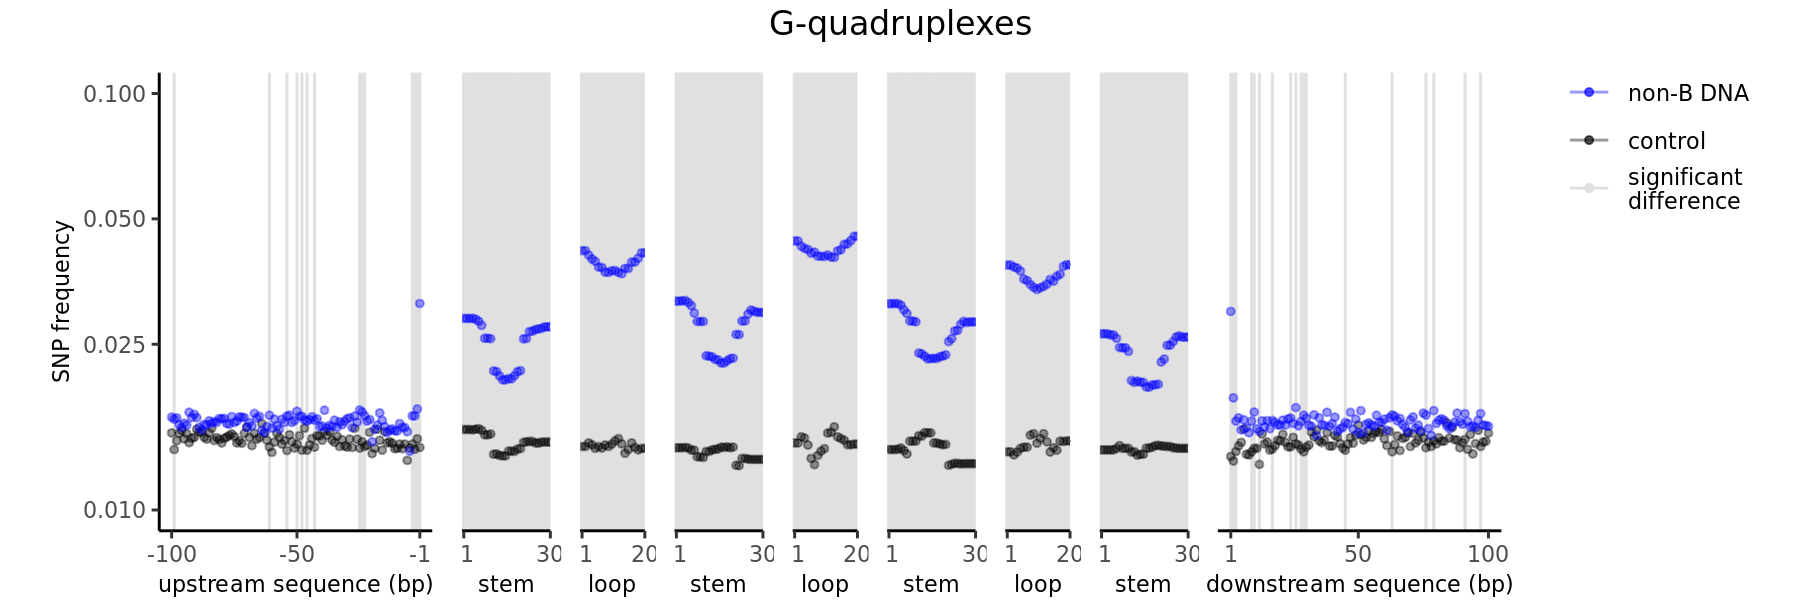

In [407]:
%%R -w 9 -h 3 --units in -r 200

csvfile <- read.csv('NCNRQuadron.SGDP.intersect.csv', header = TRUE)
csvfile <- csvfile[which(csvfile$snp_start != "NA"),]

LeftFlank <- table(csvfile[which(csvfile$snp_pos == "flank1"),10])/50345 
stem1 <- table(csvfile[which(csvfile$snp_pos == "stem1"),10]*30)/50345 
loop1 <- table(csvfile[which(csvfile$snp_pos == "loop1"),10]*20)/50345 
stem2 <- table(csvfile[which(csvfile$snp_pos == "stem2"),10]*30)/50345 
loop2 <- table(csvfile[which(csvfile$snp_pos == "loop2"),10]*20)/50345 
stem3 <- table(csvfile[which(csvfile$snp_pos == "stem3"),10]*30)/50345 
loop3 <- table(csvfile[which(csvfile$snp_pos == "loop3"),10]*20)/50345 
stem4 <- table(csvfile[which(csvfile$snp_pos == "stem4"),10]*30)/50345 
RightFlank <- table(csvfile[which(csvfile$snp_pos == "flank2"),10])/50345 


c_csvfile <- read.csv('NCNRQuadron.ctrl.SGDP.intersect.csv', header = TRUE)
c_csvfile <- c_csvfile[which(c_csvfile$snp_start != "NA"),]

c_LeftFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "flank1"),10])/42104
c_stem1 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem1"),10]*30)/42104
c_loop1 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop1"),10]*20)/42104
c_stem2 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem2"),10]*30)/42104
c_loop2 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop2"),10]*20)/42104
c_stem3 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem3"),10]*30)/42104
c_loop3 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop3"),10]*20)/42104
c_stem4 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem4"),10]*30)/42104
c_RightFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "flank2"),10])/42104


#cols <- c("non-B DNA"=brewer.pal(2, "Paired")[2],
#          "significant\ndifference"= 'gray88',
#          "control"= brewer.pal(8, "Greys")[8])

cols <- c("non-B DNA"=rgb(t(col2rgb('blue')), alpha=100, maxColorValue = 255),
          "significant\ndifference"="grey88",
          "control"=rgb(t(col2rgb('black')), alpha=100, maxColorValue = 255))


load('Quadron.SGDP_motif_vs_control_IWTomics_center_0.01.RData')
load('Quadron.SGDP_motif_vs_control_IWTomics_left_0.01.RData')
load('Quadron.SGDP_motif_vs_control_IWTomics_right_0.01.RData')


LeftFlankDf <- cbind.data.frame(LeftFlank,c_LeftFlank,adj_pvalue_curve_left$significant)[,c(1,2,4,5)]
names(LeftFlankDf) <- c('Levels','Freq','C_Freq','Signif')
LeftFlankDf$Levels <- as.numeric(as.character(LeftFlankDf$Levels))
LeftFlankDf_cut <- LeftFlankDf[which(LeftFlankDf$Levels >= -100),]
LeftFlankDf_cut$Levels <- seq(-100,-1,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem1'),"significant"]
stem1Df <- cbind.data.frame(stem1,c_stem1,Signif)[,c(1,2,4,5)]
names(stem1Df) <- c('Levels','Freq','C_Freq','Signif')
stem1Df$Levels <- seq(1,30,1)


Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop1'),"significant"]
loop1Df <- cbind.data.frame(loop1,c_loop1,Signif)[,c(1,2,4,5)]
names(loop1Df) <- c('Levels','Freq','C_Freq','Signif')
loop1Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem2'),"significant"]
stem2Df <- cbind.data.frame(stem2,c_stem2,Signif)[,c(1,2,4,5)]
names(stem2Df) <- c('Levels','Freq','C_Freq','Signif')
stem2Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop2'),"significant"]
loop2Df <- cbind.data.frame(loop2,c_loop2,Signif)[,c(1,2,4,5)]
names(loop2Df) <- c('Levels','Freq','C_Freq','Signif')
loop2Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem3'),"significant"]
stem3Df <- cbind.data.frame(stem3,c_stem3,Signif)[,c(1,2,4,5)]
names(stem3Df) <- c('Levels','Freq','C_Freq','Signif')
stem3Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop3'),"significant"]
loop3Df <- cbind.data.frame(loop3,c_loop3,Signif)[,c(1,2,4,5)]
names(loop3Df) <- c('Levels','Freq','C_Freq','Signif')
loop3Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem4'),"significant"]
stem4Df <- cbind.data.frame(stem4,c_stem4,Signif)[,c(1,2,4,5)]
names(stem4Df) <- c('Levels','Freq','C_Freq','Signif')
stem4Df$Levels <- seq(1,30,1)


#RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant,rep(-1,length(RightFlank)))[,c(1,2,4,5,6)]
#names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif','Signif_val')
#RightFlankDf[which(RightFlankDf$Signif == "TRUE"), 'Signif_val'] <- 0.1
#RightFlankDf[which(RightFlankDf$Signif == "FALSE"), 'Signif_val'] <- 0.0
#RightFlankDf$Signif_val <- as.numeric(RightFlankDf$Signif_val)
RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant)[,c(1,2,4,5)]
names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif')
RightFlankDf$Levels <- as.numeric(as.character(RightFlankDf$Levels))
RightFlankDf_cut <- RightFlankDf[which(RightFlankDf$Levels <= 100),]
RightFlankDf_cut$Levels <- seq(1,100,1)

p1 <- ggplot(LeftFlankDf_cut, aes(x=Levels)) + 
        #geom_segment(aes(x=Levels, xend=Levels, y=0.0, yend=LeftFlankDf$Signif_val, color="Significant\ndifference")) +
        geom_vline(xintercept= LeftFlankDf_cut[which(LeftFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        #ylim(0.0, .1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.title = element_text(size=8,family="sans"),
            axis.text.x = element_text(size=8,family="sans"),
            axis.text.y = element_text(size=8,family="sans")) +
        labs(y="SNP frequency", x="upstream sequence (bp)", size=8, family='sans') +
        scale_colour_manual(name="",values=cols) +
        scale_x_continuous(breaks =  c(-100,-50,-1), limits = c(-100,-1)) +
        theme(plot.margin = unit(c(10,4,1,1), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1), breaks = c(0.010,0.025,0.050,0.100) )


p2 <- ggplot(stem1Df,  aes(x=Levels)) +
        #geom_segment(aes(x=Levels, xend=Levels, y=0.0, yend=stem1Df$Signif_val, color="Significant\ndifference")) +
        #geom_bar(stat='identity',aes(y=stem1Df$Signif_val, color="Significant\ndifference")) +
        geom_vline(xintercept= stem1Df[which(stem1Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        #ylim(0.0, .1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))



p3 <- ggplot(loop1Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop1Df[which(loop1Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        #ylim(0.0, .1) +
        theme_classic() +  
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p4 <- ggplot(stem2Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem2Df[which(stem2Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        #ylim(0.0, .1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p5 <- ggplot(loop2Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop2Df[which(loop2Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        #ylim(0.0, .1) +
        theme_classic() +
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p6 <- ggplot(stem3Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem3Df[which(stem3Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        #ylim(0.0, .1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p7 <- ggplot(loop3Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop3Df[which(loop3Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        #ylim(0.0, .1) +  
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p8 <- ggplot(stem4Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem4Df[which(stem4Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        #ylim(0.0, .1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p9 <- ggplot(RightFlankDf_cut, aes(x=Levels)) + 
        #geom_bar(stat='identity',aes(y=0, color="Significant\ndifference")) +
        #geom_segment(aes(x=Levels, xend=Levels, y=0.0, yend=0, colour="significant\ndifference")) +
        geom_line(aes(x=0,y=0,colour="significant\ndifference")) +
        geom_vline(xintercept= RightFlankDf_cut[which(RightFlankDf_cut$Signif == "TRUE"),"Levels"], col='gray88') +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        #ylim(0.0, .1) +
        theme_classic() +
        theme(axis.title.y=element_blank(),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.x = element_text(size=8,family="sans"),
            legend.position=c(1.55, 0.9),
            legend.text=element_text(size=8,family="sans")) +
        labs(x="downstream sequence (bp)")+
        scale_colour_manual(name="",values=cols, breaks = c('non-B DNA', 'control', 'significant\ndifference')) +
        scale_x_continuous(breaks = c(1,50,100), limits = c(1,100)) +
        theme(plot.margin = unit(c(10,90,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1)) +
        guides(shape = guide_legend(order = 3))

unit(c(1,10), c("in", "mm"))

#grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol=9, widths=c(1,0.33,0.2,0.33,0.2,0.33,0.2,0.33,1.4),
grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol=9, 
            widths=unit(c(50,15,12,15,12,15,12,15,70), c("mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("G-quadruplexes",gp=gpar(fontsize=12,family="sans")))

g <- arrangeGrob(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol=9, 
            widths=unit(c(50,15,12,15,12,15,12,15,70), c("mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("G-quadruplexes",gp=gpar(fontsize=12,family="sans")))

ggsave(file='QuadronSNP.pdf',g, width=9, height=3, dpi=300)
#ggsave(file='QuadronSNP.png',g, width=8, height=3, dpi=300)


In [ ]:
%%R
# Find furthest significant difference on the upstream sequence
min(adj_pvalue_curve_left[which(adj_pvalue_curve_left$significant == "TRUE"),"snp_coord"])


In [380]:
%%R
# Find furthest significant difference on the downstream sequence
max(adj_pvalue_curve_right[which(adj_pvalue_curve_right$significant == "TRUE"),"snp_coord"])


[1] 1967



	Two-sample Kolmogorov-Smirnov test

data:  stems_MAFs and loops_MAFs
D = 0.094269, p-value < 2.2e-16
alternative hypothesis: two-sided

[1] 0


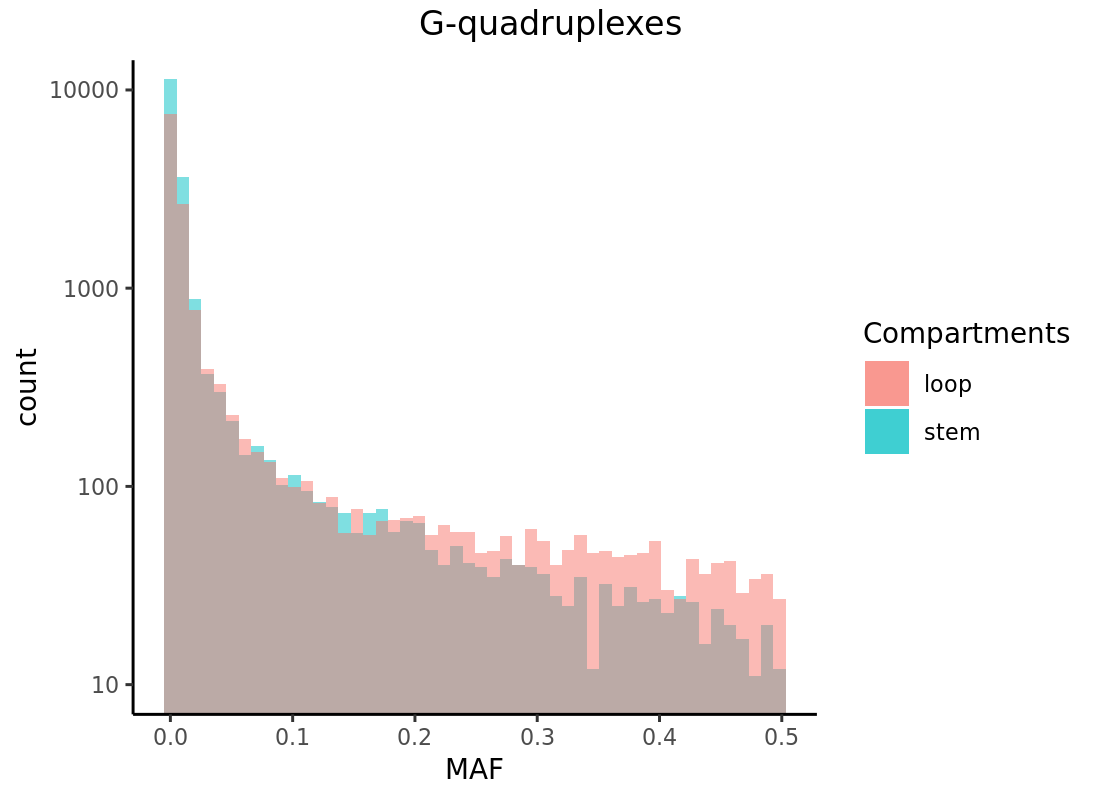

In [435]:
%%R -w 5.5 -h 4 --units in -r 200

# Comparing the Site Frequency Spectrums of stems and loops

intersectfile <- read.table('NCNRQuadron.SGDP.intersect')
intersectfile <- intersectfile[which(intersectfile$V7 != "-1"),]

stems <- intersectfile[which(substr(intersectfile$V5, 1,4) == 'stem'),]
loops <- intersectfile[which(substr(intersectfile$V5, 1,4) == 'loop'),]

stems[which(as.numeric(as.character(stems$V11))>0.5),]$V11 <- 1 - stems[which(as.numeric(as.character(stems$V11))>0.5),]$V11
loops[which(as.numeric(as.character(loops$V11))>0.5),]$V11 <- 1 - loops[which(as.numeric(as.character(loops$V11))>0.5),]$V11

toplot <- rbind(stems,loops)[,c(5,11)]

colnames(toplot) <- c('Compartments', 'MAF')
toplot$Compartments <- substr(toplot$Compartments, 1,4)


toplot$MAF <- as.numeric(as.character(toplot$MAF))


p1 <- ggplot(data=toplot, aes(x=MAF, fill=Compartments)) + 
    geom_histogram(data=subset(toplot, Compartments == 'stem'), alpha = .5, bins = 50) +
    geom_histogram(data=subset(toplot, Compartments == 'loop'), alpha = .5, bins = 50) +
            theme_classic() +
            scale_y_log10() +
            coord_cartesian(ylim=c(10,10000)) +
            theme(text=element_text(size=10,family="sans"))

grid.arrange(p1, ncol=1, top=textGrob("G-quadruplexes",gp=gpar(fontsize=12,font=1)))

g <- arrangeGrob(p1, ncol=1, top=textGrob("G-quadruplexes",gp=gpar(fontsize=12,font=1)))

ggsave(file='SFS.pdf',g, width=5.5, height=4, dpi=300)

stems_MAFs <- as.numeric(stems$V11)
loops_MAFs <- as.numeric(loops$V11)

KS <- ks.test(stems_MAFs,loops_MAFs)

print(KS)
print(KS$p.value)


In [118]:
%%R
# fold difference in stems
stems <- rbind(stem1Df,stem2Df,stem3Df,stem4Df)
print(max(stems$Freq/stems$C_Freq))

[1] 2.282209


In [119]:
%%R
# fold difference in loops
loops <- rbind(loop1Df,loop2Df,loop3Df)
print(max(loops$Freq/loops$C_Freq))

[1] 3.237028


In [122]:
%%R
# fold difference in flanks
flanks <- rbind(LeftFlankDf,RightFlankDf)
print(max(flanks$Freq/flanks$C_Freq))

[1] 2.229666


In [408]:
%%R
# fold difference in flanks futher than adjacent position
l_flank <- LeftFlankDf[which(LeftFlankDf$Levels != "-1"),]
r_flank <- RightFlankDf[which(RightFlankDf$Levels != "1"),]

flanks <- rbind(l_flank,r_flank)
print(max(flanks$Freq/flanks$C_Freq))

[1] 1.41809


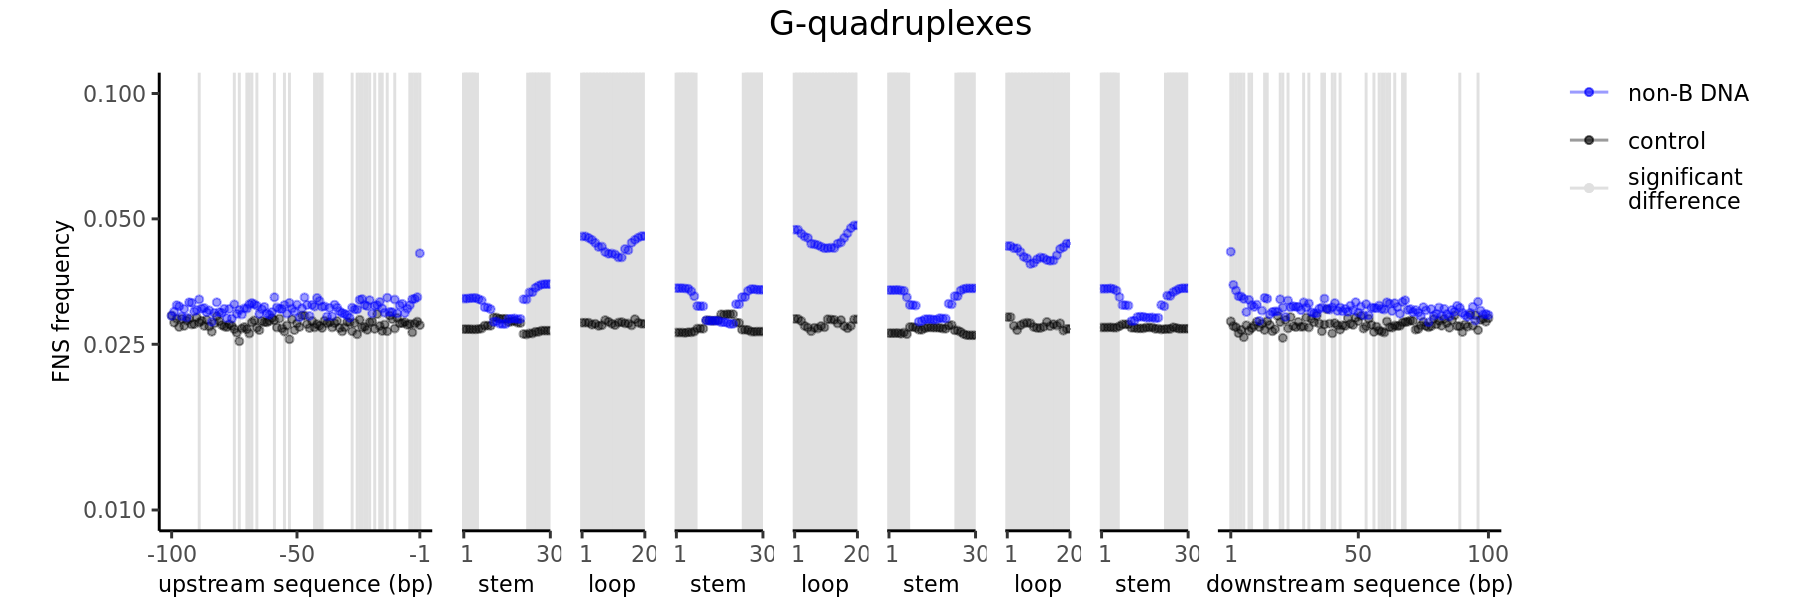

In [409]:
%%R -w 9 -h 3 --units in -r 200

csvfile <- read.csv('NCNRQuadron.divergence.intersect.csv', header = TRUE)
csvfile <- csvfile[which(csvfile$snp_start != "NA"),]

LeftFlank <- table(csvfile[which(csvfile$snp_pos == "flank1"),10])/50345 
stem1 <- table(csvfile[which(csvfile$snp_pos == "stem1"),10]*30)/50345 
loop1 <- table(csvfile[which(csvfile$snp_pos == "loop1"),10]*20)/50345 
stem2 <- table(csvfile[which(csvfile$snp_pos == "stem2"),10]*30)/50345 
loop2 <- table(csvfile[which(csvfile$snp_pos == "loop2"),10]*20)/50345 
stem3 <- table(csvfile[which(csvfile$snp_pos == "stem3"),10]*30)/50345 
loop3 <- table(csvfile[which(csvfile$snp_pos == "loop3"),10]*20)/50345 
stem4 <- table(csvfile[which(csvfile$snp_pos == "stem4"),10]*30)/50345 
RightFlank <- table(csvfile[which(csvfile$snp_pos == "flank2"),10])/50345 


c_csvfile <- read.csv('NCNRQuadron.ctrl.divergence.intersect.csv', header = TRUE)
c_csvfile <- c_csvfile[which(c_csvfile$snp_start != "NA"),]

c_LeftFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "flank1"),10])/42104
c_stem1 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem1"),10]*30)/42104
c_loop1 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop1"),10]*20)/42104
c_stem2 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem2"),10]*30)/42104
c_loop2 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop2"),10]*20)/42104
c_stem3 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem3"),10]*30)/42104
c_loop3 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop3"),10]*20)/42104
c_stem4 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem4"),10]*30)/42104
c_RightFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "flank2"),10])/42104


#cols <- c("non-B DNA"=brewer.pal(2, "Paired")[2],
#          "significant\ndifference"= 'gray88',
#          "control"= brewer.pal(8, "Greys")[8])

cols <- c("non-B DNA"=rgb(t(col2rgb('blue')), alpha=100, maxColorValue = 255),
          "significant\ndifference"="grey88",
          "control"=rgb(t(col2rgb('black')), alpha=100, maxColorValue = 255))


load('Quadron.divergence_motif_vs_control_IWTomics_center_0.01.RData')
load('Quadron.divergence_motif_vs_control_IWTomics_left_0.01.RData')
load('Quadron.divergence_motif_vs_control_IWTomics_right_0.01.RData')


LeftFlankDf <- cbind.data.frame(LeftFlank,c_LeftFlank,adj_pvalue_curve_left$significant)[,c(1,2,4,5)]
names(LeftFlankDf) <- c('Levels','Freq','C_Freq','Signif')
LeftFlankDf$Levels <- as.numeric(as.character(LeftFlankDf$Levels))
LeftFlankDf_cut <- LeftFlankDf[which(LeftFlankDf$Levels >= -100),]
LeftFlankDf_cut$Levels <- seq(-100,-1,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem1'),"significant"]
stem1Df <- cbind.data.frame(stem1,c_stem1,Signif)[,c(1,2,4,5)]
names(stem1Df) <- c('Levels','Freq','C_Freq','Signif')
stem1Df$Levels <- seq(1,30,1)


Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop1'),"significant"]
loop1Df <- cbind.data.frame(loop1,c_loop1,Signif)[,c(1,2,4,5)]
names(loop1Df) <- c('Levels','Freq','C_Freq','Signif')
loop1Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem2'),"significant"]
stem2Df <- cbind.data.frame(stem2,c_stem2,Signif)[,c(1,2,4,5)]
names(stem2Df) <- c('Levels','Freq','C_Freq','Signif')
stem2Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop2'),"significant"]
loop2Df <- cbind.data.frame(loop2,c_loop2,Signif)[,c(1,2,4,5)]
names(loop2Df) <- c('Levels','Freq','C_Freq','Signif')
loop2Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem3'),"significant"]
stem3Df <- cbind.data.frame(stem3,c_stem3,Signif)[,c(1,2,4,5)]
names(stem3Df) <- c('Levels','Freq','C_Freq','Signif')
stem3Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop3'),"significant"]
loop3Df <- cbind.data.frame(loop3,c_loop3,Signif)[,c(1,2,4,5)]
names(loop3Df) <- c('Levels','Freq','C_Freq','Signif')
loop3Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem4'),"significant"]
stem4Df <- cbind.data.frame(stem4,c_stem4,Signif)[,c(1,2,4,5)]
names(stem4Df) <- c('Levels','Freq','C_Freq','Signif')
stem4Df$Levels <- seq(1,30,1)


#RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant,rep(-1,length(RightFlank)))[,c(1,2,4,5,6)]
#names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif','Signif_val')
#RightFlankDf[which(RightFlankDf$Signif == "TRUE"), 'Signif_val'] <- 0.1
#RightFlankDf[which(RightFlankDf$Signif == "FALSE"), 'Signif_val'] <- 0.0
#RightFlankDf$Signif_val <- as.numeric(RightFlankDf$Signif_val)
RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant)[,c(1,2,4,5)]
names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif')
RightFlankDf$Levels <- as.numeric(as.character(RightFlankDf$Levels))
RightFlankDf_cut <- RightFlankDf[which(RightFlankDf$Levels <= 100),]
RightFlankDf_cut$Levels <- seq(1,100,1)

p1 <- ggplot(LeftFlankDf_cut, aes(x=Levels)) + 
        #geom_segment(aes(x=Levels, xend=Levels, y=0.0, yend=LeftFlankDf$Signif_val, color="Significant\ndifference")) +
        geom_vline(xintercept= LeftFlankDf_cut[which(LeftFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        #ylim(0.0, .1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.title = element_text(size=8,family="sans"),
            axis.text.x = element_text(size=8,family="sans"),
            axis.text.y = element_text(size=8,family="sans")) +
        labs(y="FNS frequency", x="upstream sequence (bp)", size=8, family='sans') +
        scale_colour_manual(name="",values=cols) +
        scale_x_continuous(breaks =  c(-100,-50,-1), limits = c(-100,-1)) +
        theme(plot.margin = unit(c(10,4,1,1), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1), breaks = c(0.010,0.025,0.050,0.100) )


p2 <- ggplot(stem1Df,  aes(x=Levels)) +
        #geom_segment(aes(x=Levels, xend=Levels, y=0.0, yend=stem1Df$Signif_val, color="Significant\ndifference")) +
        #geom_bar(stat='identity',aes(y=stem1Df$Signif_val, color="Significant\ndifference")) +
        geom_vline(xintercept= stem1Df[which(stem1Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        #ylim(0.0, .1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))



p3 <- ggplot(loop1Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop1Df[which(loop1Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        #ylim(0.0, .1) +
        theme_classic() +  
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p4 <- ggplot(stem2Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem2Df[which(stem2Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        #ylim(0.0, .1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p5 <- ggplot(loop2Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop2Df[which(loop2Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        #ylim(0.0, .1) +
        theme_classic() +
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p6 <- ggplot(stem3Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem3Df[which(stem3Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        #ylim(0.0, .1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p7 <- ggplot(loop3Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop3Df[which(loop3Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        #ylim(0.0, .1) +  
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p8 <- ggplot(stem4Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem4Df[which(stem4Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        #ylim(0.0, .1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p9 <- ggplot(RightFlankDf_cut, aes(x=Levels)) + 
        #geom_bar(stat='identity',aes(y=0, color="Significant\ndifference")) +
        #geom_segment(aes(x=Levels, xend=Levels, y=0.0, yend=0, colour="significant\ndifference")) +
        geom_line(aes(x=0,y=0,colour="significant\ndifference")) +
        geom_vline(xintercept= RightFlankDf_cut[which(RightFlankDf_cut$Signif == "TRUE"),"Levels"], col='gray88') +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        #ylim(0.0, .1) +
        theme_classic() +
        theme(axis.title.y=element_blank(),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.x = element_text(size=8,family="sans"),
            legend.position=c(1.55, 0.9),
            legend.text=element_text(size=8,family="sans")) +
        labs(x="downstream sequence (bp)")+
        scale_colour_manual(name="",values=cols, breaks = c('non-B DNA', 'control', 'significant\ndifference')) +
        scale_x_continuous(breaks = c(1,50,100), limits = c(1,100)) +
        theme(plot.margin = unit(c(10,90,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1)) +
        guides(shape = guide_legend(order = 3))


grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol=9, 
            widths=unit(c(50,15,12,15,12,15,12,15,70), c("mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("G-quadruplexes",gp=gpar(fontsize=12,family="sans")))

g <- arrangeGrob(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol=9, 
            widths=unit(c(50,15,12,15,12,15,12,15,70), c("mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("G-quadruplexes",gp=gpar(fontsize=12,family="sans")))

ggsave(file='QuadronDivergence.pdf',g, width=9, height=3, dpi=300)



In [376]:
%%R
min(adj_pvalue_curve_left[which(adj_pvalue_curve_left$significant == "TRUE"),"snp_coord"])


[1] -1966


In [377]:
%%R
max(adj_pvalue_curve_right[which(adj_pvalue_curve_right$significant == "TRUE"),"snp_coord"])


[1] 1986


In [124]:
%%R
stems <- rbind(stem1Df,stem2Df,stem3Df,stem4Df)
print(max(stems$Freq/stems$C_Freq))

[1] 1.296053


In [125]:
%%R
loops <- rbind(loop1Df,loop2Df,loop3Df)
print(max(loops$Freq/loops$C_Freq))

[1] 1.717126


In [126]:
%%R
flanks <- rbind(LeftFlankDf,RightFlankDf)
print(max(flanks$Freq/flanks$C_Freq))

[1] 1.487487


In [410]:
%%R

l_flank <- LeftFlankDf[which(LeftFlankDf$Levels != "-1"),]
r_flank <- RightFlankDf[which(RightFlankDf$Levels != "1"),]

flanks <- rbind(l_flank,r_flank)
print(max(flanks$Freq/flanks$C_Freq))

[1] 1.255901


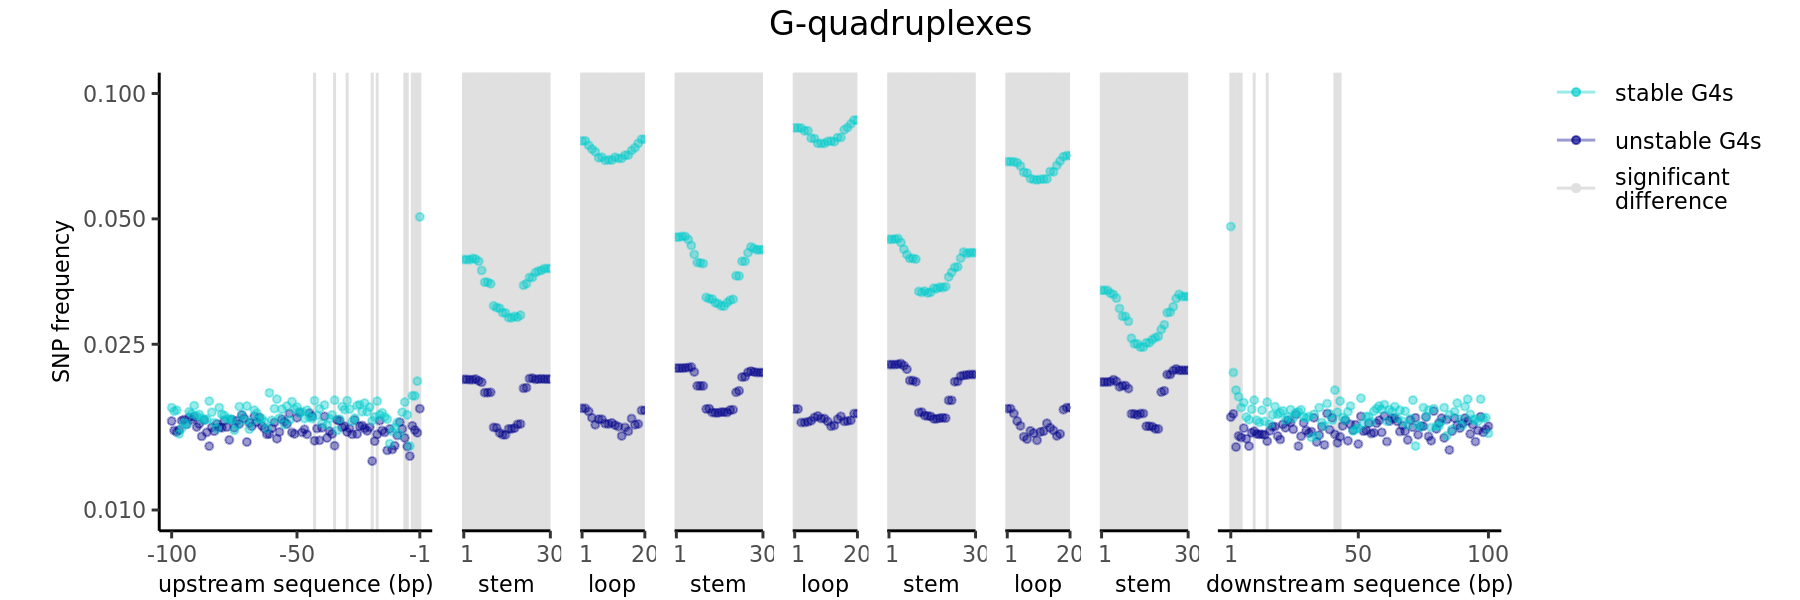

In [418]:
%%R -w 9 -h 3 --units in -r 200

csvfile <- read.csv('NCNRQuadron.high.SGDP.intersect.csv', header = TRUE)
csvfile <- csvfile[which(csvfile$snp_start != "NA"),]

LeftFlank <- table(csvfile[which(csvfile$snp_pos == "flank1"),10])/20156 
stem1 <- table(csvfile[which(csvfile$snp_pos == "stem1"),10]*30)/20156 
loop1 <- table(csvfile[which(csvfile$snp_pos == "loop1"),10]*20)/20156 
stem2 <- table(csvfile[which(csvfile$snp_pos == "stem2"),10]*30)/20156 
loop2 <- table(csvfile[which(csvfile$snp_pos == "loop2"),10]*20)/20156
stem3 <- table(csvfile[which(csvfile$snp_pos == "stem3"),10]*30)/20156 
loop3 <- table(csvfile[which(csvfile$snp_pos == "loop3"),10]*20)/20156
stem4 <- table(csvfile[which(csvfile$snp_pos == "stem4"),10]*30)/20156
RightFlank <- table(csvfile[which(csvfile$snp_pos == "flank2"),10])/20156


c_csvfile <- read.csv('NCNRQuadron.low.SGDP.intersect.csv', header = TRUE)
c_csvfile <- c_csvfile[which(c_csvfile$snp_start != "NA"),]

c_LeftFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "flank1"),10])/30212
c_stem1 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem1"),10]*30)/30212
c_loop1 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop1"),10]*20)/30212
c_stem2 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem2"),10]*30)/30212
c_loop2 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop2"),10]*20)/30212
c_stem3 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem3"),10]*30)/30212
c_loop3 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop3"),10]*20)/30212
c_stem4 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem4"),10]*30)/30212
c_RightFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "flank2"),10])/30212

cols <- c("stable"=rgb(t(col2rgb('cyan3')), alpha=100, maxColorValue = 255),
          "significant\ndifference"= 'gray88',
          "unstable"=rgb(t(col2rgb('blue4')), alpha=100, maxColorValue = 255))

load('Quadron.highVlow.SGDP_motif_vs_control_IWTomics_center.RData')
load('Quadron.highVlow.SGDP_motif_vs_control_IWTomics_left.RData')
load('Quadron.highVlow.SGDP_motif_vs_control_IWTomics_right.RData')


LeftFlankDf <- cbind.data.frame(LeftFlank,c_LeftFlank,adj_pvalue_curve_left$significant)[,c(1,2,4,5)]
names(LeftFlankDf) <- c('Levels','Freq','C_Freq','Signif')
LeftFlankDf$Levels <- as.numeric(as.character(LeftFlankDf$Levels))
LeftFlankDf_cut <- LeftFlankDf[which(LeftFlankDf$Levels >= -100),]
LeftFlankDf_cut$Levels <- seq(-100,-1,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem1'),"significant"]
stem1Df <- cbind.data.frame(stem1,c_stem1,Signif)[,c(1,2,4,5)]
names(stem1Df) <- c('Levels','Freq','C_Freq','Signif')
stem1Df$Levels <- seq(1,30,1)


Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop1'),"significant"]
loop1Df <- cbind.data.frame(loop1,c_loop1,Signif)[,c(1,2,4,5)]
names(loop1Df) <- c('Levels','Freq','C_Freq','Signif')
loop1Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem2'),"significant"]
stem2Df <- cbind.data.frame(stem2,c_stem2,Signif)[,c(1,2,4,5)]
names(stem2Df) <- c('Levels','Freq','C_Freq','Signif')
stem2Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop2'),"significant"]
loop2Df <- cbind.data.frame(loop2,c_loop2,Signif)[,c(1,2,4,5)]
names(loop2Df) <- c('Levels','Freq','C_Freq','Signif')
loop2Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem3'),"significant"]
stem3Df <- cbind.data.frame(stem3,c_stem3,Signif)[,c(1,2,4,5)]
names(stem3Df) <- c('Levels','Freq','C_Freq','Signif')
stem3Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop3'),"significant"]
loop3Df <- cbind.data.frame(loop3,c_loop3,Signif)[,c(1,2,4,5)]
names(loop3Df) <- c('Levels','Freq','C_Freq','Signif')
loop3Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem4'),"significant"]
stem4Df <- cbind.data.frame(stem4,c_stem4,Signif)[,c(1,2,4,5)]
names(stem4Df) <- c('Levels','Freq','C_Freq','Signif')
stem4Df$Levels <- seq(1,30,1)


RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant)[,c(1,2,4,5)]
names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif')
RightFlankDf$Levels <- as.numeric(as.character(RightFlankDf$Levels))
RightFlankDf_cut <- RightFlankDf[which(RightFlankDf$Levels <= 100),]
RightFlankDf_cut$Levels <- seq(1,100,1)
                     

p1 <- ggplot(LeftFlankDf_cut, aes(x=Levels)) + 
        geom_vline(xintercept= LeftFlankDf_cut[which(LeftFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
        geom_point(aes(y=C_Freq,col="unstable"), size = 1) +
        geom_point(aes(y=Freq,col="stable"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.title = element_text(size=8,family="sans"),
            axis.text.x = element_text(size=8,family="sans"),
            axis.text.y = element_text(size=8,family="sans")) +
        labs(y="SNP frequency", x="upstream sequence (bp)", size=8, family='sans') +
        scale_colour_manual(name="",values=cols) +
        scale_x_continuous(breaks =  c(-100,-50,-1), limits = c(-100,-1)) +
        theme(plot.margin = unit(c(10,4,1,1), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1), breaks = c(0.010,0.025,0.050,0.100) )


p2 <- ggplot(stem1Df,  aes(x=Levels)) +
        geom_vline(xintercept= stem1Df[which(stem1Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="unstable"), size = 1) +
        geom_point(aes(y=Freq,col="stable"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))



p3 <- ggplot(loop1Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop1Df[which(loop1Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="unstable"), size = 1) +
        geom_point(aes(y=Freq,col="stable"), size = 1) +
        theme_classic() +  
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p4 <- ggplot(stem2Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem2Df[which(stem2Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="unstable"), size = 1) +
        geom_point(aes(y=Freq,col="stable"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p5 <- ggplot(loop2Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop2Df[which(loop2Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="unstable"), size = 1) +
        geom_point(aes(y=Freq,col="stable"), size = 1) +
        theme_classic() +
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p6 <- ggplot(stem3Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem3Df[which(stem3Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="unstable"), size = 1) +
        geom_point(aes(y=Freq,col="stable"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p7 <- ggplot(loop3Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop3Df[which(loop3Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="unstable"), size = 1) +
        geom_point(aes(y=Freq,col="stable"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p8 <- ggplot(stem4Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem4Df[which(stem4Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="unstable"), size = 1) +
        geom_point(aes(y=Freq,col="stable"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p9 <- ggplot(RightFlankDf_cut, aes(x=Levels)) + 
        geom_line(aes(x=0,y=0,colour="significant\ndifference")) +
        geom_vline(xintercept= RightFlankDf_cut[which(RightFlankDf_cut$Signif == "TRUE"),"Levels"], col='gray88') +
        geom_point(aes(y=C_Freq,col="unstable"), size = 1) +
        geom_point(aes(y=Freq,col="stable"), size = 1) +
        theme_classic() +
        theme(axis.title.y=element_blank(),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.x = element_text(size=8,family="sans"),
            legend.position=c(1.55, 0.9),
            legend.text=element_text(size=8,family="sans")) +
        labs(x="downstream sequence (bp)")+
        scale_colour_manual(name="",values=cols,
                            breaks = c('stable', 'unstable', 'significant\ndifference'),
                           labels = c('stable G4s', 'unstable G4s', 'significant\ndifference')) +
        scale_x_continuous(breaks = c(1,50,100), limits = c(1,100)) +
        theme(plot.margin = unit(c(10,90,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1)) +
        guides(shape = guide_legend(order = 3))

grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol=9, 
            widths=unit(c(50,15,12,15,12,15,12,15,70), c("mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("G-quadruplexes",gp=gpar(fontsize=12,family="sans")))

g <- arrangeGrob(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol=9, 
            widths=unit(c(50,15,12,15,12,15,12,15,70), c("mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("G-quadruplexes",gp=gpar(fontsize=12,family="sans")))

ggsave(file='QuadronHighLowSNP.pdf',g, width=9, height=3, dpi=300)


In [ ]:
%%R
stems <- rbind(stem1Df,stem2Df,stem3Df,stem4Df)
print(max(stems$H_Freq/stems$L_Freq))

In [784]:
%%R
loops <- rbind(loop1Df,loop2Df,loop3Df)
print(max(loops$H_Freq/loops$L_Freq))

[1] 5.149476


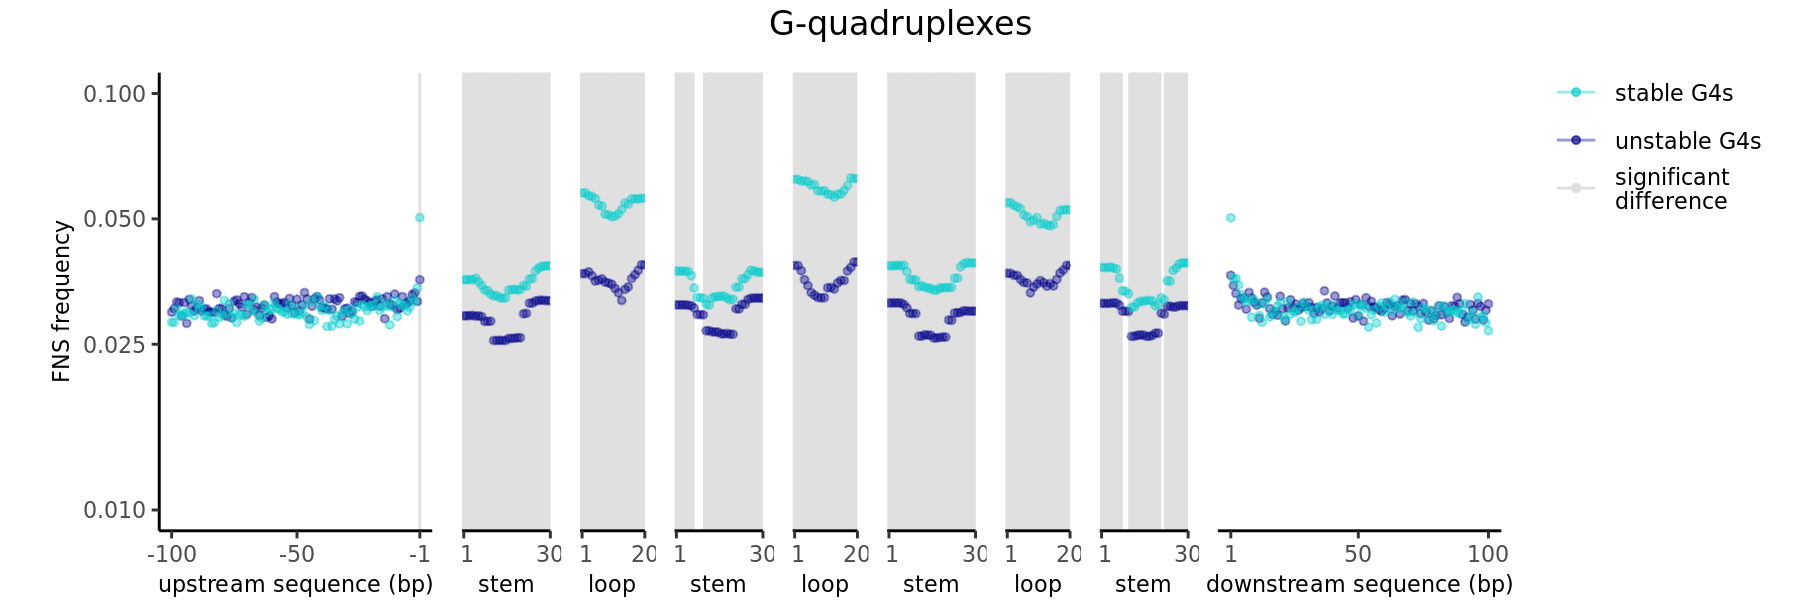

In [417]:
%%R -w 9 -h 3 --units in -r 200

csvfile <- read.csv('NCNRQuadron.high.divergence.intersect.csv', header = TRUE)
csvfile <- csvfile[which(csvfile$snp_start != "NA"),]

LeftFlank <- table(csvfile[which(csvfile$snp_pos == "flank1"),10])/20156 
stem1 <- table(csvfile[which(csvfile$snp_pos == "stem1"),10]*30)/20156 
loop1 <- table(csvfile[which(csvfile$snp_pos == "loop1"),10]*20)/20156 
stem2 <- table(csvfile[which(csvfile$snp_pos == "stem2"),10]*30)/20156 
loop2 <- table(csvfile[which(csvfile$snp_pos == "loop2"),10]*20)/20156
stem3 <- table(csvfile[which(csvfile$snp_pos == "stem3"),10]*30)/20156 
loop3 <- table(csvfile[which(csvfile$snp_pos == "loop3"),10]*20)/20156
stem4 <- table(csvfile[which(csvfile$snp_pos == "stem4"),10]*30)/20156
RightFlank <- table(csvfile[which(csvfile$snp_pos == "flank2"),10])/20156


c_csvfile <- read.csv('NCNRQuadron.low.divergence.intersect.csv', header = TRUE)
c_csvfile <- c_csvfile[which(c_csvfile$snp_start != "NA"),]

c_LeftFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "flank1"),10])/30212
c_stem1 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem1"),10]*30)/30212
c_loop1 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop1"),10]*20)/30212
c_stem2 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem2"),10]*30)/30212
c_loop2 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop2"),10]*20)/30212
c_stem3 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem3"),10]*30)/30212
c_loop3 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop3"),10]*20)/30212
c_stem4 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem4"),10]*30)/30212
c_RightFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "flank2"),10])/30212

cols <- c("stable"=rgb(t(col2rgb('cyan3')), alpha=100, maxColorValue = 255),
          "significant\ndifference"= 'gray88',
          "unstable"=rgb(t(col2rgb('blue4')), alpha=100, maxColorValue = 255))

load('Quadron.highVlow.divergence_motif_vs_control_IWTomics_center.RData')
load('Quadron.highVlow.divergence_motif_vs_control_IWTomics_left.RData')
load('Quadron.highVlow.divergence_motif_vs_control_IWTomics_right.RData')


LeftFlankDf <- cbind.data.frame(LeftFlank,c_LeftFlank,adj_pvalue_curve_left$significant)[,c(1,2,4,5)]
names(LeftFlankDf) <- c('Levels','Freq','C_Freq','Signif')
LeftFlankDf$Levels <- as.numeric(as.character(LeftFlankDf$Levels))
LeftFlankDf_cut <- LeftFlankDf[which(LeftFlankDf$Levels >= -100),]
LeftFlankDf_cut$Levels <- seq(-100,-1,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem1'),"significant"]
stem1Df <- cbind.data.frame(stem1,c_stem1,Signif)[,c(1,2,4,5)]
names(stem1Df) <- c('Levels','Freq','C_Freq','Signif')
stem1Df$Levels <- seq(1,30,1)


Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop1'),"significant"]
loop1Df <- cbind.data.frame(loop1,c_loop1,Signif)[,c(1,2,4,5)]
names(loop1Df) <- c('Levels','Freq','C_Freq','Signif')
loop1Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem2'),"significant"]
stem2Df <- cbind.data.frame(stem2,c_stem2,Signif)[,c(1,2,4,5)]
names(stem2Df) <- c('Levels','Freq','C_Freq','Signif')
stem2Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop2'),"significant"]
loop2Df <- cbind.data.frame(loop2,c_loop2,Signif)[,c(1,2,4,5)]
names(loop2Df) <- c('Levels','Freq','C_Freq','Signif')
loop2Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem3'),"significant"]
stem3Df <- cbind.data.frame(stem3,c_stem3,Signif)[,c(1,2,4,5)]
names(stem3Df) <- c('Levels','Freq','C_Freq','Signif')
stem3Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop3'),"significant"]
loop3Df <- cbind.data.frame(loop3,c_loop3,Signif)[,c(1,2,4,5)]
names(loop3Df) <- c('Levels','Freq','C_Freq','Signif')
loop3Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem4'),"significant"]
stem4Df <- cbind.data.frame(stem4,c_stem4,Signif)[,c(1,2,4,5)]
names(stem4Df) <- c('Levels','Freq','C_Freq','Signif')
stem4Df$Levels <- seq(1,30,1)


RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant)[,c(1,2,4,5)]
names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif')
RightFlankDf$Levels <- as.numeric(as.character(RightFlankDf$Levels))
RightFlankDf_cut <- RightFlankDf[which(RightFlankDf$Levels <= 100),]
RightFlankDf_cut$Levels <- seq(1,100,1)
                     

p1 <- ggplot(LeftFlankDf_cut, aes(x=Levels)) + 
        geom_vline(xintercept= LeftFlankDf_cut[which(LeftFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
        geom_point(aes(y=C_Freq,col="unstable"), size = 1) +
        geom_point(aes(y=Freq,col="stable"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.title = element_text(size=8,family="sans"),
            axis.text.x = element_text(size=8,family="sans"),
            axis.text.y = element_text(size=8,family="sans")) +
        labs(y="FNS frequency", x="upstream sequence (bp)", size=8, family='sans') +
        scale_colour_manual(name="",values=cols) +
        scale_x_continuous(breaks =  c(-100,-50,-1), limits = c(-100,-1)) +
        theme(plot.margin = unit(c(10,4,1,1), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1), breaks = c(0.010,0.025,0.050,0.100) )


p2 <- ggplot(stem1Df,  aes(x=Levels)) +
        geom_vline(xintercept= stem1Df[which(stem1Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="unstable"), size = 1) +
        geom_point(aes(y=Freq,col="stable"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))



p3 <- ggplot(loop1Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop1Df[which(loop1Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="unstable"), size = 1) +
        geom_point(aes(y=Freq,col="stable"), size = 1) +
        theme_classic() +  
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p4 <- ggplot(stem2Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem2Df[which(stem2Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="unstable"), size = 1) +
        geom_point(aes(y=Freq,col="stable"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p5 <- ggplot(loop2Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop2Df[which(loop2Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="unstable"), size = 1) +
        geom_point(aes(y=Freq,col="stable"), size = 1) +
        theme_classic() +
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p6 <- ggplot(stem3Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem3Df[which(stem3Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="unstable"), size = 1) +
        geom_point(aes(y=Freq,col="stable"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p7 <- ggplot(loop3Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop3Df[which(loop3Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="unstable"), size = 1) +
        geom_point(aes(y=Freq,col="stable"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p8 <- ggplot(stem4Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem4Df[which(stem4Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="unstable"), size = 1) +
        geom_point(aes(y=Freq,col="stable"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p9 <- ggplot(RightFlankDf_cut, aes(x=Levels)) + 
        geom_line(aes(x=0,y=0,colour="significant\ndifference")) +
        geom_vline(xintercept= RightFlankDf_cut[which(RightFlankDf_cut$Signif == "TRUE"),"Levels"], col='gray88') +
        geom_point(aes(y=C_Freq,col="unstable"), size = 1) +
        geom_point(aes(y=Freq,col="stable"), size = 1) +
        theme_classic() +
        theme(axis.title.y=element_blank(),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.x = element_text(size=8,family="sans"),
            legend.position=c(1.55, 0.9),
            legend.text=element_text(size=8,family="sans")) +
        labs(x="downstream sequence (bp)")+
        scale_colour_manual(name="",values=cols,
                            breaks = c('stable', 'unstable', 'significant\ndifference'),
                           labels = c('stable G4s', 'unstable G4s', 'significant\ndifference')) +
        scale_x_continuous(breaks = c(1,50,100), limits = c(1,100)) +
        theme(plot.margin = unit(c(10,90,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1)) +
        guides(shape = guide_legend(order = 3))

grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol=9, 
            widths=unit(c(50,15,12,15,12,15,12,15,70), c("mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("G-quadruplexes",gp=gpar(fontsize=12,family="sans")))

g <- arrangeGrob(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol=9, 
            widths=unit(c(50,15,12,15,12,15,12,15,70), c("mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("G-quadruplexes",gp=gpar(fontsize=12,family="sans")))

ggsave(file='QuadronHighLowDivergence.pdf',g, width=9, height=3, dpi=300)


In [786]:
%%R
stems <- rbind(stem1Df,stem2Df,stem3Df,stem4Df)
print(max(stems$H_Freq/stems$L_Freq))

[1] 1.320557


In [787]:
%%R
loops <- rbind(loop1Df,loop2Df,loop3Df)
print(max(loops$H_Freq/loops$L_Freq))

[1] 1.843763


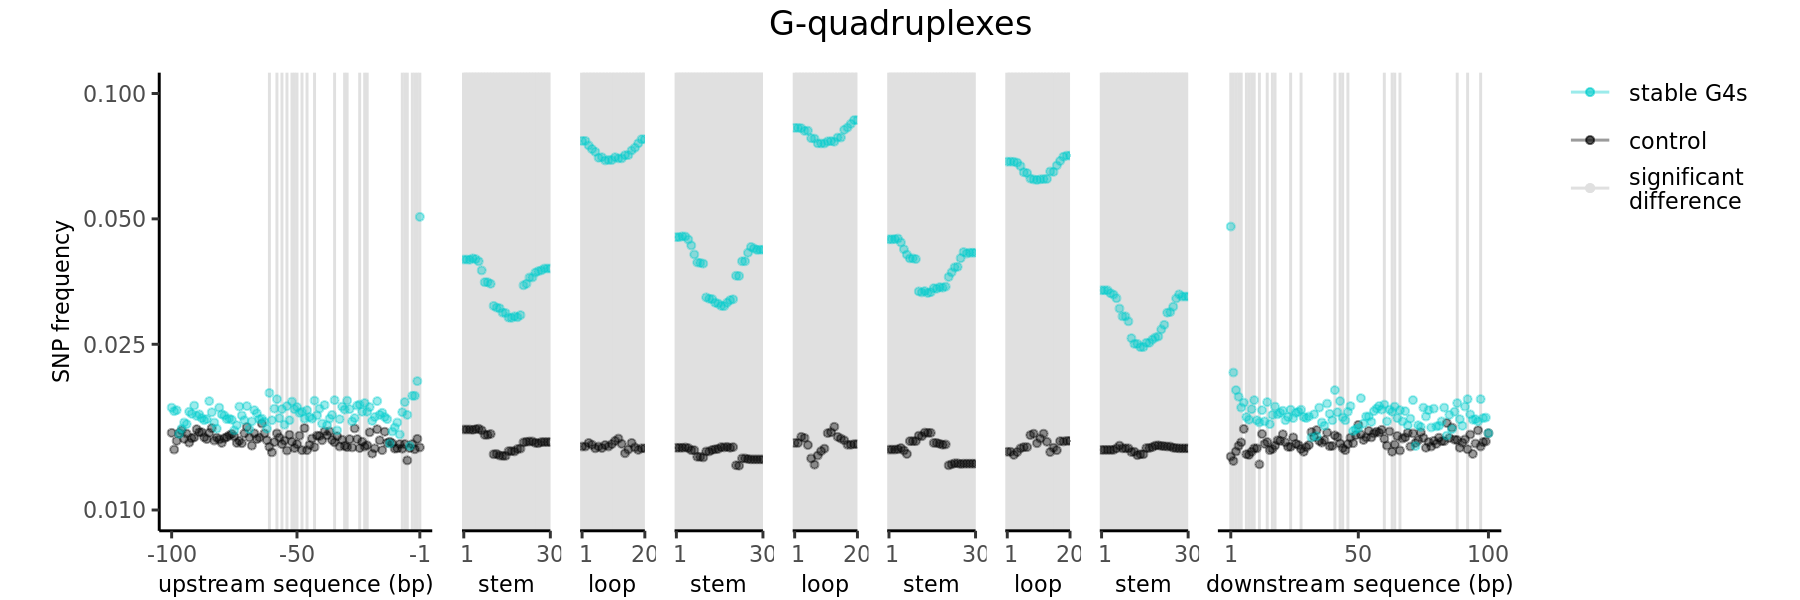

In [423]:
%%R -w 9 -h 3 --units in -r 200

csvfile <- read.csv('NCNRQuadron.high.SGDP.intersect.csv', header = TRUE)
csvfile <- csvfile[which(csvfile$snp_start != "NA"),]

LeftFlank <- table(csvfile[which(csvfile$snp_pos == "flank1"),10])/20156 
stem1 <- table(csvfile[which(csvfile$snp_pos == "stem1"),10])/20156 
loop1 <- table(csvfile[which(csvfile$snp_pos == "loop1"),10])/20156 
stem2 <- table(csvfile[which(csvfile$snp_pos == "stem2"),10])/20156 
loop2 <- table(csvfile[which(csvfile$snp_pos == "loop2"),10])/20156 
stem3 <- table(csvfile[which(csvfile$snp_pos == "stem3"),10])/20156 
loop3 <- table(csvfile[which(csvfile$snp_pos == "loop3"),10])/20156 
stem4 <- table(csvfile[which(csvfile$snp_pos == "stem4"),10])/20156 
RightFlank <- table(csvfile[which(csvfile$snp_pos == "flank2"),10])/20156 


c_csvfile <- read.csv('NCNRQuadron.ctrl.SGDP.intersect.csv', header = TRUE)
c_csvfile <- c_csvfile[which(c_csvfile$snp_start != "NA"),]

c_LeftFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "flank1"),10])/42104
c_stem1 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem1"),10])/42104
c_loop1 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop1"),10])/42104
c_stem2 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem2"),10])/42104
c_loop2 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop2"),10])/42104
c_stem3 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem3"),10])/42104
c_loop3 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop3"),10])/42104
c_stem4 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem4"),10])/42104
c_RightFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "flank2"),10])/42104


cols <- c("non-B DNA"=rgb(t(col2rgb('cyan3')), alpha=100, maxColorValue = 255),
          "significant\ndifference"="grey88",
          "control"=rgb(t(col2rgb('black')), alpha=100, maxColorValue = 255))

load('Quadron.high.SGDP_motif_vs_control_IWTomics_center_0.01.RData')
load('Quadron.high.SGDP_motif_vs_control_IWTomics_left_0.01.RData')
load('Quadron.high.SGDP_motif_vs_control_IWTomics_right_0.01.RData')

LeftFlankDf <- cbind.data.frame(LeftFlank,c_LeftFlank,adj_pvalue_curve_left$significant)[,c(1,2,4,5)]
names(LeftFlankDf) <- c('Levels','Freq','C_Freq','Signif')
LeftFlankDf$Levels <- as.numeric(as.character(LeftFlankDf$Levels))
LeftFlankDf_cut <- LeftFlankDf[which(LeftFlankDf$Levels >= -100),]
LeftFlankDf_cut$Levels <- seq(-100,-1,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem1'),"significant"]
stem1Df <- cbind.data.frame(stem1,c_stem1,Signif)[,c(1,2,4,5)]
names(stem1Df) <- c('Levels','Freq','C_Freq','Signif')
stem1Df$Levels <- seq(1,30,1)


Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop1'),"significant"]
loop1Df <- cbind.data.frame(loop1,c_loop1,Signif)[,c(1,2,4,5)]
names(loop1Df) <- c('Levels','Freq','C_Freq','Signif')
loop1Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem2'),"significant"]
stem2Df <- cbind.data.frame(stem2,c_stem2,Signif)[,c(1,2,4,5)]
names(stem2Df) <- c('Levels','Freq','C_Freq','Signif')
stem2Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop2'),"significant"]
loop2Df <- cbind.data.frame(loop2,c_loop2,Signif)[,c(1,2,4,5)]
names(loop2Df) <- c('Levels','Freq','C_Freq','Signif')
loop2Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem3'),"significant"]
stem3Df <- cbind.data.frame(stem3,c_stem3,Signif)[,c(1,2,4,5)]
names(stem3Df) <- c('Levels','Freq','C_Freq','Signif')
stem3Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop3'),"significant"]
loop3Df <- cbind.data.frame(loop3,c_loop3,Signif)[,c(1,2,4,5)]
names(loop3Df) <- c('Levels','Freq','C_Freq','Signif')
loop3Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem4'),"significant"]
stem4Df <- cbind.data.frame(stem4,c_stem4,Signif)[,c(1,2,4,5)]
names(stem4Df) <- c('Levels','Freq','C_Freq','Signif')
stem4Df$Levels <- seq(1,30,1)


RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant)[,c(1,2,4,5)]
names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif')
RightFlankDf$Levels <- as.numeric(as.character(RightFlankDf$Levels))
RightFlankDf_cut <- RightFlankDf[which(RightFlankDf$Levels <= 100),]
RightFlankDf_cut$Levels <- seq(1,100,1)

p1 <- ggplot(LeftFlankDf_cut, aes(x=Levels)) + 
        geom_vline(xintercept= LeftFlankDf_cut[which(LeftFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.title = element_text(size=8,family="sans"),
            axis.text.x = element_text(size=8,family="sans"),
            axis.text.y = element_text(size=8,family="sans")) +
        labs(y="SNP frequency", x="upstream sequence (bp)", size=8, family='sans') +
        scale_colour_manual(name="",values=cols) +
        scale_x_continuous(breaks =  c(-100,-50,-1), limits = c(-100,-1)) +
        theme(plot.margin = unit(c(10,4,1,1), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1), breaks = c(0.010,0.025,0.050,0.100) )


p2 <- ggplot(stem1Df,  aes(x=Levels)) +
       geom_vline(xintercept= stem1Df[which(stem1Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))



p3 <- ggplot(loop1Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop1Df[which(loop1Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() +  
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p4 <- ggplot(stem2Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem2Df[which(stem2Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p5 <- ggplot(loop2Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop2Df[which(loop2Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() +
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p6 <- ggplot(stem3Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem3Df[which(stem3Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p7 <- ggplot(loop3Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop3Df[which(loop3Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p8 <- ggplot(stem4Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem4Df[which(stem4Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p9 <- ggplot(RightFlankDf_cut, aes(x=Levels)) + 
        geom_line(aes(x=0,y=0,colour="significant\ndifference")) +
        geom_vline(xintercept= RightFlankDf_cut[which(RightFlankDf_cut$Signif == "TRUE"),"Levels"], col='gray88') +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() +
        theme(axis.title.y=element_blank(),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.x = element_text(size=8,family="sans"),
            legend.position=c(1.55, 0.9),
            legend.text=element_text(size=8,family="sans")) +
        labs(x="downstream sequence (bp)")+
        scale_colour_manual(name="",values=cols,
                            breaks = c('non-B DNA', 'control', 'significant\ndifference'),
                           labels = c('stable G4s', 'control', 'significant\ndifference')) +
        scale_x_continuous(breaks = c(1,50,100), limits = c(1,100)) +
        theme(plot.margin = unit(c(10,90,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1)) +
        guides(shape = guide_legend(order = 3))


grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol=9, 
            widths=unit(c(50,15,12,15,12,15,12,15,70), c("mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("G-quadruplexes",gp=gpar(fontsize=12,family="sans")))

g <- arrangeGrob(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol=9, 
            widths=unit(c(50,15,12,15,12,15,12,15,70), c("mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("G-quadruplexes",gp=gpar(fontsize=12,family="sans")))

ggsave(file='QuadronHighSNP.pdf',g, width=9, height=3, dpi=300)



In [412]:
%%R
min(adj_pvalue_curve_left[which(adj_pvalue_curve_left$significant == "TRUE"),"snp_coord"])


[1] -1557


In [413]:
%%R
max(adj_pvalue_curve_right[which(adj_pvalue_curve_right$significant == "TRUE"),"snp_coord"])


[1] 1866


In [414]:
%%R
flanks <- rbind(LeftFlankDf,RightFlankDf)
print(max(flanks$Freq/flanks$C_Freq))

[1] 3.577472


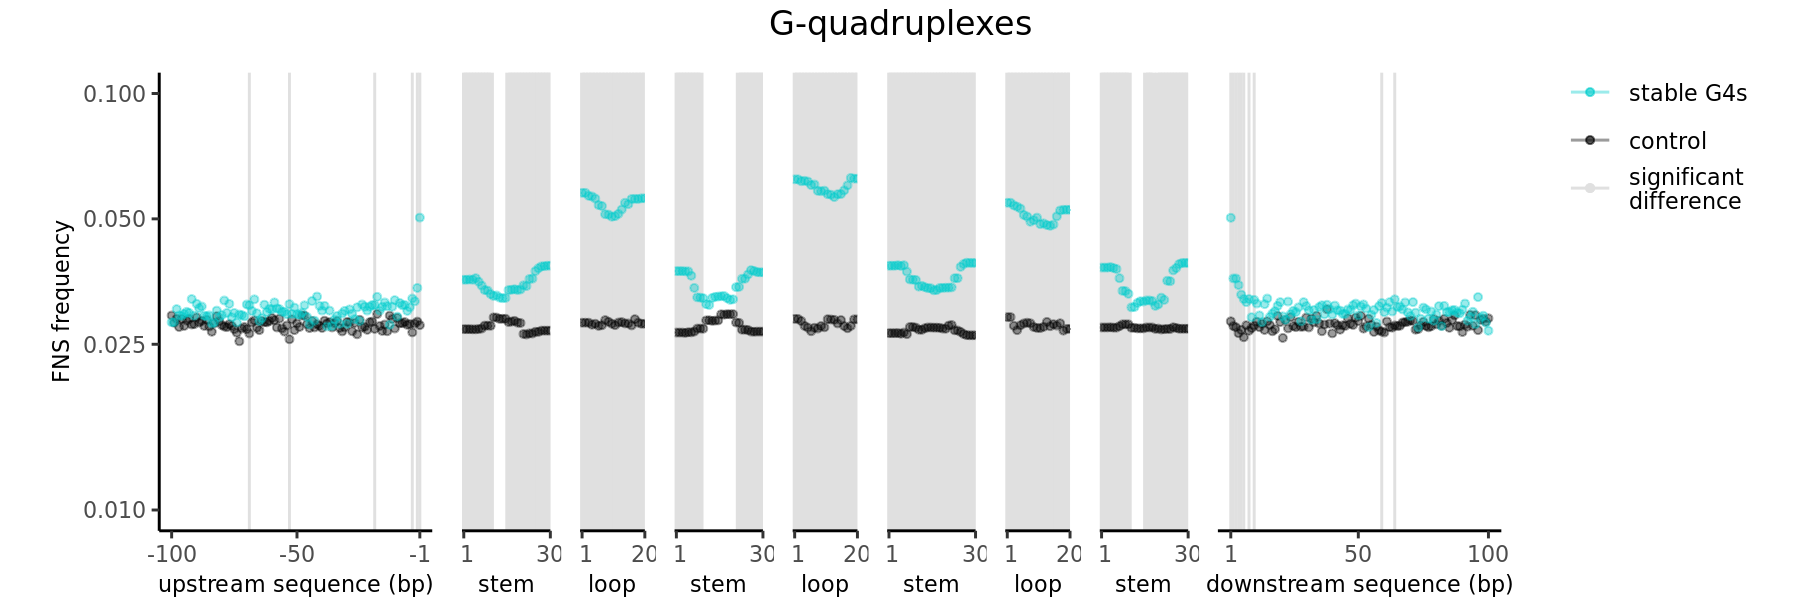

In [424]:
%%R -w 9 -h 3 --units in -r 200

csvfile <- read.csv('NCNRQuadron.high.divergence.intersect.csv', header = TRUE)
csvfile <- csvfile[which(csvfile$snp_start != "NA"),]

LeftFlank <- table(csvfile[which(csvfile$snp_pos == "flank1"),10])/20156 
stem1 <- table(csvfile[which(csvfile$snp_pos == "stem1"),10])/20156 
loop1 <- table(csvfile[which(csvfile$snp_pos == "loop1"),10])/20156 
stem2 <- table(csvfile[which(csvfile$snp_pos == "stem2"),10])/20156 
loop2 <- table(csvfile[which(csvfile$snp_pos == "loop2"),10])/20156 
stem3 <- table(csvfile[which(csvfile$snp_pos == "stem3"),10])/20156 
loop3 <- table(csvfile[which(csvfile$snp_pos == "loop3"),10])/20156 
stem4 <- table(csvfile[which(csvfile$snp_pos == "stem4"),10])/20156 
RightFlank <- table(csvfile[which(csvfile$snp_pos == "flank2"),10])/20156 


c_csvfile <- read.csv('NCNRQuadron.ctrl.divergence.intersect.csv', header = TRUE)
c_csvfile <- c_csvfile[which(c_csvfile$snp_start != "NA"),]

c_LeftFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "flank1"),10])/42104
c_stem1 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem1"),10])/42104
c_loop1 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop1"),10])/42104
c_stem2 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem2"),10])/42104
c_loop2 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop2"),10])/42104
c_stem3 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem3"),10])/42104
c_loop3 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop3"),10])/42104
c_stem4 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem4"),10])/42104
c_RightFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "flank2"),10])/42104


cols <- c("non-B DNA"=rgb(t(col2rgb('cyan3')), alpha=100, maxColorValue = 255),
          "significant\ndifference"="grey88",
          "control"=rgb(t(col2rgb('black')), alpha=100, maxColorValue = 255))

load('Quadron.high.divergence_motif_vs_control_IWTomics_center_0.01.RData')
load('Quadron.high.divergence_motif_vs_control_IWTomics_left_0.01.RData')
load('Quadron.high.divergence_motif_vs_control_IWTomics_right_0.01.RData')

LeftFlankDf <- cbind.data.frame(LeftFlank,c_LeftFlank,adj_pvalue_curve_left$significant)[,c(1,2,4,5)]
names(LeftFlankDf) <- c('Levels','Freq','C_Freq','Signif')
LeftFlankDf$Levels <- as.numeric(as.character(LeftFlankDf$Levels))
LeftFlankDf_cut <- LeftFlankDf[which(LeftFlankDf$Levels >= -100),]
LeftFlankDf_cut$Levels <- seq(-100,-1,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem1'),"significant"]
stem1Df <- cbind.data.frame(stem1,c_stem1,Signif)[,c(1,2,4,5)]
names(stem1Df) <- c('Levels','Freq','C_Freq','Signif')
stem1Df$Levels <- seq(1,30,1)


Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop1'),"significant"]
loop1Df <- cbind.data.frame(loop1,c_loop1,Signif)[,c(1,2,4,5)]
names(loop1Df) <- c('Levels','Freq','C_Freq','Signif')
loop1Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem2'),"significant"]
stem2Df <- cbind.data.frame(stem2,c_stem2,Signif)[,c(1,2,4,5)]
names(stem2Df) <- c('Levels','Freq','C_Freq','Signif')
stem2Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop2'),"significant"]
loop2Df <- cbind.data.frame(loop2,c_loop2,Signif)[,c(1,2,4,5)]
names(loop2Df) <- c('Levels','Freq','C_Freq','Signif')
loop2Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem3'),"significant"]
stem3Df <- cbind.data.frame(stem3,c_stem3,Signif)[,c(1,2,4,5)]
names(stem3Df) <- c('Levels','Freq','C_Freq','Signif')
stem3Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop3'),"significant"]
loop3Df <- cbind.data.frame(loop3,c_loop3,Signif)[,c(1,2,4,5)]
names(loop3Df) <- c('Levels','Freq','C_Freq','Signif')
loop3Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem4'),"significant"]
stem4Df <- cbind.data.frame(stem4,c_stem4,Signif)[,c(1,2,4,5)]
names(stem4Df) <- c('Levels','Freq','C_Freq','Signif')
stem4Df$Levels <- seq(1,30,1)


RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant)[,c(1,2,4,5)]
names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif')
RightFlankDf$Levels <- as.numeric(as.character(RightFlankDf$Levels))
RightFlankDf_cut <- RightFlankDf[which(RightFlankDf$Levels <= 100),]
RightFlankDf_cut$Levels <- seq(1,100,1)

p1 <- ggplot(LeftFlankDf_cut, aes(x=Levels)) + 
        geom_vline(xintercept= LeftFlankDf_cut[which(LeftFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.title = element_text(size=8,family="sans"),
            axis.text.x = element_text(size=8,family="sans"),
            axis.text.y = element_text(size=8,family="sans")) +
        labs(y="FNS frequency", x="upstream sequence (bp)", size=8, family='sans') +
        scale_colour_manual(name="",values=cols) +
        scale_x_continuous(breaks =  c(-100,-50,-1), limits = c(-100,-1)) +
        theme(plot.margin = unit(c(10,4,1,1), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1), breaks = c(0.010,0.025,0.050,0.100) )


p2 <- ggplot(stem1Df,  aes(x=Levels)) +
       geom_vline(xintercept= stem1Df[which(stem1Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))



p3 <- ggplot(loop1Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop1Df[which(loop1Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() +  
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p4 <- ggplot(stem2Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem2Df[which(stem2Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p5 <- ggplot(loop2Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop2Df[which(loop2Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() +
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p6 <- ggplot(stem3Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem3Df[which(stem3Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p7 <- ggplot(loop3Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop3Df[which(loop3Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p8 <- ggplot(stem4Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem4Df[which(stem4Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p9 <- ggplot(RightFlankDf_cut, aes(x=Levels)) + 
        geom_line(aes(x=0,y=0,colour="significant\ndifference")) +
        geom_vline(xintercept= RightFlankDf_cut[which(RightFlankDf_cut$Signif == "TRUE"),"Levels"], col='gray88') +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() +
        theme(axis.title.y=element_blank(),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.x = element_text(size=8,family="sans"),
            legend.position=c(1.55, 0.9),
            legend.text=element_text(size=8,family="sans")) +
        labs(x="downstream sequence (bp)")+
        scale_colour_manual(name="",values=cols,
                            breaks = c('non-B DNA', 'control', 'significant\ndifference'),
                           labels = c('stable G4s', 'control', 'significant\ndifference')) +
        scale_x_continuous(breaks = c(1,50,100), limits = c(1,100)) +
        theme(plot.margin = unit(c(10,90,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1)) +
        guides(shape = guide_legend(order = 3))


grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol=9, 
            widths=unit(c(50,15,12,15,12,15,12,15,70), c("mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("G-quadruplexes",gp=gpar(fontsize=12,family="sans")))

g <- arrangeGrob(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol=9, 
            widths=unit(c(50,15,12,15,12,15,12,15,70), c("mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("G-quadruplexes",gp=gpar(fontsize=12,family="sans")))

ggsave(file='QuadronHighDivergence.pdf',g, width=9, height=3, dpi=300)



In [416]:
%%R
min(adj_pvalue_curve_left[which(adj_pvalue_curve_left$significant == "TRUE"),"snp_coord"])


[1] -1956


In [417]:
%%R
max(adj_pvalue_curve_right[which(adj_pvalue_curve_right$significant == "TRUE"),"snp_coord"])


[1] 1828


In [418]:
%%R
flanks <- rbind(LeftFlankDf,RightFlankDf)
print(max(flanks$Freq/flanks$C_Freq))

[1] 1.812171


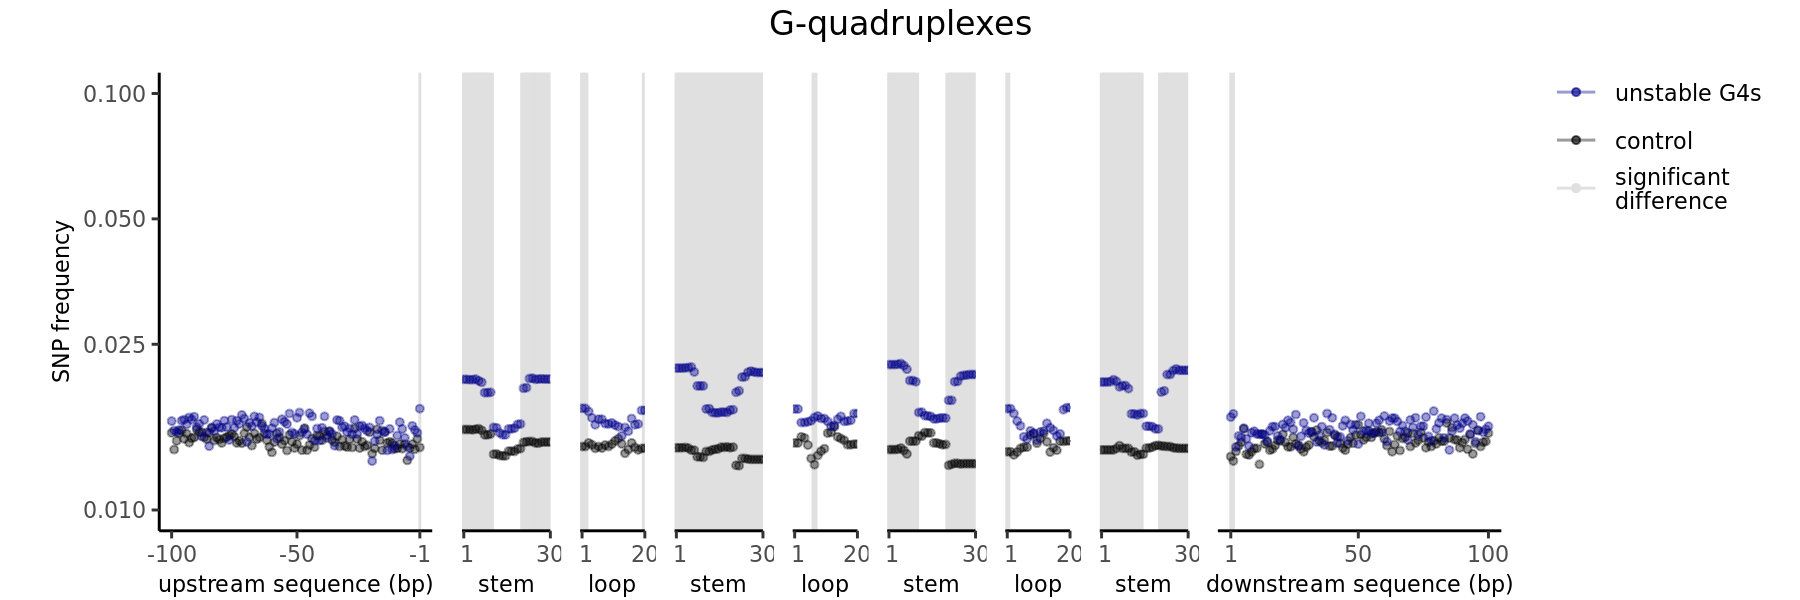

In [425]:
%%R -w 9 -h 3 --units in -r 200

csvfile <- read.csv('NCNRQuadron.low.SGDP.intersect.csv', header = TRUE)
csvfile <- csvfile[which(csvfile$snp_start != "NA"),]

LeftFlank <- table(csvfile[which(csvfile$snp_pos == "flank1"),10])/30212 
stem1 <- table(csvfile[which(csvfile$snp_pos == "stem1"),10])/30212 
loop1 <- table(csvfile[which(csvfile$snp_pos == "loop1"),10])/30212 
stem2 <- table(csvfile[which(csvfile$snp_pos == "stem2"),10])/30212 
loop2 <- table(csvfile[which(csvfile$snp_pos == "loop2"),10])/30212 
stem3 <- table(csvfile[which(csvfile$snp_pos == "stem3"),10])/30212 
loop3 <- table(csvfile[which(csvfile$snp_pos == "loop3"),10])/30212 
stem4 <- table(csvfile[which(csvfile$snp_pos == "stem4"),10])/30212 
RightFlank <- table(csvfile[which(csvfile$snp_pos == "flank2"),10])/30212 


c_csvfile <- read.csv('NCNRQuadron.ctrl.SGDP.intersect.csv', header = TRUE)
c_csvfile <- c_csvfile[which(c_csvfile$snp_start != "NA"),]

c_LeftFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "flank1"),10])/42104
c_stem1 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem1"),10])/42104
c_loop1 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop1"),10])/42104
c_stem2 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem2"),10])/42104
c_loop2 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop2"),10])/42104
c_stem3 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem3"),10])/42104
c_loop3 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop3"),10])/42104
c_stem4 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem4"),10])/42104
c_RightFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "flank2"),10])/42104


cols <- c("non-B DNA"=rgb(t(col2rgb('blue4')), alpha=100, maxColorValue = 255),
          "significant\ndifference"="grey88",
          "control"=rgb(t(col2rgb('black')), alpha=100, maxColorValue = 255))

load('Quadron.low.SGDP_motif_vs_control_IWTomics_center_0.01.RData')
load('Quadron.low.SGDP_motif_vs_control_IWTomics_left_0.01.RData')
load('Quadron.low.SGDP_motif_vs_control_IWTomics_right_0.01.RData')

LeftFlankDf <- cbind.data.frame(LeftFlank,c_LeftFlank,adj_pvalue_curve_left$significant)[,c(1,2,4,5)]
names(LeftFlankDf) <- c('Levels','Freq','C_Freq','Signif')
LeftFlankDf$Levels <- as.numeric(as.character(LeftFlankDf$Levels))
LeftFlankDf_cut <- LeftFlankDf[which(LeftFlankDf$Levels >= -100),]
LeftFlankDf_cut$Levels <- seq(-100,-1,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem1'),"significant"]
stem1Df <- cbind.data.frame(stem1,c_stem1,Signif)[,c(1,2,4,5)]
names(stem1Df) <- c('Levels','Freq','C_Freq','Signif')
stem1Df$Levels <- seq(1,30,1)


Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop1'),"significant"]
loop1Df <- cbind.data.frame(loop1,c_loop1,Signif)[,c(1,2,4,5)]
names(loop1Df) <- c('Levels','Freq','C_Freq','Signif')
loop1Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem2'),"significant"]
stem2Df <- cbind.data.frame(stem2,c_stem2,Signif)[,c(1,2,4,5)]
names(stem2Df) <- c('Levels','Freq','C_Freq','Signif')
stem2Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop2'),"significant"]
loop2Df <- cbind.data.frame(loop2,c_loop2,Signif)[,c(1,2,4,5)]
names(loop2Df) <- c('Levels','Freq','C_Freq','Signif')
loop2Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem3'),"significant"]
stem3Df <- cbind.data.frame(stem3,c_stem3,Signif)[,c(1,2,4,5)]
names(stem3Df) <- c('Levels','Freq','C_Freq','Signif')
stem3Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop3'),"significant"]
loop3Df <- cbind.data.frame(loop3,c_loop3,Signif)[,c(1,2,4,5)]
names(loop3Df) <- c('Levels','Freq','C_Freq','Signif')
loop3Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem4'),"significant"]
stem4Df <- cbind.data.frame(stem4,c_stem4,Signif)[,c(1,2,4,5)]
names(stem4Df) <- c('Levels','Freq','C_Freq','Signif')
stem4Df$Levels <- seq(1,30,1)


RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant)[,c(1,2,4,5)]
names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif')
RightFlankDf$Levels <- as.numeric(as.character(RightFlankDf$Levels))
RightFlankDf_cut <- RightFlankDf[which(RightFlankDf$Levels <= 100),]
RightFlankDf_cut$Levels <- seq(1,100,1)

p1 <- ggplot(LeftFlankDf_cut, aes(x=Levels)) + 
        geom_vline(xintercept= LeftFlankDf_cut[which(LeftFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.title = element_text(size=8,family="sans"),
            axis.text.x = element_text(size=8,family="sans"),
            axis.text.y = element_text(size=8,family="sans")) +
        labs(y="SNP frequency", x="upstream sequence (bp)", size=8, family='sans') +
        scale_colour_manual(name="",values=cols) +
        scale_x_continuous(breaks =  c(-100,-50,-1), limits = c(-100,-1)) +
        theme(plot.margin = unit(c(10,4,1,1), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1), breaks = c(0.010,0.025,0.050,0.100) )


p2 <- ggplot(stem1Df,  aes(x=Levels)) +
       geom_vline(xintercept= stem1Df[which(stem1Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))



p3 <- ggplot(loop1Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop1Df[which(loop1Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() +  
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p4 <- ggplot(stem2Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem2Df[which(stem2Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p5 <- ggplot(loop2Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop2Df[which(loop2Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() +
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p6 <- ggplot(stem3Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem3Df[which(stem3Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p7 <- ggplot(loop3Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop3Df[which(loop3Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p8 <- ggplot(stem4Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem4Df[which(stem4Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p9 <- ggplot(RightFlankDf_cut, aes(x=Levels)) + 
        geom_line(aes(x=0,y=0,colour="significant\ndifference")) +
        geom_vline(xintercept= RightFlankDf_cut[which(RightFlankDf_cut$Signif == "TRUE"),"Levels"], col='gray88') +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() +
        theme(axis.title.y=element_blank(),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.x = element_text(size=8,family="sans"),
            legend.position=c(1.55, 0.9),
            legend.text=element_text(size=8,family="sans")) +
        labs(x="downstream sequence (bp)")+
        scale_colour_manual(name="",values=cols,
                            breaks = c('non-B DNA', 'control', 'significant\ndifference'),
                           labels = c('unstable G4s', 'control', 'significant\ndifference')) +
        scale_x_continuous(breaks = c(1,50,100), limits = c(1,100)) +
        theme(plot.margin = unit(c(10,90,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1)) +
        guides(shape = guide_legend(order = 3))

grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol=9, 
            widths=unit(c(50,15,12,15,12,15,12,15,70), c("mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("G-quadruplexes",gp=gpar(fontsize=12,family="sans")))

g <- arrangeGrob(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol=9, 
            widths=unit(c(50,15,12,15,12,15,12,15,70), c("mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("G-quadruplexes",gp=gpar(fontsize=12,family="sans")))

ggsave(file='QuadronLowSNP.pdf',g, width=9, height=3, dpi=300)


In [420]:
%%R
min(adj_pvalue_curve_left[which(adj_pvalue_curve_left$significant == "TRUE"),"snp_coord"])


[1] -1504


In [421]:
%%R
max(adj_pvalue_curve_right[which(adj_pvalue_curve_right$significant == "TRUE"),"snp_coord"])


[1] 1546


In [422]:
%%R
flanks <- rbind(LeftFlankDf,RightFlankDf)
print(max(flanks$Freq/flanks$C_Freq))

[1] 1.297681


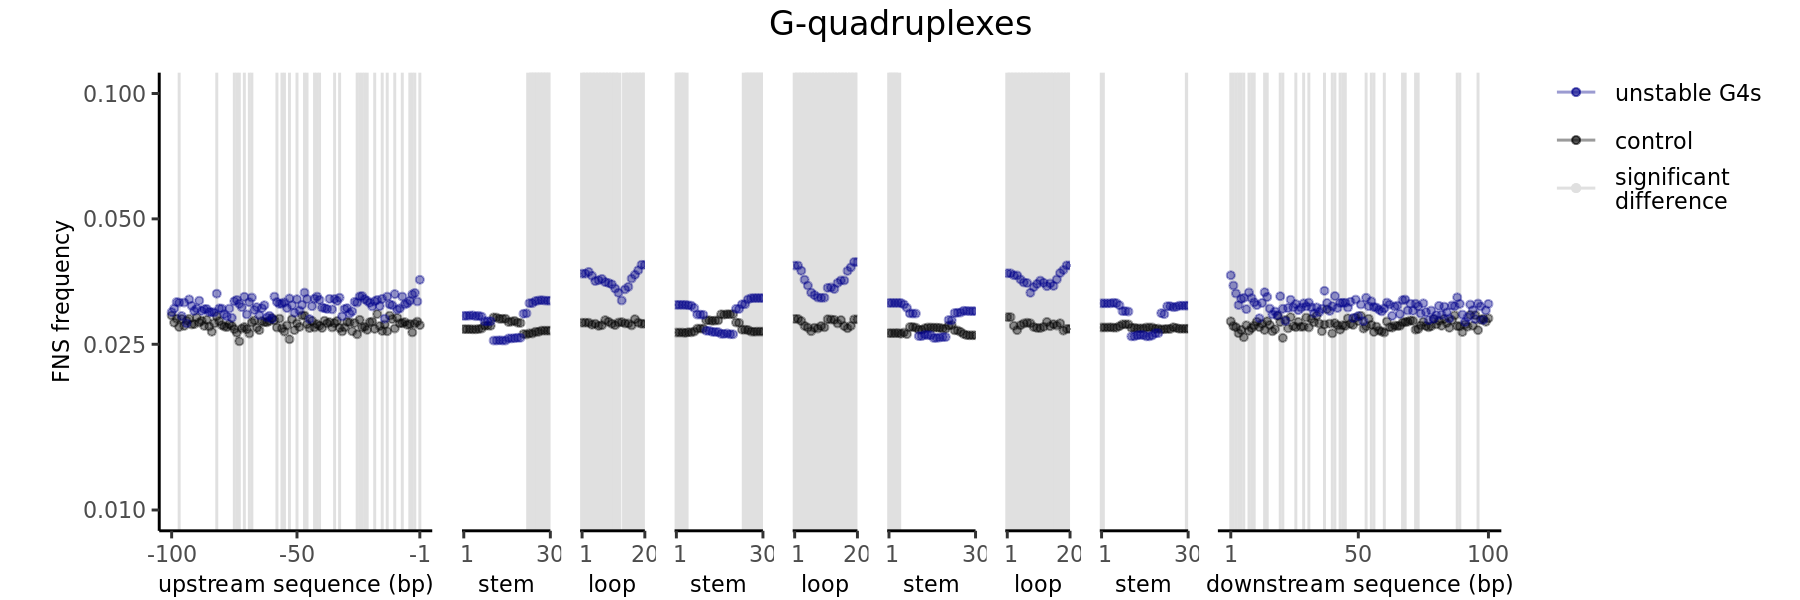

In [426]:
%%R -w 9 -h 3 --units in -r 200

csvfile <- read.csv('NCNRQuadron.low.divergence.intersect.csv', header = TRUE)
csvfile <- csvfile[which(csvfile$snp_start != "NA"),]

LeftFlank <- table(csvfile[which(csvfile$snp_pos == "flank1"),10])/30212 
stem1 <- table(csvfile[which(csvfile$snp_pos == "stem1"),10])/30212 
loop1 <- table(csvfile[which(csvfile$snp_pos == "loop1"),10])/30212 
stem2 <- table(csvfile[which(csvfile$snp_pos == "stem2"),10])/30212 
loop2 <- table(csvfile[which(csvfile$snp_pos == "loop2"),10])/30212 
stem3 <- table(csvfile[which(csvfile$snp_pos == "stem3"),10])/30212 
loop3 <- table(csvfile[which(csvfile$snp_pos == "loop3"),10])/30212 
stem4 <- table(csvfile[which(csvfile$snp_pos == "stem4"),10])/30212 
RightFlank <- table(csvfile[which(csvfile$snp_pos == "flank2"),10])/30212 


c_csvfile <- read.csv('NCNRQuadron.ctrl.divergence.intersect.csv', header = TRUE)
c_csvfile <- c_csvfile[which(c_csvfile$snp_start != "NA"),]

c_LeftFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "flank1"),10])/42104
c_stem1 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem1"),10])/42104
c_loop1 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop1"),10])/42104
c_stem2 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem2"),10])/42104
c_loop2 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop2"),10])/42104
c_stem3 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem3"),10])/42104
c_loop3 <- table(c_csvfile[which(c_csvfile$snp_pos == "loop3"),10])/42104
c_stem4 <- table(c_csvfile[which(c_csvfile$snp_pos == "stem4"),10])/42104
c_RightFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "flank2"),10])/42104


cols <- c("non-B DNA"=rgb(t(col2rgb('blue4')), alpha=100, maxColorValue = 255),
          "significant\ndifference"="grey88",
          "control"=rgb(t(col2rgb('black')), alpha=100, maxColorValue = 255))

load('Quadron.low.divergence_motif_vs_control_IWTomics_center_0.01.RData')
load('Quadron.low.divergence_motif_vs_control_IWTomics_left_0.01.RData')
load('Quadron.low.divergence_motif_vs_control_IWTomics_right_0.01.RData')

LeftFlankDf <- cbind.data.frame(LeftFlank,c_LeftFlank,adj_pvalue_curve_left$significant)[,c(1,2,4,5)]
names(LeftFlankDf) <- c('Levels','Freq','C_Freq','Signif')
LeftFlankDf$Levels <- as.numeric(as.character(LeftFlankDf$Levels))
LeftFlankDf_cut <- LeftFlankDf[which(LeftFlankDf$Levels >= -100),]
LeftFlankDf_cut$Levels <- seq(-100,-1,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem1'),"significant"]
stem1Df <- cbind.data.frame(stem1,c_stem1,Signif)[,c(1,2,4,5)]
names(stem1Df) <- c('Levels','Freq','C_Freq','Signif')
stem1Df$Levels <- seq(1,30,1)


Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop1'),"significant"]
loop1Df <- cbind.data.frame(loop1,c_loop1,Signif)[,c(1,2,4,5)]
names(loop1Df) <- c('Levels','Freq','C_Freq','Signif')
loop1Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem2'),"significant"]
stem2Df <- cbind.data.frame(stem2,c_stem2,Signif)[,c(1,2,4,5)]
names(stem2Df) <- c('Levels','Freq','C_Freq','Signif')
stem2Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop2'),"significant"]
loop2Df <- cbind.data.frame(loop2,c_loop2,Signif)[,c(1,2,4,5)]
names(loop2Df) <- c('Levels','Freq','C_Freq','Signif')
loop2Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem3'),"significant"]
stem3Df <- cbind.data.frame(stem3,c_stem3,Signif)[,c(1,2,4,5)]
names(stem3Df) <- c('Levels','Freq','C_Freq','Signif')
stem3Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'loop3'),"significant"]
loop3Df <- cbind.data.frame(loop3,c_loop3,Signif)[,c(1,2,4,5)]
names(loop3Df) <- c('Levels','Freq','C_Freq','Signif')
loop3Df$Levels <- seq(1,20,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'stem4'),"significant"]
stem4Df <- cbind.data.frame(stem4,c_stem4,Signif)[,c(1,2,4,5)]
names(stem4Df) <- c('Levels','Freq','C_Freq','Signif')
stem4Df$Levels <- seq(1,30,1)


RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant)[,c(1,2,4,5)]
names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif')
RightFlankDf$Levels <- as.numeric(as.character(RightFlankDf$Levels))
RightFlankDf_cut <- RightFlankDf[which(RightFlankDf$Levels <= 100),]
RightFlankDf_cut$Levels <- seq(1,100,1)

p1 <- ggplot(LeftFlankDf_cut, aes(x=Levels)) + 
        geom_vline(xintercept= LeftFlankDf_cut[which(LeftFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.title = element_text(size=8,family="sans"),
            axis.text.x = element_text(size=8,family="sans"),
            axis.text.y = element_text(size=8,family="sans")) +
        labs(y="FNS frequency", x="upstream sequence (bp)", size=8, family='sans') +
        scale_colour_manual(name="",values=cols) +
        scale_x_continuous(breaks =  c(-100,-50,-1), limits = c(-100,-1)) +
        theme(plot.margin = unit(c(10,4,1,1), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1), breaks = c(0.010,0.025,0.050,0.100) )


p2 <- ggplot(stem1Df,  aes(x=Levels)) +
       geom_vline(xintercept= stem1Df[which(stem1Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))



p3 <- ggplot(loop1Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop1Df[which(loop1Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() +  
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p4 <- ggplot(stem2Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem2Df[which(stem2Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p5 <- ggplot(loop2Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop2Df[which(loop2Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() +
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p6 <- ggplot(stem3Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem3Df[which(stem3Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p7 <- ggplot(loop3Df,  aes(x=Levels)) + 
        geom_vline(xintercept= loop3Df[which(loop3Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="loop") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 20), limits = c(1, 20)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p8 <- ggplot(stem4Df,  aes(x=Levels)) + 
        geom_vline(xintercept= stem4Df[which(stem4Df$Signif == "TRUE"),"Levels"], col="gray88", size = 1.1) +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() + 
        theme(legend.position="none",
            axis.text.x = element_text(size=8,family="sans"),
            axis.title.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank()) +
        labs(x="stem") +
        scale_colour_manual(name="",values=cols) +
        scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
        theme(plot.margin = unit(c(10,4,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1))


p9 <- ggplot(RightFlankDf_cut, aes(x=Levels)) + 
        geom_line(aes(x=0,y=0,colour="significant\ndifference")) +
        geom_vline(xintercept= RightFlankDf_cut[which(RightFlankDf_cut$Signif == "TRUE"),"Levels"], col='gray88') +
        geom_point(aes(y=C_Freq,col="control"), size = 1) +
        geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
        theme_classic() +
        theme(axis.title.y=element_blank(),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank(),
            axis.title.x = element_text(size=8,family="sans"),
            axis.text.x = element_text(size=8,family="sans"),
            legend.position=c(1.55, 0.9),
            legend.text=element_text(size=8,family="sans")) +
        labs(x="downstream sequence (bp)")+
        scale_colour_manual(name="",values=cols,
                            breaks = c('non-B DNA', 'control', 'significant\ndifference'),
                           labels = c('unstable G4s', 'control', 'significant\ndifference')) +
        scale_x_continuous(breaks = c(1,50,100), limits = c(1,100)) +
        theme(plot.margin = unit(c(10,90,1,4), "pt")) +
        scale_y_continuous(trans='log', limits = c(0.01,0.1)) +
        guides(shape = guide_legend(order = 3))

grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol=9, 
            widths=unit(c(50,15,12,15,12,15,12,15,70), c("mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("G-quadruplexes",gp=gpar(fontsize=12,family="sans")))

g <- arrangeGrob(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol=9, 
            widths=unit(c(50,15,12,15,12,15,12,15,70), c("mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("G-quadruplexes",gp=gpar(fontsize=12,family="sans")))

ggsave(file='QuadronLowDivergence.pdf',g, width=9, height=3, dpi=300)


In [424]:
%%R
min(adj_pvalue_curve_left[which(adj_pvalue_curve_left$significant == "TRUE"),"snp_coord"])


[1] -1679


In [425]:
%%R
max(adj_pvalue_curve_right[which(adj_pvalue_curve_right$significant == "TRUE"),"snp_coord"])


[1] 1983


In [426]:
%%R
flanks <- rbind(LeftFlankDf,RightFlankDf)
print(max(flanks$Freq/flanks$C_Freq))

[1] 1.289826


## 1.8 Permuting tests and controls

In [ ]:
#Permuting.py

import sys
import random
from collections import Counter
import pandas as pd

def extract_pos(infile): # this extract all snps in different \
                        #sections of a same non-B DNA loci
    infile.readline() #skip first line
    loci = {}
    last_pos = ''
    for line in infile:
        array = line.strip().split(',')
      
        if len(array) == 12: # G4s have one more columns, snp_pos is the section, snp_distance is the scaled position
            chrom, start, end, snp_pos, snpdistance = array[1], array[2], array[3], array[8], array[9]
        elif len(array) == 11:
            chrom, start, end, snp_pos, snpdistance = array[1], array[2], array[3], array[7], array[8]            
        else:
            print('Array length error')
        
        #next we group all SNPs that came from the same non-B locus
        if snp_pos == 'flank1' or snp_pos == 'LeftFlank':
            if last_pos == 'flank2' or last_pos == 'RightFlank':#should always be the start of a locus but the first one
                locus = chrom+"|"+start+"|"+end
                loci[locus] = locus_array
                
                locus_start = start
                locus_array = []
                if snpdistance!= 'NA':
                    locus_array.append(snp_pos+'|'+snpdistance)
                
            elif last_pos == '':#first start
                locus_start = start
                locus_array = []
                if snpdistance!= 'NA':
                    locus_array.append(snp_pos+'|'+snpdistance)  
                
            else:
                if snpdistance!= 'NA':
                    locus_array.append(snp_pos+'|'+snpdistance)
        else:
            if snpdistance!= 'NA':
                locus_array.append(snp_pos+'|'+snpdistance)
            locus_end = end
            
        last_pos = snp_pos
            
    locus = chrom+"|"+start+"|"+end #last iteration
    loci[locus] = locus_array #last iteration
    return(loci)

def count_freqs(loci, denominator, optional_denominator):
    
    subparts = {}
    for locus in loci:

        
        for snp in locus:        
            snp_pos, snp_coord = snp.split('|')
            if snp_pos in subparts:
                subparts[snp_pos].append(snp_coord)
            else:
                subparts[snp_pos] = [snp_coord]
            
    rows = []
    for subpart in subparts:
        freq = Counter(subparts[subpart])
        for value in freq.items():
            snp_coord, count = value
            if subpart == 'Spacer':
                freq = float(count) / optional_denominator
            else:
                freq = float(count) / denominator
            
            rows.append([subpart, float(snp_coord), freq])
        
    return(rows)
    

colnames = ['subpart','snp_coord','freq']

pool = []

infile = open(sys.argv[1], 'rt')
loci_dict = extract_pos(infile)
loci = []


for locus in loci_dict:
    pool.append(loci_dict[locus])
    loci.append(loci_dict[locus])
    
first_col = count_freqs(loci, int(sys.argv[3]), int(sys.argv[4]))
loci_df = pd.DataFrame(data=first_col, columns=colnames)


infile = open(sys.argv[2], 'rt')
ctrl_loci_dict = extract_pos(infile)
ctrl_loci = []

for locus in ctrl_loci_dict:
    pool.append(ctrl_loci_dict[locus])
    ctrl_loci.append(ctrl_loci_dict[locus])

first_ctrl_col = count_freqs(ctrl_loci, int(sys.argv[5]), int(sys.argv[6]))    
ctrl_loci_df = pd.DataFrame(data=first_ctrl_col, columns=colnames)



permutation = 1
while permutation <= 1000:
    colnames = ['subpart','snp_coord', 'freq '+str(permutation)]

    random.shuffle(pool)
    random_loci = pool[:int(sys.argv[3])]
    random_ctrl_loci = pool[int(sys.argv[3]):]
    
    
    new_col = count_freqs(random_loci, int(sys.argv[3]), int(sys.argv[4]))
    new_ctrl_col = count_freqs(random_ctrl_loci, int(sys.argv[5]), int(sys.argv[6]))
    new_df = pd.DataFrame(data=new_col, columns=colnames)
    new_ctrl_df = pd.DataFrame(data=new_ctrl_col, columns=colnames)

    loci_df = pd.merge(loci_df, new_df, how='outer', on=['subpart','snp_coord'])
    ctrl_loci_df = pd.merge(ctrl_loci_df, new_ctrl_df, how='outer', on=['subpart','snp_coord'])

    permutation += 1



pd.DataFrame.to_csv(loci_df, sys.argv[7])  
pd.DataFrame.to_csv(ctrl_loci_df, sys.argv[8])  


```
python Permuting.py NCNRQuadron.SGDP.intersect.csv NCNRQuadron.ctrl.SGDP.intersect.csv 50345 0 42104 0 NCNRQuadron.SGDP.permuted NCNRQuadron.ctrl.SGDP.permuted
python Permuting.py NCNRQuadron.divergence.intersect.csv NCNRQuadron.ctrl.divergence.intersect.csv 50345 0 42104 0 NCNRQuadron.divergence.permuted NCNRQuadron.ctrl.divergence.permuted


python Permuting.py NCNRQuadron.high.SGDP.intersect.csv NCNRQuadron.ctrl.SGDP.intersect.csv 20156 0 42104 0 NCNRQuadron.high.SGDP.permuted NCNRQuadron.high.ctrl.SGDP.permuted
python Permuting.py NCNRQuadron.low.SGDP.intersect.csv NCNRQuadron.ctrl.SGDP.intersect.csv 30212 0 42104 0 NCNRQuadron.low.SGDP.permuted NCNRQuadron.low.ctrl.SGDP.permuted
python Permuting.py NCNRQuadron.high.SGDP.intersect.csv NCNRQuadron.low.SGDP.intersect.csv 20156 0 30212 0 NCNRQuadron.highVlow.SGDP.permuted NCNRQuadron.lowVhigh.SGDP.permuted

python Permuting.py NCNRQuadron.high.divergence.intersect.csv NCNRQuadron.ctrl.divergence.intersect.csv 20156 0 42104 0 NCNRQuadron.high.divergence.permuted NCNRQuadron.high.ctrl.divergence.permuted
python Permuting.py NCNRQuadron.low.divergence.intersect.csv NCNRQuadron.ctrl.divergence.intersect.csv 30212 0 42104 0 NCNRQuadron.low.divergence.permuted NCNRQuadron.low.ctrl.divergence.permuted
python Permuting.py NCNRQuadron.high.divergence.intersect.csv NCNRQuadron.low.divergence.intersect.csv 20156 0 30212 0 NCNRQuadron.highVlow.divergence.permuted NCNRQuadron.lowVhigh.divergence.permuted

```

## 1.9 Frequencies of substitution types

In [58]:
%%bash
# List SNPs at positions of interest and adjust coordinates for trinucleotide context
awk '{if ($5=="+") print $0 }' NCNRQuadron.nooverlap.bed | awk 'BEGIN {OFS="\t"} {print $1, $6-2, $6+1}' | awk '{if ($2>0) print $0}'> NCNRQuadron.trinucl.left.bed
awk '{if ($5=="+") print $0 }' NCNRQuadron.high.nooverlap.bed | awk 'BEGIN {OFS="\t"} {print $1, $6-2, $6+1}' | awk '{if ($2>0) print $0}'> NCNRQuadron.high.trinucl.left.bed
awk '{if ($5=="+") print $0 }' NCNRQuadron.low.nooverlap.bed | awk 'BEGIN {OFS="\t"} {print $1, $6-2, $6+1}' | awk '{if ($2>0) print $0}'> NCNRQuadron.low.trinucl.left.bed
awk '{if ($5=="+") print $0 }' NCNRQuadron.ctrl.nooverlap.bed | awk 'BEGIN {OFS="\t"} {print $1, $6-2, $6+1}' | awk '{if ($2>0) print $0}'> NCNRQuadron.ctrl.trinucl.left.bed

awk '{if ($5=="+") print $0 }' NCNRQuadron.nooverlap.bed |awk 'BEGIN {OFS="\t"} {print $1, $7-1, $7+2}' > NCNRQuadron.trinucl.right.bed
awk '{if ($5=="+") print $0 }' NCNRQuadron.high.nooverlap.bed |awk 'BEGIN {OFS="\t"} {print $1, $7-1, $7+2}' > NCNRQuadron.high.trinucl.right.bed
awk '{if ($5=="+") print $0 }' NCNRQuadron.low.nooverlap.bed |awk 'BEGIN {OFS="\t"} {print $1, $7-1, $7+2}' > NCNRQuadron.low.trinucl.right.bed
awk '{if ($5=="+") print $0 }' NCNRQuadron.ctrl.nooverlap.bed |awk 'BEGIN {OFS="\t"} {print $1, $7-1, $7+2}' > NCNRQuadron.ctrl.trinucl.right.bed


Extract the trinucleotide context
```
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRQuadron.high.trinucl.left.bed > NCNRQuadron.high.trinucl.left.fa
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRQuadron.low.trinucl.left.bed > NCNRQuadron.low.trinucl.left.fa
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRQuadron.ctrl.trinucl.left.bed > NCNRQuadron.ctrl.trinucl.left.fa

bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRQuadron.high.trinucl.right.bed > NCNRQuadron.high.trinucl.right.fa
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRQuadron.low.trinucl.right.bed > NCNRQuadron.low.trinucl.right.fa
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRQuadron.ctrl.trinucl.right.bed > NCNRQuadron.ctrl.trinucl.right.fa
```

In [56]:
# Store all SGDP SNPs in a dictionnary with coordinates as key

snpfile = open('../SGDP/WholeSGDPsnps.bed', 'rt')

snpdict = {}

for snp in snpfile:
    snp = snp.strip().split('\t')
    chrom, start, end, ref, alt = snp[0:5]
    snpdict[chrom+'|'+start+'|'+end] = [ref, alt]

In [57]:
# Computes the substitution rates with trinucleotide context for a certain substitution type

import re

def trinucl_subrate(snps, motifsequences):
    
    # First we create the data structure. All the possible trinucleotides will be given a count and an array.
    nucleotides = ['A','T','G','C','N']
    trinucleotides = []
    for x in nucleotides:
        for y in nucleotides:
            for z in nucleotides:
                trinucleotides.append(x+y+z)
    trinucleotidesdict = {}
    for trinucleotide in trinucleotides:
        trinucleotidesdict[trinucleotide] = [0,[]]

    # Then we count the trinucleotides occcurences and find if they match with SNPs.
    for motifsequence in motifsequences:
        motifsequence = motifsequence.strip()
        if motifsequence[0] == '>':
            chrom, start, end = re.split('[:,\-]',motifsequence[1:])
            start = int(start)
            end = int(end)
        else:
            motifsequence = motifsequence.replace('a', 'A')
            motifsequence = motifsequence.replace('t', 'T')
            motifsequence = motifsequence.replace('c', 'C')
            motifsequence = motifsequence.replace('g', 'G')
            motifsequence = motifsequence.replace('n', 'N')
            for i in range(1, len(motifsequence)-1):
                trinucl = motifsequence[i-1]+motifsequence[i]+motifsequence[i+1]
                pos = start + i
                key = chrom+'|'+str(pos)+'|'+str(pos+1)
                trinucleotidesdict[trinucl][0] += 1
                if key in snpdict:
                    trinucleotidesdict[trinucl][1].append(snpdict[key])

    # Then we count how many times a substitution type occurs for each trinucleotide and derive the rates.
    subrates = {}
    for trinucleotide in trinucleotidesdict:
        count, snps = trinucleotidesdict[trinucleotide]
        subs = [0,0,0,0,0] # A, T, G, C, N
        for snp in snps:
            ref, alt = snp
            if ref != trinucleotide[1]:
                print('ERROR: snp ref does not match center nucleotide')
#            if alt == 'A':
#                subs[0] +=1
#            elif alt == 'T':
#                subs[1] +=1
#           elif alt == 'G':
#                subs[2] += 1
#            elif alt == 'C':
#                subs[3] += 1
#           elif alt == 'N':
#                subs[4] += 1

# changed for multiple SNPs in same trinucl. The trinucl is counted once but SNPs are all counted. 
# This could (unlikely but mathematically possible, sum up to more than 1.0)

            if 'A' in alt:
                subs[0] +=1
            if 'T' in alt:
                subs[1] +=1
            if 'G' in alt:
                subs[2] +=1
            if 'C' in alt:
                subs[3] +=1
            if 'N' in alt:
                subs[4] += 1

        counter = 0
        nucls = ['A','T','G','C','N']
        for sub in subs:
            if count != 0:
                rate = float(int(sub) / count)
            else:
                rate = 0
            subrates[trinucleotide+'->'+nucls[counter]] = [rate,sub,count]
            counter += 1
    return(subrates)

In [58]:
def trinucl_test(snpdict, Test, Control, ref, alt):
    
    subrates_Test = trinucl_subrate(snpdict, Test)
    subrates_Ctrl = trinucl_subrate(snpdict, Control)
    
    test_colnames = ['ref','alt','rate_t','subs_t','counts_t']
    test_rows = []
    for subrate in subrates_Test:
        if subrate[1] == ref and subrate[5] == alt and subrates_Test[subrate][1] > 0:
            #print('Test',[subrate[:3],subrate[5],subrates_Test[subrate][0],subrates_Test[subrate][1],subrates_Test[subrate][2]])
            test_rows.append([subrate[:3],subrate[5],subrates_Test[subrate][0],subrates_Test[subrate][1],subrates_Test[subrate][2]])
    test_df = pd.DataFrame(data=test_rows, columns=test_colnames)
    
    
    ctrl_colnames = ['ref','alt','rate_c','subs_c','counts_c']
    ctrl_rows = []
    for subrate in subrates_Ctrl:
        if subrate[1] == ref and subrate[5] == alt and subrates_Ctrl[subrate][1] > 0 :
            #print('Control',[subrate[:3],subrate[5],subrates_Ctrl[subrate][0],subrates_Ctrl[subrate][1],subrates_Ctrl[subrate][2]])
            ctrl_rows.append([subrate[:3],subrate[5],subrates_Ctrl[subrate][0],subrates_Ctrl[subrate][1],subrates_Ctrl[subrate][2]])
    ctrl_df = pd.DataFrame(data=ctrl_rows, columns=ctrl_colnames)

    merged_df = pd.merge(test_df,ctrl_df, how='inner', on=['ref', 'alt'])

    total_subs_t = merged_df['subs_t'].sum()
    total_counts_t = merged_df['counts_t'].sum()

    total_subs_c = merged_df['subs_c'].sum()
    total_counts_c = merged_df['counts_c'].sum()

    oddsratio, pvalue = stats.fisher_exact([[total_subs_t, total_counts_t], [total_subs_c, total_counts_c]])
    
    if total_counts_t != 0:
        total_rate_t = float(total_subs_t)/total_counts_t
    else:
        total_rate_t = "NA"
    
        
    if total_counts_c != 0:
        total_rate_c = float(total_subs_c)/total_counts_c
    else:
        total_rate_c = "NA"

    return([ref,alt,total_rate_t,total_rate_c,oddsratio,pvalue])
    #print(str(total_rate_t)+'\t'+str(total_rate_c)+'\t'+str(oddsratio)+'\t'+str(pvalue))


    

In [61]:
## Match SNPs of interest with SNP dictionary to obtain substitution type
import itertools
import scipy.stats as stats
import pandas as pd
from statsmodels.sandbox.stats.multicomp import multipletests


QuadronHigh = open('NCNRQuadron.high.trinucl.left.fa', 'rt')
#QuadronLow = open('NCNRQuadron.low.trinucl.left.fa', 'rt')
QuadronCtrl = open('NCNRQuadron.ctrl.trinucl.left.fa', 'rt')

permutations = itertools.permutations(['A','T','G','C'], 2)
rows = []
for permutation in permutations:
    #print(permutation[0]+'->'+permutation[1])
    rows.append(trinucl_test(snpdict, QuadronHigh, QuadronCtrl, permutation[0], permutation[1]))
    QuadronHigh.seek(0)
    #QuadronLow.seek(0)
    QuadronCtrl.seek(0)
    
colnames = ['ref','alt','test freq','ctrl freq', 'odds ratio', 'pvalue']
trinucl_df = pd.DataFrame(data=rows, columns=colnames)
trinucl_df = trinucl_df[trinucl_df['test freq'] != 'NA']

p_adjusted = multipletests(trinucl_df.pvalue, alpha=0.05, method='bonferroni')

trinucl_df['Adj. p-val'] = p_adjusted[1] 
del trinucl_df['pvalue']
print(trinucl_df)

   ref alt   test freq   ctrl freq  odds ratio    Adj. p-val
0    A   T  0.00189251   0.0019516    0.969720  1.000000e+00
1    A   G   0.0161467  0.00446856    3.613412  1.338408e-06
2    A   C  0.00189251  0.00234192    0.808100  1.000000e+00
3    T   A  0.00185943  0.00331785    0.560431  1.000000e+00
4    T   G   0.0353168  0.00251493   14.042858  1.087876e-30
5    T   C  0.00938104   0.0066017    1.421004  1.000000e+00
6    G   A   0.0185185   0.0096463    1.919753  1.000000e+00
8    G   C  0.00990099  0.00381098    2.598020  1.000000e+00
9    C   A    0.014775   0.0121457    1.216476  1.000000e+00
10   C   T    0.121752    0.115044    1.058309  1.000000e+00
11   C   G   0.0209877   0.0103627    2.025309  1.000000e+00


In [72]:
## Match SNPs of interest with SNP dictionary to obtain substitution type
import itertools

QuadronHigh = open('NCNRQuadron.high.trinucl.right.fa', 'rt')
QuadronCtrl = open('NCNRQuadron.ctrl.trinucl.right.fa', 'rt')

permutations = itertools.permutations(['A','T','G','C'], 2)
rows = []
for permutation in permutations:
    #print(permutation[0]+'->'+permutation[1])
    rows.append(trinucl_test(snpdict, QuadronHigh, QuadronCtrl, permutation[0], permutation[1]))
    QuadronHigh.seek(0)
    #QuadronLow.seek(0)
    QuadronCtrl.seek(0)
    
colnames = ['ref','alt','test freq','ctrl freq', 'odds ratio', 'pvalue']
trinucl_df = pd.DataFrame(data=rows, columns=colnames)

trinucl_df = trinucl_df[trinucl_df['test freq'] != 'NA']

p_adjusted = multipletests(trinucl_df.pvalue, alpha=0.05, method='bonferroni')

trinucl_df['Adj. p-val'] = p_adjusted[1] 
del trinucl_df['pvalue']
print(trinucl_df)


   ref alt   test freq   ctrl freq  odds ratio    Adj. p-val
0    A   T  0.00274424  0.00153257    1.790615  1.000000e+00
1    A   G   0.0120244   0.0045283    2.655398  3.965427e-03
2    A   C  0.00254638   0.0027881    0.913302  1.000000e+00
3    T   A  0.00303281  0.00298805    1.014980  1.000000e+00
4    T   G   0.0357068  0.00419664    8.508417  1.603637e-13
5    T   C  0.00424528  0.00688468    0.616627  1.000000e+00
6    G   A   0.0186916    0.011106    1.683022  1.000000e+00
7    G   T   0.0289855  0.00682261    4.248447  3.760264e-01
9    C   A  0.00521835  0.00382044    1.365902  1.000000e+00
10   C   T   0.0178808   0.0138728    1.288907  1.000000e+00
11   C   G  0.00480132  0.00346821    1.384382  1.000000e+00


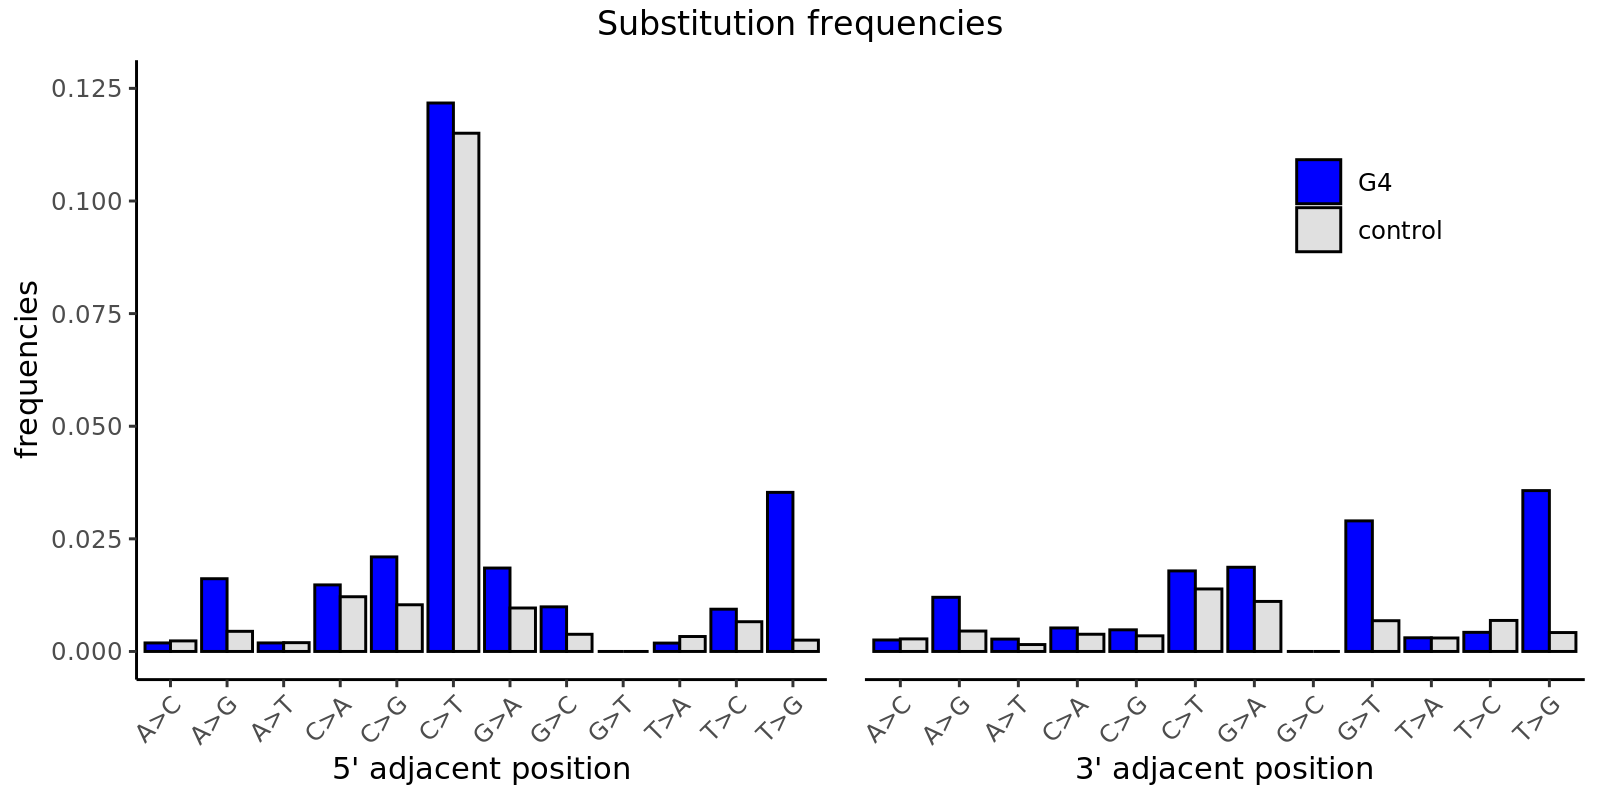

In [422]:
%%R -w 8 -h 4 --units in -r 200
library(RColorBrewer)

subtypes <- c(rep('A>T',2), rep('A>G',2), rep('A>C',2), rep('T>A',2),
              rep('T>G',2), rep('T>C',2), rep('G>A',2), rep('G>C',2),
              rep('G>T',2), rep('C>A',2),rep('C>T',2),rep('C>G',2))

left_freqs <- c(0.00189251,0.0019516,0.0161467,0.00446856,0.00189251,0.00234192,
          0.00185943,0.00331785,0.0353168,0.00251493,0.00938104,0.0066017,
          0.0185185,0.0096463,0.00990099,0.00381098,0,0,0.014775,0.0121457,
          0.121752,0.115044,0.0209877,0.0103627)

right_freqs <- c(0.00274424,0.00153257,0.0120244,0.0045283,0.00254638,0.0027881,
                0.00303281,0.00298805,0.0357068,0.00419664,0.00424528,0.00688468,
                0.0186916,0.011106,0,0,0.0289855,0.00682261,0.00521835,0.00382044,
                0.0178808,0.0138728,0.00480132,0.00346821)

legend <- rep(c('G4','control'),12)


left_df <- cbind.data.frame(legend,subtypes,left_freqs)
right_df <- cbind.data.frame(legend,subtypes,right_freqs)
names(left_df) <- c('legend', 'subtype', 'freqs')
names(right_df) <- c('legend', 'subtype', 'freqs')


#print(df)
cols = c('blue','gray88')

g1 <- ggplot(left_df) + 
    geom_bar(aes(fill = legend, x=subtype, y=freqs), position = position_dodge2(padding = 0.0), stat="identity", colour="black") +
    theme_classic() + #+ scale_y_continuous(limits = c(0.0,0.15))
    theme(text=element_text(family="sans"),
            legend.position="none",
            axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(x="5' adjacent position", y="frequencies") +
    scale_fill_manual(name="", values = cols)+
    scale_y_continuous(limits = c(0.0,0.125), breaks = c(0.00,0.025,0.050,0.075,0.100,0.125))

g2 <- ggplot(right_df) + 
    geom_bar(aes(fill = legend, x=subtype, y=freqs), position = position_dodge2(padding = 0.0), stat="identity", colour="black") +
    theme_classic() + #+ scale_y_continuous(limits = c(0.0,0.15))
    theme(text=element_text(family="sans"),
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.line.y=element_blank(),
            axis.title.y=element_blank(),
            legend.position=c(0.7, 0.8),
            axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(x="3' adjacent position", y="frequencies") +
    scale_fill_manual(name="", values = cols)+
    scale_y_continuous(limits = c(0.0,0.125))

grid.arrange(g1, g2, ncol=2, widths=c(1,0.9),
            top=textGrob("Substitution frequencies",gp=gpar(fontsize=12,family="sans")))

g <- arrangeGrob(g1, g2, ncol=2, widths=c(1,0.9),
            top=textGrob("Substitution frequencies",gp=gpar(fontsize=12,family="sans")))

ggsave(file='SubFeqs.pdf',g, width=8, height=4, dpi=300)
ggsave(file='SubFeqs.tiff',g, width=4, height=4, dpi=300)


In [74]:
## Match SNPs of interest with SNP dictionary to obtain substitution type
import itertools

#QuadronHigh = open('NCNRQuadron.high.trinucl.left.fa', 'rt')
QuadronLow = open('NCNRQuadron.low.trinucl.left.fa', 'rt')
QuadronCtrl = open('NCNRQuadron.ctrl.trinucl.left.fa', 'rt')

permutations = itertools.permutations(['A','T','G','C'], 2)
rows = []
for permutation in permutations:
    #print(permutation[0]+'->'+permutation[1])
    rows.append(trinucl_test(snpdict, QuadronLow, QuadronCtrl, permutation[0], permutation[1]))
    #QuadronHigh.seek(0)
    QuadronLow.seek(0)
    QuadronCtrl.seek(0)
    
colnames = ['ref','alt','test freq','ctrl freq', 'odds ratio', 'pvalue']
trinucl_df = pd.DataFrame(data=rows, columns=colnames)

trinucl_df = trinucl_df[trinucl_df['test freq'] != 'NA']

p_adjusted = multipletests(trinucl_df.pvalue, alpha=0.05, method='bonferroni')

trinucl_df['Adj. p-val'] = p_adjusted[1] 
del trinucl_df['pvalue']
print(trinucl_df)


   ref alt  test freq  ctrl freq  odds ratio  Adj. p-val
0    A   T   0.001092   0.001952    0.559389    1.000000
1    A   G   0.006522   0.004469    1.459511    1.000000
2    A   C   0.001820   0.002342    0.776929    1.000000
3    T   A   0.002049   0.003318    0.617623    1.000000
4    T   G   0.002728   0.002515    1.084843    1.000000
5    T   C   0.010989   0.006602    1.664574    0.351932
6    G   A   0.017350   0.012093    1.434725    1.000000
7    G   T   0.009464   0.002326    4.069401    0.268744
8    G   C   0.011041   0.003256    3.391167    0.287713
9    C   A   0.010578   0.012146    0.870945    1.000000
10   C   T   0.119332   0.115044    1.037268    1.000000
11   C   G   0.012238   0.010363    1.180944    1.000000


/home/wilfried/conda/wil_works/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [75]:
## Match SNPs of interest with SNP dictionary to obtain substitution type
import itertools

#QuadronHigh = open('NCNRQuadron.high.trinucl.left.fa', 'rt')
QuadronLow = open('NCNRQuadron.low.trinucl.right.fa', 'rt')
QuadronCtrl = open('NCNRQuadron.ctrl.trinucl.right.fa', 'rt')

permutations = itertools.permutations(['A','T','G','C'], 2)
rows = []
for permutation in permutations:
    #print(permutation[0]+'->'+permutation[1])
    rows.append(trinucl_test(snpdict, QuadronLow, QuadronCtrl, permutation[0], permutation[1]))
    #QuadronHigh.seek(0)
    QuadronLow.seek(0)
    QuadronCtrl.seek(0)
    
colnames = ['ref','alt','test freq','ctrl freq', 'odds ratio', 'pvalue']
trinucl_df = pd.DataFrame(data=rows, columns=colnames)

trinucl_df = trinucl_df[trinucl_df['test freq'] != 'NA']

p_adjusted = multipletests(trinucl_df.pvalue, alpha=0.05, method='bonferroni')

trinucl_df['Adj. p-val'] = p_adjusted[1] 
del trinucl_df['pvalue']
print(trinucl_df)


   ref alt  test freq  ctrl freq  odds ratio  Adj. p-val
0    A   T   0.001231   0.001533    0.803077    1.000000
1    A   G   0.005692   0.004528    1.257016    1.000000
2    A   C   0.000924   0.002788    0.331536    1.000000
3    T   A   0.001733   0.002998    0.577963    1.000000
4    T   G   0.008663   0.004197    2.064152    0.936954
5    T   C   0.003866   0.006885    0.561599    1.000000
6    G   A   0.014151   0.011106    1.274175    1.000000
7    G   T   0.011737   0.007468    1.571703    1.000000
8    G   C   0.007194   0.004098    1.755396    1.000000
9    C   A   0.003768   0.003820    0.986169    1.000000
10   C   T   0.014960   0.013873    1.078357    1.000000
11   C   G   0.002554   0.003468    0.736439    1.000000


/home/wilfried/conda/wil_works/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


# 3. Inverted Repeats

## Recover annotation
```
cat *_Inverted_Repeat.tsv > Inverted_Repeat.tsv
```

In [ ]:
inputfile = open('Inverted_Repeat.tsv', 'rt')
output = open('temp.tsv', 'w+')

for line in inputfile:
    array=line.strip().split('\t')
    for item in array:
        if item[:3] != 'chr':
            output.write(item+'\t')
        else:
            output.write('\n'+item)

inputfile = open('temp.tsv', 'rt')
output = open('InvertedRepeats.bed', 'w+')

for line in inputfile:
    if "Inverted_Repeat" in line:
        array = line.strip().split('\t')
        chrom, start, end = array[0].split('_')[:3]
        start = str(int(start)-1) # adapt to BED
        spacer = array[3]
        output.write(chrom+'\t'+start+'\t'+end+'\t'+spacer+'\n')


```
bedtools intersect -a InvertedRepeats.bed -b ../LocalVariation/CRgenome.merged.bed -v > NCNRInvertedRepeats.bed

awk '{if ($3-$2<=100) print $0}' NCNRInvertedRepeats.bed > NCNR.InvertedRepeats.100threshold.bed

bedtools sort -i NCNR.InvertedRepeats.100threshold.bed > NCNR.InvertedRepeats.100threshold.sorted.bed
```

## Create Flanks
```
paste NCNR.InvertedRepeats.100threshold.sorted.bed  <(bedtools slop -i NCNR.InvertedRepeats.100threshold.sorted.bed -g hg19.genome -b 2000) | awk '{print $1 "\t" $6 "\t" $7 "\t" $3-$2 "\t+\t" $2 "\t" $3 "\t" $4}' > NCNRInvertedRepeats.flanked.bed
```

## Create Controls
```
cut -f 1-3 NCNR.InvertedRepeats.100threshold.sorted.bed > temp_IR
cat temp_IR gaps.bed ../LocalVariation/CRgenome.sorted.bed > exclude_IR.bed #GAPS FROM UCSC
bedtools shuffle -i NCNR.InvertedRepeats.100threshold.sorted.bed -excl exclude_IR.bed -g hg19.genome -chrom -f 0 -noOverlapping > temp_IR
bedtools sort -i temp_IR > NCNRIR.shuffled.bed
paste NCNRIR.shuffled.bed  <(bedtools slop -i NCNRIR.shuffled.bed -g hg19.genome -b 2000) | awk '{print $1 "\t" $6 "\t" $7 "\t" $3-$2+1 "\t+\t" $2 "\t" $3 "\t" $4}' > NCNRInvertedRepeats.shuffled.flanked.bed
```

## Remove Overlaps
```
python Locuschoice.py NCNRInvertedRepeats.flanked.bed NCNRInvertedRepeats.nooverlap.bed
python Locuschoice.py NCNRInvertedRepeats.shuffled.flanked.bed NCNRInvertedRepeats.shuffled.nooverlap.bed
```

## Split Repeats, Spacer, and Flanks

```
python Split.py NCNRInvertedRepeats
>141009 Loci
>25243 ZeroSpacers
141009 - 25243 = 115766

python Split.py NCNRInvertedRepeats.shuffled
>137336 Loci
>24565 ZeroSpacers
137336 - 24565 = 112771
```

## Intersect annotations with variation datasets
```
bedtools intersect -wa -wb -a NCNRInvertedRepeats.split.bed -b ../SGDP/WholeSGDPsnps.bed -loj > NCNRInvertedRepeats.SGDP.intersect
bedtools intersect -wa -wb -a NCNRInvertedRepeats.split.bed -b ../LocalVariation/divergence.bed -loj > NCNRInvertedRepeats.divergence.intersect

bedtools intersect -wa -wb -a NCNRInvertedRepeats.shuffled.split.bed -b ../SGDP/WholeSGDPsnps.bed -loj > NCNRInvertedRepeats.SGDP.shuffled.intersect
bedtools intersect -wa -wb -a NCNRInvertedRepeats.shuffled.split.bed -b ../LocalVariation/divergence.bed -loj > NCNRInvertedRepeats.divergence.shuffled.intersect


python RelativePositions_InvertedRepeats.py NCNRInvertedRepeats.SGDP.intersect
python RelativePositions_InvertedRepeats.py NCNRInvertedRepeats.divergence.intersect
python RelativePositions_InvertedRepeats.py NCNRInvertedRepeats.SGDP.shuffled.intersect
python RelativePositions_InvertedRepeats.py NCNRInvertedRepeats.divergence.shuffled.intersect
```

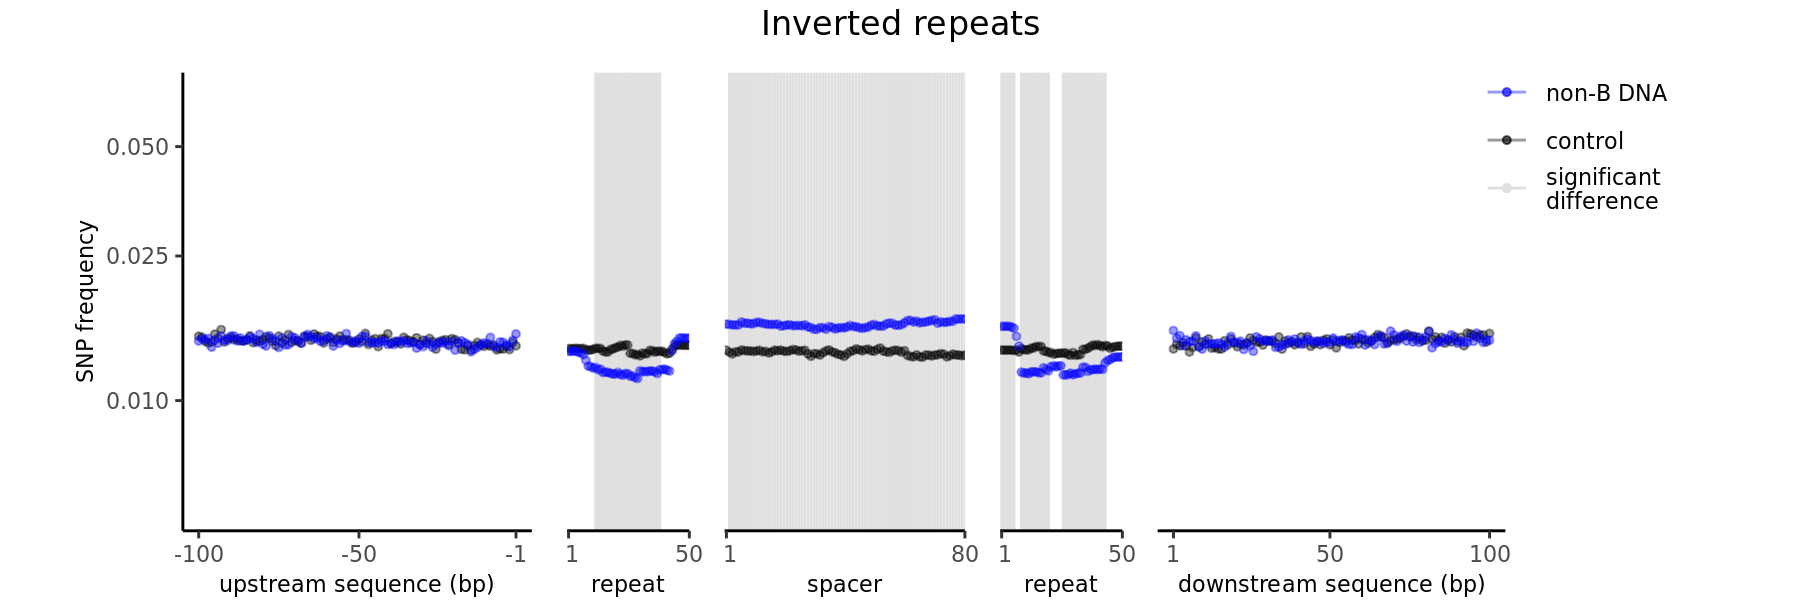

In [401]:
%%R -w 9 -h 3 --units in -r 200

csvfile <- read.csv('NCNRInvertedRepeats.SGDP.intersect.csv', header = TRUE)
csvfile <- csvfile[which(csvfile$snp_start != "NA"),]

LeftFlank <- table(csvfile[which(csvfile$snp_pos == "LeftFlank"),9])/141009
LeftRepeat <- table(csvfile[which(csvfile$snp_pos == "LeftRepeat"),9])/141009
#LeftRepeat <- table(c(csvfile[which(csvfile$snp_pos == "LeftRepeat"),9],0.00,1.00))/141009
Spacer <- table(csvfile[which(csvfile$snp_pos == "Spacer"),9])/115766
#Spacer <- table(c(csvfile[which(csvfile$snp_pos == "Spacer"),9],0.00,1.00))/115766
RightRepeat <- table(csvfile[which(csvfile$snp_pos == "RightRepeat"),9])/141009
#RightRepeat <- table(c(csvfile[which(csvfile$snp_pos == "RightRepeat"),9],0.00,1.00))/141009
RightFlank <- table(csvfile[which(csvfile$snp_pos == "RightFlank"),9])/141009

ctrl_csvfile <- read.csv('NCNRInvertedRepeats.SGDP.shuffled.intersect.csv', header = TRUE)
c_csvfile <- ctrl_csvfile[which(ctrl_csvfile$snp_start != "NA"),]

c_LeftFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "LeftFlank"),9])/137336
c_LeftRepeat <- table(c_csvfile[which(c_csvfile$snp_pos == "LeftRepeat"),9])/137336
#ctrl_LeftRepeat <- table(c(ctrl_csvfile[which(ctrl_csvfile$snp_pos == "LeftRepeat"),9],0.00,1.00))/137336
c_Spacer <- table(c_csvfile[which(c_csvfile$snp_pos == "Spacer"),9])/112771
#ctrl_Spacer <- table(c(ctrl_csvfile[which(ctrl_csvfile$snp_pos == "Spacer"),9],0.00,1.00))/112771
c_RightRepeat <- table(c_csvfile[which(c_csvfile$snp_pos == "RightRepeat"),9])/137336
#ctrl_RightRepeat <- table(c(ctrl_csvfile[which(ctrl_csvfile$snp_pos == "RightRepeat"),9],0.00,1.00))/137336
c_RightFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "RightFlank"),9])/137336

cols <- c("non-B DNA"=rgb(t(col2rgb('blue')), alpha=100, maxColorValue = 255),
          "significant\ndifference"="grey88",
          "control"=rgb(t(col2rgb('black')), alpha=100, maxColorValue = 255))

load('InvertedRepeats.SGDP_motif_vs_control_IWTomics_center_0.01.RData')
load('InvertedRepeats.SGDP_motif_vs_control_IWTomics_left_0.01.RData')
load('InvertedRepeats.SGDP_motif_vs_control_IWTomics_right_0.01.RData')

LeftFlankDf <- cbind.data.frame(LeftFlank,c_LeftFlank,adj_pvalue_curve_left$significant)[,c(1,2,4,5)]
names(LeftFlankDf) <- c('Levels','Freq','C_Freq','Signif')
LeftFlankDf$Levels <- as.numeric(as.character(LeftFlankDf$Levels))
LeftFlankDf_cut <- LeftFlankDf[which(LeftFlankDf$Levels >= -100),]
LeftFlankDf_cut$Levels <- seq(-100,-1,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'LeftRepeat'),"significant"]
LeftRepeatDf <- cbind.data.frame(LeftRepeat,c_LeftRepeat,Signif)[,c(1,2,4,5)]
names(LeftRepeatDf) <- c('Levels','Freq','C_Freq','Signif')
LeftRepeatDf$Levels <- seq(1,50,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'Spacer'),"significant"]
SpacerDf <- cbind.data.frame(Spacer,c_Spacer,Signif)[,c(1,2,4,5)]
names(SpacerDf) <- c('Levels','Freq','C_Freq','Signif')
SpacerDf$Levels <- seq(1,80,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'RightRepeat'),"significant"]
RightRepeatDf <- cbind.data.frame(RightRepeat,c_RightRepeat,Signif)[,c(1,2,4,5)]
names(RightRepeatDf) <- c('Levels','Freq','C_Freq','Signif')
RightRepeatDf$Levels <- seq(1,50,1)

RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant)[,c(1,2,4,5)]
names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif')
RightFlankDf$Levels <- as.numeric(as.character(RightFlankDf$Levels))
RightFlankDf_cut <- RightFlankDf[which(RightFlankDf$Levels <= 100),]
RightFlankDf_cut$Levels <- seq(1,100,1)

p1 <- ggplot(LeftFlankDf_cut, aes(x=Levels)) + 
                            geom_vline(xintercept= LeftFlankDf_cut[which(LeftFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.title = element_text(size=8,family="sans"),
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.text.y = element_text(size=8,family="sans")) +
                            labs(y="SNP frequency", x="upstream sequence (bp)", size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_continuous(breaks =  c(-100,-50,-1), limits = c(-100,-1)) +
                            theme(plot.margin = unit(c(10,5,1,1), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07), breaks = c(0.010,0.025,0.050) )


p2 <- ggplot(LeftRepeatDf, aes(x=Levels)) +
                            geom_vline(xintercept= LeftRepeatDf[which(LeftRepeatDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8, family='sans'),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="repeat",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 50), limits = c(1, 50)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))


p3 <- ggplot(SpacerDf, aes(x=Levels)) +
                            geom_vline(xintercept= SpacerDf[which(SpacerDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() +  
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="spacer",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 80), limits = c(1, 80)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))


p4 <- ggplot(RightRepeatDf, aes(x=Levels)) +
                            geom_vline(xintercept= RightRepeatDf[which(RightRepeatDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="repeat",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 50), limits = c(1, 50)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))



p5 <- ggplot(RightFlankDf_cut, aes(x=Levels))+ 
                            geom_line(aes(x=0,y=0,colour="significant\ndifference")) +
                            geom_vline(xintercept= RightFlankDf_cut[which(RightFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq, col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank(),
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                legend.text=element_text(size=8,family="sans"),
                                legend.position=c(1.2, 0.9),) +
                            labs(x="downstream sequence (bp)",size=8, family='sans')+
                            scale_colour_manual(name="",values=cols, breaks = c('non-B DNA', 'control', 'significant\ndifference')) +
                            scale_x_continuous(breaks = c(1,50,100), limits = c(1,100)) +
                            theme(plot.margin = unit(c(10,80,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07)) +
                            guides(shape = guide_legend(order = 3))



grid.arrange(p1, p2, p3, p4, p5, ncol=5, 
            widths=unit(c(60,20,35,20,75), c("mm", "mm", "mm", "mm", "mm")),
            top=textGrob("Inverted repeats",gp=gpar(fontsize=12,family="sans")))

g <- arrangeGrob(p1, p2, p3, p4, p5, ncol=5, 
            widths=unit(c(60,20,35,20,75), c("mm", "mm", "mm", "mm", "mm")),
            top=textGrob("Inverted repeats",gp=gpar(fontsize=12,family="sans")))

ggsave(file='IR_SNP.pdf',g, width=9, height=3, dpi=300)


In [276]:
%%R
min(adj_pvalue_curve_left[which(adj_pvalue_curve_left$significant == "TRUE"),"snp_coord"])


[1] Inf


In [272]:
%%R
min(adj_pvalue_curve_left[which(adj_pvalue_curve_left$significant == "TRUE"),"snp_coord"])


[1] Inf


In [673]:
%%R
repeats <- rbind(LeftRepeatDf,RightRepeatDf)
print(max(repeats$Ctrl_Freq/repeats$Freq))

print(max(SpacerDf$Freq/SpacerDf$Ctrl_Freq))

[1] 1.281017
[1] 1.289509


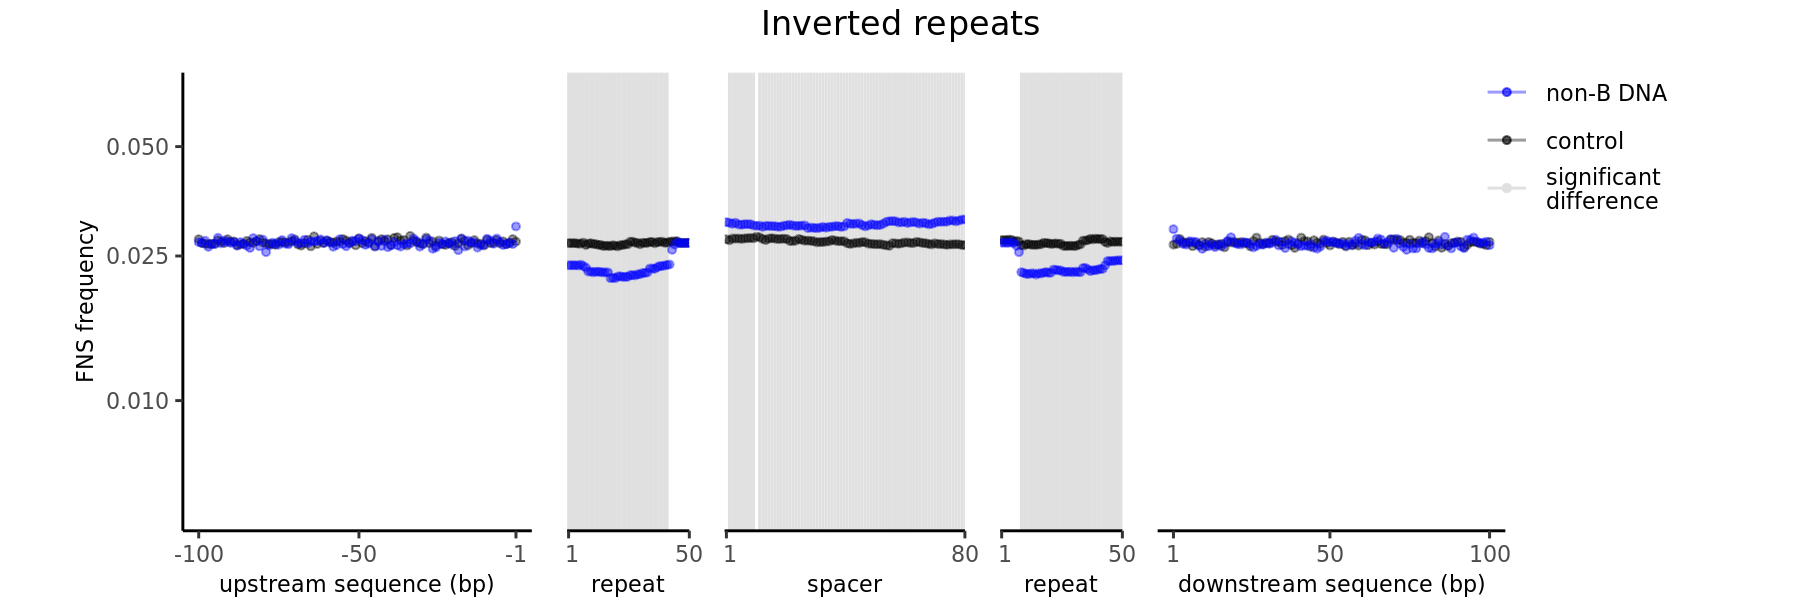

In [402]:
%%R -w 9 -h 3 --units in -r 200

csvfile <- read.csv('NCNRInvertedRepeats.divergence.intersect.csv', header = TRUE)
csvfile <- csvfile[which(csvfile$snp_start != "NA"),]

LeftFlank <- table(csvfile[which(csvfile$snp_pos == "LeftFlank"),9])/141009
LeftRepeat <- table(csvfile[which(csvfile$snp_pos == "LeftRepeat"),9])/141009
#LeftRepeat <- table(c(csvfile[which(csvfile$snp_pos == "LeftRepeat"),9],0.00,1.00))/141009
Spacer <- table(csvfile[which(csvfile$snp_pos == "Spacer"),9])/115766
#Spacer <- table(c(csvfile[which(csvfile$snp_pos == "Spacer"),9],0.00,1.00))/115766
RightRepeat <- table(csvfile[which(csvfile$snp_pos == "RightRepeat"),9])/141009
#RightRepeat <- table(c(csvfile[which(csvfile$snp_pos == "RightRepeat"),9],0.00,1.00))/141009
RightFlank <- table(csvfile[which(csvfile$snp_pos == "RightFlank"),9])/141009

ctrl_csvfile <- read.csv('NCNRInvertedRepeats.divergence.shuffled.intersect.csv', header = TRUE)
c_csvfile <- ctrl_csvfile[which(ctrl_csvfile$snp_start != "NA"),]

c_LeftFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "LeftFlank"),9])/137336
c_LeftRepeat <- table(c_csvfile[which(c_csvfile$snp_pos == "LeftRepeat"),9])/137336
#ctrl_LeftRepeat <- table(c(ctrl_csvfile[which(ctrl_csvfile$snp_pos == "LeftRepeat"),9],0.00,1.00))/137336
c_Spacer <- table(c_csvfile[which(c_csvfile$snp_pos == "Spacer"),9])/112771
#ctrl_Spacer <- table(c(ctrl_csvfile[which(ctrl_csvfile$snp_pos == "Spacer"),9],0.00,1.00))/112771
c_RightRepeat <- table(c_csvfile[which(c_csvfile$snp_pos == "RightRepeat"),9])/137336
#ctrl_RightRepeat <- table(c(ctrl_csvfile[which(ctrl_csvfile$snp_pos == "RightRepeat"),9],0.00,1.00))/137336
c_RightFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "RightFlank"),9])/137336

cols <- c("non-B DNA"=rgb(t(col2rgb('blue')), alpha=100, maxColorValue = 255),
          "significant\ndifference"="grey88",
          "control"=rgb(t(col2rgb('black')), alpha=100, maxColorValue = 255))

load('InvertedRepeats.divergence_motif_vs_control_IWTomics_center_0.01.RData')
load('InvertedRepeats.divergence_motif_vs_control_IWTomics_left_0.01.RData')
load('InvertedRepeats.divergence_motif_vs_control_IWTomics_right_0.01.RData')

LeftFlankDf <- cbind.data.frame(LeftFlank,c_LeftFlank,adj_pvalue_curve_left$significant)[,c(1,2,4,5)]
names(LeftFlankDf) <- c('Levels','Freq','C_Freq','Signif')
LeftFlankDf$Levels <- as.numeric(as.character(LeftFlankDf$Levels))
LeftFlankDf_cut <- LeftFlankDf[which(LeftFlankDf$Levels >= -100),]
LeftFlankDf_cut$Levels <- seq(-100,-1,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'LeftRepeat'),"significant"]
LeftRepeatDf <- cbind.data.frame(LeftRepeat,c_LeftRepeat,Signif)[,c(1,2,4,5)]
names(LeftRepeatDf) <- c('Levels','Freq','C_Freq','Signif')
LeftRepeatDf$Levels <- seq(1,50,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'Spacer'),"significant"]
SpacerDf <- cbind.data.frame(Spacer,c_Spacer,Signif)[,c(1,2,4,5)]
names(SpacerDf) <- c('Levels','Freq','C_Freq','Signif')
SpacerDf$Levels <- seq(1,80,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'RightRepeat'),"significant"]
RightRepeatDf <- cbind.data.frame(RightRepeat,c_RightRepeat,Signif)[,c(1,2,4,5)]
names(RightRepeatDf) <- c('Levels','Freq','C_Freq','Signif')
RightRepeatDf$Levels <- seq(1,50,1)

RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant)[,c(1,2,4,5)]
names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif')
RightFlankDf$Levels <- as.numeric(as.character(RightFlankDf$Levels))
RightFlankDf_cut <- RightFlankDf[which(RightFlankDf$Levels <= 100),]
RightFlankDf_cut$Levels <- seq(1,100,1)

p1 <- ggplot(LeftFlankDf_cut, aes(x=Levels)) + 
                            geom_vline(xintercept= LeftFlankDf_cut[which(LeftFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.title = element_text(size=8,family="sans"),
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.text.y = element_text(size=8,family="sans")) +
                            labs(y="FNS frequency", x="upstream sequence (bp)", size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_continuous(breaks =  c(-100,-50,-1), limits = c(-100,-1)) +
                            theme(plot.margin = unit(c(10,5,1,1), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07), breaks = c(0.010,0.025,0.050) )


p2 <- ggplot(LeftRepeatDf, aes(x=Levels)) +
                            geom_vline(xintercept= LeftRepeatDf[which(LeftRepeatDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8, family='sans'),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="repeat",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 50), limits = c(1, 50)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))


p3 <- ggplot(SpacerDf, aes(x=Levels)) +
                            geom_vline(xintercept= SpacerDf[which(SpacerDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() +  
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="spacer",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 80), limits = c(1, 80)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))


p4 <- ggplot(RightRepeatDf, aes(x=Levels)) +
                            geom_vline(xintercept= RightRepeatDf[which(RightRepeatDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="repeat",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 50), limits = c(1, 50)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))



p5 <- ggplot(RightFlankDf_cut, aes(x=Levels))+ 
                            geom_line(aes(x=0,y=0,colour="significant\ndifference")) +
                            geom_vline(xintercept= RightFlankDf_cut[which(RightFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq, col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank(),
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                legend.text=element_text(size=8,family="sans"),
                                legend.position=c(1.2, 0.9),) +
                            labs(x="downstream sequence (bp)",size=8, family='sans')+
                            scale_colour_manual(name="",values=cols, breaks = c('non-B DNA', 'control', 'significant\ndifference')) +
                            scale_x_continuous(breaks = c(1,50,100), limits = c(1,100)) +
                            theme(plot.margin = unit(c(10,80,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07)) +
                            guides(shape = guide_legend(order = 3))



grid.arrange(p1, p2, p3, p4, p5, ncol=5, 
            widths=unit(c(60,20,35,20,75), c("mm", "mm", "mm", "mm", "mm")),
            top=textGrob("Inverted repeats",gp=gpar(fontsize=12,family="sans")))

g <- arrangeGrob(p1, p2, p3, p4, p5, ncol=5, 
            widths=unit(c(60,20,35,20,75), c("mm", "mm", "mm", "mm", "mm")),
            top=textGrob("Inverted repeats",gp=gpar(fontsize=12,family="sans")))

ggsave(file='IR_Divergence.pdf',g, width=9, height=3, dpi=300)


In [366]:
%%R
min(adj_pvalue_curve_left[which(adj_pvalue_curve_left$significant == "TRUE"),"snp_coord"])


[1] Inf


In [367]:
%%R
max(adj_pvalue_curve_right[which(adj_pvalue_curve_right$significant == "TRUE"),"snp_coord"])


[1] -Inf


In [22]:
%%R
repeats <- rbind(LeftRepeatDf,RightRepeatDf)
print(max(repeats$Ctrl_Freq/repeats$Freq))

print(max(SpacerDf$Freq/SpacerDf$Ctrl_Freq))

[1] 1.303942
[1] 1.215699


## Permuting

```
python Permuting.py NCNRInvertedRepeats.SGDP.intersect.csv NCNRInvertedRepeats.SGDP.shuffled.intersect.csv 141009 115766 137336 112771 NCNRInvertedRepeats.SGDP.permuted NCNRInvertedRepeats.ctrl.SGDP.permuted

python Permuting.py NCNRInvertedRepeats.divergence.intersect.csv NCNRInvertedRepeats.divergence.shuffled.intersect.csv 141009 115766 137336 112771 NCNRInvertedRepeats.divergence.permuted NCNRInvertedRepeats.ctrl.divergence.permuted
```

## SubRates

```
python SubRates.py NCNRInvertedRepeats.SGDP.intersect.csv NCNRInvertedRepeats.SGDP.shuffled.intersect.csv NA LeftFlank -1,0 NCNRInvertedRepeats.subrates.LeftFlank

python SubRates.py NCNRInvertedRepeats.SGDP.intersect.csv NCNRInvertedRepeats.SGDP.shuffled.intersect.csv NA RightFlank 1,2 NCNRInvertedRepeats.subrates.RightFlank
```

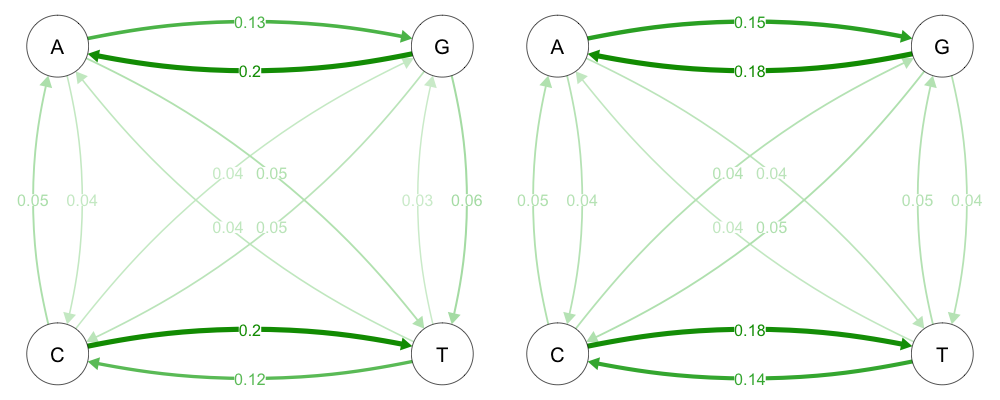

In [15]:
%%R -w 5 -h 2 --units in -r 200

dataset <- read.csv('NCNRInvertedRepeats.subrates.LeftFlank', header=TRUE)

TvTi(dataset, '-1')

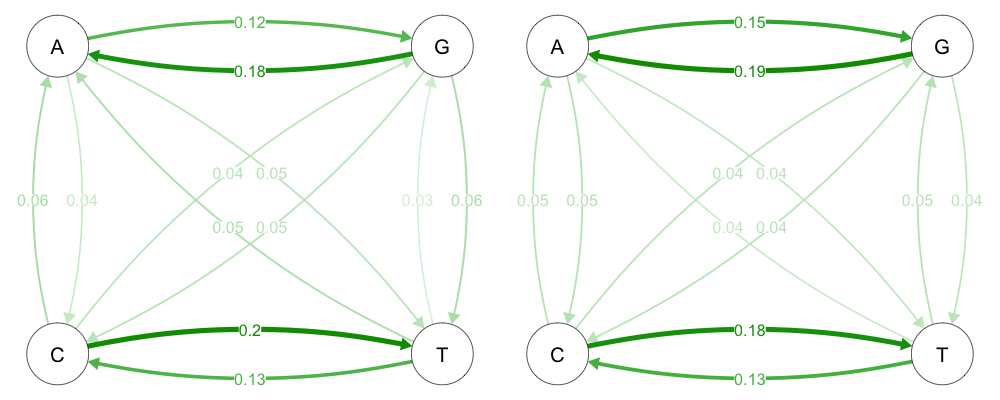

In [17]:
%%R -w 5 -h 2 --units in -r 200

dataset <- read.csv('NCNRInvertedRepeats.subrates.RightFlank', header=TRUE)

TvTi(dataset, '1')

In [731]:
%%bash
# List SNPs at positions of interest and adjust coordinates for trinucleotide context
awk '{if ($5=="+") print $0 }' NCNRInvertedRepeats.nooverlap.bed | awk 'BEGIN {OFS="\t"} {print $1, $6-2, $6+1}' | awk '{if ($2>0) print $0}'> NCNRInvertedRepeats.trinucl.left.bed
awk '{if ($5=="+") print $0 }' NCNRInvertedRepeats.shuffled.nooverlap.bed | awk 'BEGIN {OFS="\t"} {print $1, $6-2, $6+1}' | awk '{if ($2>0) print $0}'> NCNRInvertedRepeats.shuffled.trinucl.left.bed

awk '{if ($5=="+") print $0 }' NCNRInvertedRepeats.nooverlap.bed |awk 'BEGIN {OFS="\t"} {print $1, $7-1, $7+2}' > NCNRInvertedRepeats.trinucl.right.bed
awk '{if ($5=="+") print $0 }' NCNRInvertedRepeats.shuffled.nooverlap.bed |awk 'BEGIN {OFS="\t"} {print $1, $7-1, $7+2}' > NCNRInvertedRepeats.shuffled.trinucl.right.bed




```
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRInvertedRepeats.trinucl.left.bed > NCNRInvertedRepeats.trinucl.left.fa
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRInvertedRepeats.shuffled.trinucl.left.bed > NCNRInvertedRepeats.shuffled.trinucl.left.fa

bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRInvertedRepeats.trinucl.right.bed > NCNRInvertedRepeats.trinucl.right.fa
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRInvertedRepeats.shuffled.trinucl.right.bed > NCNRInvertedRepeats.shuffled.trinucl.right.fa
```

In [78]:
## Match SNPs of interest with SNP dictionary to obtain substitution type
import itertools

Test = open('NCNRInvertedRepeats.trinucl.left.fa', 'rt')
Control = open('NCNRInvertedRepeats.shuffled.trinucl.left.fa', 'rt')

permutations = itertools.permutations(['A','T','G','C'], 2)
rows = []
for permutation in permutations:
    rows.append(trinucl_test(snpdict, Test, Control, permutation[0], permutation[1]))
    Test.seek(0)
    Control.seek(0)
    
colnames = ['ref','alt','test freq','ctrl freq', 'odds ratio', 'pvalue']
trinucl_df = pd.DataFrame(data=rows, columns=colnames)

trinucl_df = trinucl_df[trinucl_df['test freq'] != 'NA']

p_adjusted = multipletests(trinucl_df.pvalue, alpha=0.05, method='bonferroni')

trinucl_df['Adj. p-val'] = p_adjusted[1] 
del trinucl_df['pvalue']
print(trinucl_df)


   ref alt  test freq  ctrl freq  odds ratio  Adj. p-val
0    A   T   0.002854   0.001952    1.462014    0.134982
1    A   G   0.006941   0.006931    1.001355    1.000000
2    A   C   0.002159   0.001951    1.106658    1.000000
3    T   A   0.002256   0.001710    1.319447    1.000000
4    T   G   0.001909   0.002114    0.903200    1.000000
5    T   C   0.006372   0.006365    1.001109    1.000000
6    G   A   0.014535   0.013091    1.110308    1.000000
7    G   T   0.004543   0.002998    1.515167    0.038308
8    G   C   0.003419   0.003302    1.035371    1.000000
9    C   A   0.004102   0.003380    1.213567    1.000000
10   C   T   0.014542   0.012853    1.131385    1.000000
11   C   G   0.002988   0.003100    0.964081    1.000000


/home/wilfried/conda/wil_works/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [79]:
## Match SNPs of interest with SNP dictionary to obtain substitution type
import itertools

Test = open('NCNRInvertedRepeats.trinucl.right.fa', 'rt')
Control = open('NCNRInvertedRepeats.shuffled.trinucl.right.fa', 'rt')

permutations = itertools.permutations(['A','T','G','C'], 2)
rows = []
for permutation in permutations:
    rows.append(trinucl_test(snpdict, Test, Control, permutation[0], permutation[1]))
    Test.seek(0)
    Control.seek(0)
    
colnames = ['ref','alt','test freq','ctrl freq', 'odds ratio', 'pvalue']
trinucl_df = pd.DataFrame(data=rows, columns=colnames)

trinucl_df = trinucl_df[trinucl_df['test freq'] != 'NA']

p_adjusted = multipletests(trinucl_df.pvalue, alpha=0.05, method='bonferroni')

trinucl_df['Adj. p-val'] = p_adjusted[1] 
del trinucl_df['pvalue']
print(trinucl_df)


   ref alt  test freq  ctrl freq  odds ratio  Adj. p-val
0    A   T   0.002564   0.002078    1.233968    1.000000
1    A   G   0.006466   0.006894    0.937966    1.000000
2    A   C   0.002024   0.002218    0.912251    1.000000
3    T   A   0.003203   0.001956    1.637407    0.012699
4    T   G   0.001803   0.002137    0.843784    1.000000
5    T   C   0.006689   0.006119    1.093228    1.000000
6    G   A   0.013690   0.013718    0.997917    1.000000
7    G   T   0.004231   0.003019    1.401320    0.247144
8    G   C   0.003447   0.003314    1.040175    1.000000
9    C   A   0.004394   0.003374    1.302121    0.703007
10   C   T   0.014258   0.013283    1.073421    1.000000
11   C   G   0.003214   0.003213    1.000346    1.000000


/home/wilfried/conda/wil_works/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


# 4. Z-DNA

## Recover Annotation
```
cat *_Z_DNA_Motif.tsv > ZDNA.tsv
```

In [ ]:
inputfile = open('ZDNA.tsv', 'rt')
output = open('temp.tsv', 'w+')

inputfile.readline()

for line in inputfile:
    array=line.strip().split('\t')
    for item in array:
        if item[:3] != 'chr':
            output.write(item+'\t')
        else:
            output.write('\n'+item)

inputfile = open('temp.tsv', 'rt')
output = open('ZDNA.bed', 'w+')

for line in inputfile:
    if "Z_DNA_Motif" in line:
        array = line.strip().split('\t')
        chrom, start, end = array[0].split('_')[:3]
        start = str(int(start)-1) # adapt to BED
        spacer = array[3]
        output.write(chrom+'\t'+start+'\t'+end+'\t'+spacer+'\n')


```
rm temp.tsv

bedtools intersect -a ZDNA.bed -b ../LocalVariation/CRgenome.merged.bed -v > NCNRZDNA.bed

awk '{if ($3-$2<=100) print $0}' NCNRZDNA.bed > NCNR.ZDNA.100threshold.bed

bedtools sort -i NCNR.ZDNA.100threshold.bed > NCNR.ZDNA.100threshold.sorted.bed
```

## Create Flanks

```
paste NCNR.ZDNA.100threshold.sorted.bed  <(bedtools slop -i NCNR.ZDNA.100threshold.sorted.bed -g hg19.genome -b 2000) | awk '{print $1 "\t" $6 "\t" $7 "\t" $3-$2 "\t+\t" $2 "\t" $3 "\t" $4}' > NCNRZDNA.flanked.bed
```

## Create Controls
```
cut -f 1-3 NCNR.ZDNA.100threshold.sorted.bed > temp_ZDNA
cat temp_ZDNA gaps.bed ../LocalVariation/CRgenome.sorted.bed > exclude_ZDNA.bed #GAPS FROM UCSC
bedtools shuffle -i NCNR.ZDNA.100threshold.sorted.bed -excl exclude_ZDNA.bed -g hg19.genome -chrom -f 0 -noOverlapping > temp_ZDNA
bedtools sort -i temp_ZDNA > NCNRZDNA.shuffled.bed
paste NCNRZDNA.shuffled.bed  <(bedtools slop -i NCNRZDNA.shuffled.bed -g hg19.genome -b 2000) | awk '{print $1 "\t" $6 "\t" $7 "\t" $3-$2+1 "\t+\t" $2 "\t" $3 "\t" $4}' > NCNRZDNA.shuffled.flanked.bed
```


## 4.2 Pick non-overlaping windows

```
python Locuschoice.py NCNRZDNA.flanked.bed NCNRZDNA.nooverlap.bed
python Locuschoice.py NCNRZDNA.shuffled.flanked.bed NCNRZDNA.shuffled.nooverlap.bed
```

## Split Motifs and Flanks



In [ ]:
#Split_ZDNA.py

import sys
#ToSplitFile = open('NCNRDirectRepeats.flanked.bed', 'rt')
#outfile = open('NCNRDirectRepeats.split.bed', 'w+')

ToSplitFile = open(sys.argv[1]+'.nooverlap.bed','rt')
outfile = open(sys.argv[1]+'.split.bed','w+')

LociCount = 0

for line in ToSplitFile:
    chrom, f_start, f_end, length, strand, l_start, l_end, = \
    line.strip().split('\t')[:-1]

    LociCount+=1


    outfile.write(chrom+'\t'+f_start+'\t'+l_start+'\tLeftFlank\n')
    outfile.write(chrom+'\t'+l_start+'\t'+l_end+'\tLocus\n')
    outfile.write(chrom+'\t'+l_end+'\t'+f_end+'\tRightFlank\n')


        
print(str(LociCount)+' Loci')



```
python Split_ZDNA.py NCNRZDNA
python Split_ZDNA.py NCNRZDNA.shuffled
```

## Intersect annotations with variation datasets
```
bedtools intersect -wa -wb -a NCNRZDNA.split.bed -b ../SGDP/WholeSGDPsnps.bed -loj > NCNRZDNA.SGDP.intersect
bedtools intersect -wa -wb -a NCNRZDNA.split.bed -b ../LocalVariation/divergence.bed -loj > NCNRZDNA.divergence.intersect

bedtools intersect -wa -wb -a NCNRZDNA.shuffled.split.bed -b ../SGDP/WholeSGDPsnps.bed -loj > NCNRZDNA.SGDP.shuffled.intersect
bedtools intersect -wa -wb -a NCNRZDNA.shuffled.split.bed -b ../LocalVariation/divergence.bed -loj > NCNRZDNA.divergence.shuffled.intersect
```

## 4.4 Compute relative position of variants

```
python RelativePositions_ZDNA.py NCNRZDNA.SGDP.intersect
python RelativePositions_ZDNA.py NCNRZDNA.divergence.intersect

python RelativePositions_ZDNA.py NCNRZDNA.SGDP.shuffled.intersect
python RelativePositions_ZDNA.py NCNRZDNA.divergence.shuffled.intersect
```

## Plot Results


In [55]:
%%bash
wc -l NCNRZDNA.nooverlap.bed
wc -l NCNRZDNA.shuffled.nooverlap.bed

67152 NCNRZDNA.nooverlap.bed
73532 NCNRZDNA.shuffled.nooverlap.bed


In [241]:
%%R
length(adj_pvalue_curve_center$significant)
length(c("FALSE",adj_pvalue_curve_center$significant,"FALSE"))

[1] 182


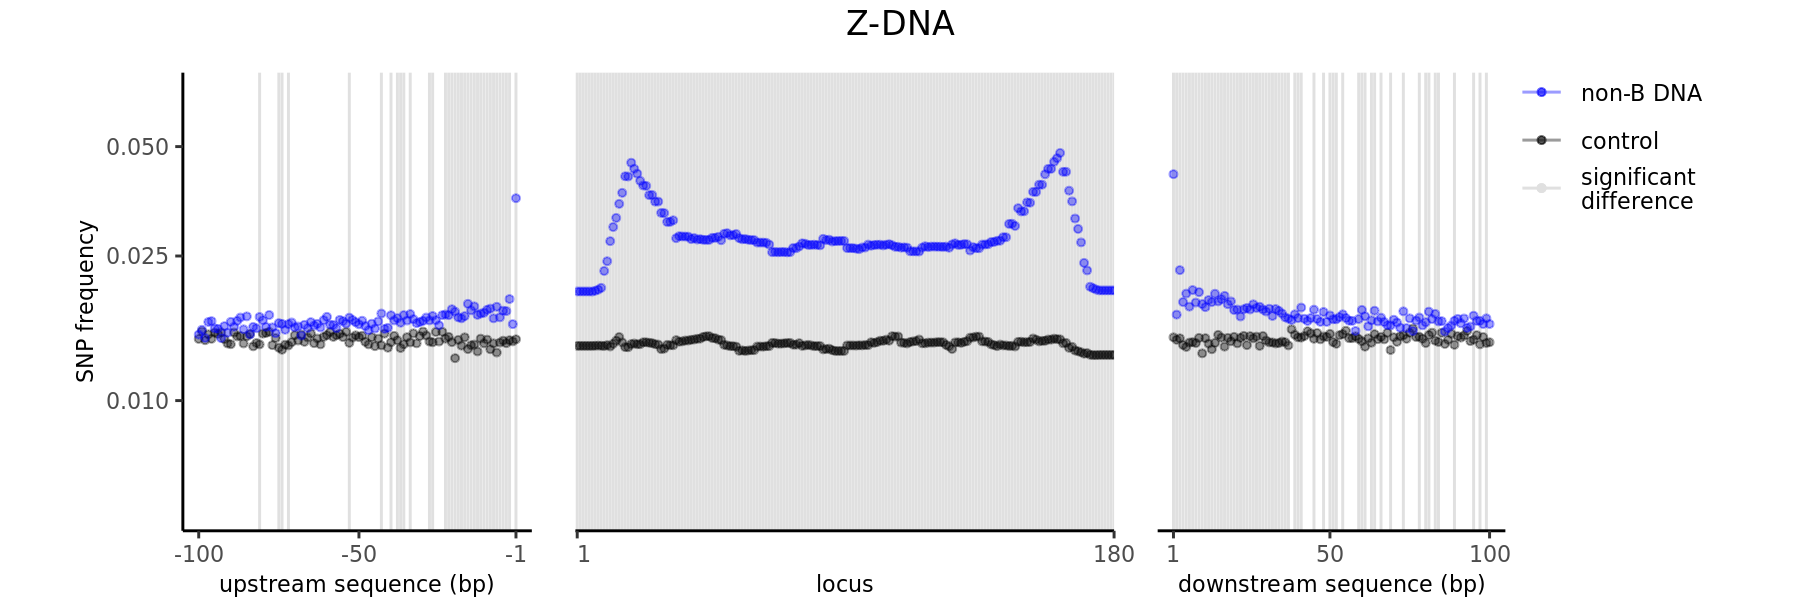

In [411]:
%%R -w 9 -h 3 --units in -r 200

csvfile <- read.csv('NCNRZDNA.SGDP.intersect.csv', header = TRUE)
csvfile <- csvfile[which(csvfile$snp_start != "NA"),]

LeftFlank <- table(csvfile[which(csvfile$snp_pos == "LeftFlank"),9])/67152
Loci <- table(csvfile[which(csvfile$snp_pos == "Locus"),9])/67152
RightFlank <- table(csvfile[which(csvfile$snp_pos == "RightFlank"),9])/67152

c_csvfile <- read.csv('NCNRZDNA.SGDP.shuffled.intersect.csv', header = TRUE)
c_csvfile <- c_csvfile[which(c_csvfile$snp_start != "NA"),]

c_LeftFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "LeftFlank"),9])/73532
c_Loci <- table(c_csvfile[which(c_csvfile$snp_pos == "Locus"),9])/73532
c_RightFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "RightFlank"),9])/73532

cols <- c("non-B DNA"=rgb(t(col2rgb('blue')), alpha=100, maxColorValue = 255),
          "significant\ndifference"="gray88",
          "control"=rgb(t(col2rgb('black')), alpha=100, maxColorValue = 255))

load('ZDNA.SGDP_motif_vs_control_IWTomics_left_0.01.RData')
load('ZDNA.SGDP_motif_vs_control_IWTomics_right_0.01.RData')
load('ZDNA.SGDP_motif_vs_control_IWTomics_center_0.01.RData')

LeftFlankDf <- cbind.data.frame(LeftFlank,c_LeftFlank,adj_pvalue_curve_left$significant)[,c(1,2,4,5)]
names(LeftFlankDf) <- c('Levels','Freq','C_Freq','Signif')
LeftFlankDf$Levels <- as.numeric(as.character(LeftFlankDf$Levels))
LeftFlankDf_cut <- LeftFlankDf[which(LeftFlankDf$Levels >= -100),]
LeftFlankDf_cut$Levels <- seq(-100,-1,1)

LociDf <- cbind.data.frame(Loci,c_Loci,adj_pvalue_curve_center$significant)[,c(1,2,4,5)]
names(LociDf) <- c('Levels','Freq','C_Freq','Signif')
LociDf$Levels <- seq(1,180,1)

RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant)[,c(1,2,4,5)]
names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif')
RightFlankDf$Levels <- as.numeric(as.character(RightFlankDf$Levels))
RightFlankDf_cut <- RightFlankDf[which(RightFlankDf$Levels <= 100),]
RightFlankDf_cut$Levels <- seq(1,100,1)

p1 <- ggplot(LeftFlankDf_cut, aes(x=Levels)) + 
                            geom_vline(xintercept= LeftFlankDf_cut[which(LeftFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1, ) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.title = element_text(size=8,family="sans"),
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.text.y = element_text(size=8,family="sans")) +
                            labs(y="SNP frequency", x="upstream sequence (bp)", size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_continuous(breaks =  c(-100,-50,-1), limits = c(-100,-1)) +
                            theme(plot.margin = unit(c(10,5,1,1), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07), breaks = c(0.010,0.025,0.050) )


p2 <- ggplot(LociDf, aes(x=Levels)) + 
                            geom_vline(xintercept= LociDf[which(LociDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() +  
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),            
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="locus",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 180), limits = c(1, 180)) +
                            theme(plot.margin = unit(c(10,8,1,8), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))



p3 <- ggplot(RightFlankDf_cut, aes(x=Levels)) + 
                            geom_line(aes(x=0,y=0,colour="significant\ndifference")) +
                            geom_vline(xintercept= RightFlankDf_cut[which(RightFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq, col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank(),
                                axis.text.x = element_text(size=8, family='sans'),
                                axis.title.x = element_text(size=8,family="sans"),
                                legend.text=element_text(size=8, family='sans'),
                                legend.position=c(1.3, 0.9)) +
                            labs(x="downstream sequence (bp)",size=8, family='sans')+
                            scale_colour_manual(name="",values=cols, breaks = c('non-B DNA', 'control', 'significant\ndifference')) +
                            scale_x_continuous(breaks = c(1,50,100), limits = c(1,100)) +
                            theme(plot.margin = unit(c(10,80,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07)) +
                            guides(shape = guide_legend(order = 3))



grid.arrange(p1, p2, p3, ncol=3, 
            widths=unit(c(60,75,75), c("mm", "mm", "mm")),
            top=textGrob("Z-DNA",gp=gpar(fontsize=12,family="sans")))

g <- arrangeGrob(p1, p2, p3, ncol=3, 
            widths=unit(c(60,75,75), c("mm", "mm", "mm")),
            top=textGrob("Z-DNA",gp=gpar(fontsize=12,family="sans")))

ggsave(file='ZDNA_SNP.pdf',g, width=9, height=3, dpi=300)


In [353]:
%%R
min(adj_pvalue_curve_left[which(adj_pvalue_curve_left$significant == "TRUE"),"snp_coord"])


[1] -81


In [354]:
%%R
max(adj_pvalue_curve_right[which(adj_pvalue_curve_right$significant == "TRUE"),"snp_coord"])


[1] 167


In [263]:
%%R
print(max(LociDf$Freq/LociDf$Ctrl_Freq))

flanks <- rbind(LeftFlankDf,RightFlankDf)
print(max(flanks$Freq/flanks$Ctrl_Freq))


[1] 3.257751
[1] 2.811319


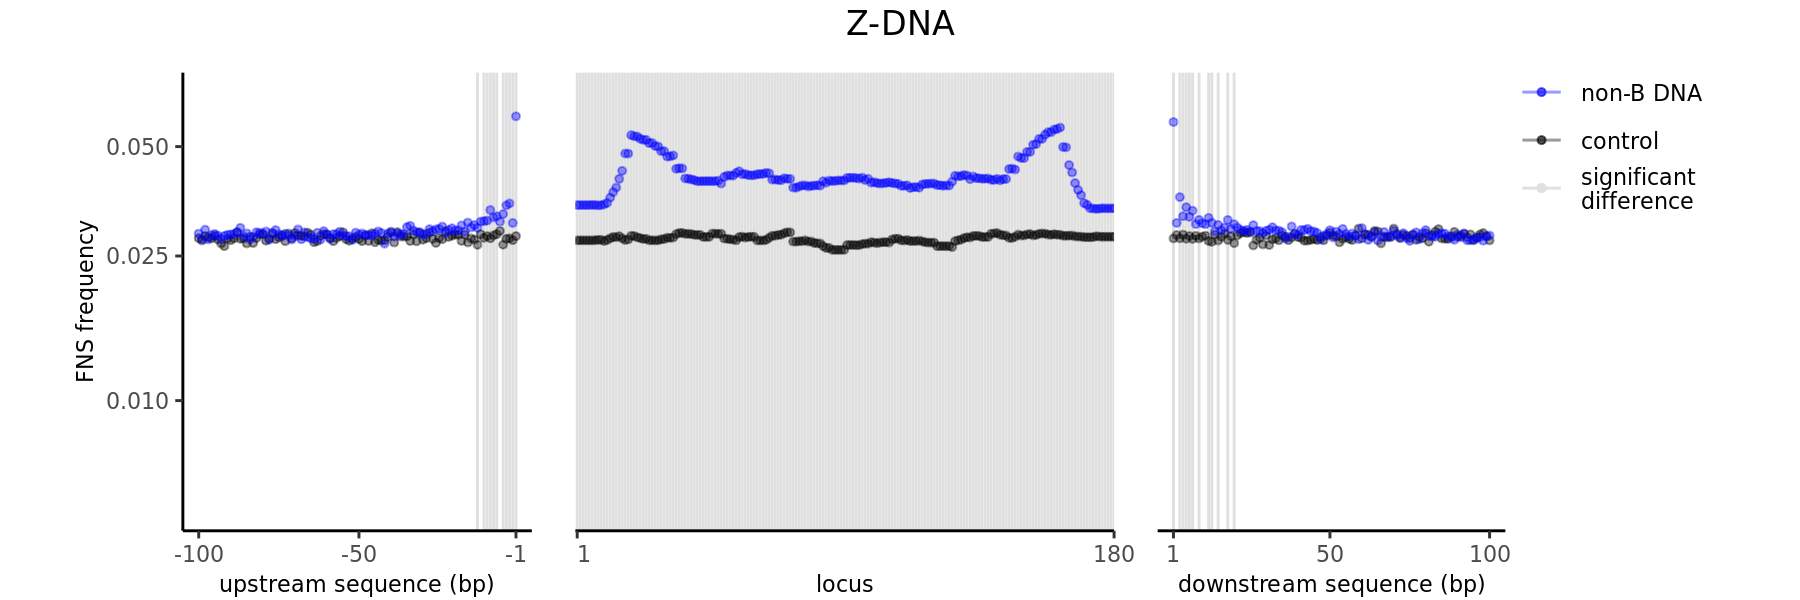

In [412]:
%%R -w 9 -h 3 --units in -r 200

csvfile <- read.csv('NCNRZDNA.divergence.intersect.csv', header = TRUE)
csvfile <- csvfile[which(csvfile$snp_start != "NA"),]

LeftFlank <- table(csvfile[which(csvfile$snp_pos == "LeftFlank"),9])/67152
Loci <- table(csvfile[which(csvfile$snp_pos == "Locus"),9])/67152
RightFlank <- table(csvfile[which(csvfile$snp_pos == "RightFlank"),9])/67152

c_csvfile <- read.csv('NCNRZDNA.divergence.shuffled.intersect.csv', header = TRUE)
c_csvfile <- c_csvfile[which(c_csvfile$snp_start != "NA"),]

c_LeftFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "LeftFlank"),9])/73532
c_Loci <- table(c_csvfile[which(c_csvfile$snp_pos == "Locus"),9])/73532
c_RightFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "RightFlank"),9])/73532

cols <- c("non-B DNA"=rgb(t(col2rgb('blue')), alpha=100, maxColorValue = 255),
          "significant\ndifference"="gray88",
          "control"=rgb(t(col2rgb('black')), alpha=100, maxColorValue = 255))

load('ZDNA.divergence_motif_vs_control_IWTomics_left_0.01.RData')
load('ZDNA.divergence_motif_vs_control_IWTomics_right_0.01.RData')
load('ZDNA.divergence_motif_vs_control_IWTomics_center_0.01.RData')

LeftFlankDf <- cbind.data.frame(LeftFlank,c_LeftFlank,adj_pvalue_curve_left$significant)[,c(1,2,4,5)]
names(LeftFlankDf) <- c('Levels','Freq','C_Freq','Signif')
LeftFlankDf$Levels <- as.numeric(as.character(LeftFlankDf$Levels))
LeftFlankDf_cut <- LeftFlankDf[which(LeftFlankDf$Levels >= -100),]
LeftFlankDf_cut$Levels <- seq(-100,-1,1)

LociDf <- cbind.data.frame(Loci,c_Loci,adj_pvalue_curve_center$significant)[,c(1,2,4,5)]
names(LociDf) <- c('Levels','Freq','C_Freq','Signif')
LociDf$Levels <- seq(1,180,1)

RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant)[,c(1,2,4,5)]
names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif')
RightFlankDf$Levels <- as.numeric(as.character(RightFlankDf$Levels))
RightFlankDf_cut <- RightFlankDf[which(RightFlankDf$Levels <= 100),]
RightFlankDf_cut$Levels <- seq(1,100,1)

p1 <- ggplot(LeftFlankDf_cut, aes(x=Levels)) + 
                            geom_vline(xintercept= LeftFlankDf_cut[which(LeftFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1, ) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.title = element_text(size=8,family="sans"),
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.text.y = element_text(size=8,family="sans")) +
                            labs(y="FNS frequency", x="upstream sequence (bp)", size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_continuous(breaks =  c(-100,-50,-1), limits = c(-100,-1)) +
                            theme(plot.margin = unit(c(10,5,1,1), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07), breaks = c(0.010,0.025,0.050) )


p2 <- ggplot(LociDf, aes(x=Levels)) + 
                            geom_vline(xintercept= LociDf[which(LociDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() +  
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),            
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="locus",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 180), limits = c(1, 180)) +
                            theme(plot.margin = unit(c(10,8,1,8), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))



p3 <- ggplot(RightFlankDf_cut, aes(x=Levels)) + 
                            geom_line(aes(x=0,y=0,colour="significant\ndifference")) +
                            geom_vline(xintercept= RightFlankDf_cut[which(RightFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq, col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank(),
                                axis.text.x = element_text(size=8, family='sans'),
                                axis.title.x = element_text(size=8,family="sans"),
                                legend.text=element_text(size=8, family='sans'),
                                legend.position=c(1.3, 0.9)) +
                            labs(x="downstream sequence (bp)",size=8, family='sans')+
                            scale_colour_manual(name="",values=cols, breaks = c('non-B DNA', 'control', 'significant\ndifference')) +
                            scale_x_continuous(breaks = c(1,50,100), limits = c(1,100)) +
                            theme(plot.margin = unit(c(10,80,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07)) +
                            guides(shape = guide_legend(order = 3))



grid.arrange(p1, p2, p3, ncol=3, 
            widths=unit(c(60,75,75), c("mm", "mm", "mm")),
            top=textGrob("Z-DNA",gp=gpar(fontsize=12,family="sans")))

g <- arrangeGrob(p1, p2, p3, ncol=3, 
            widths=unit(c(60,75,75), c("mm", "mm", "mm")),
            top=textGrob("Z-DNA",gp=gpar(fontsize=12,family="sans")))

ggsave(file='ZDNA_divergence.pdf',g, width=9, height=3, dpi=300)


In [373]:
%%R
min(adj_pvalue_curve_left[which(adj_pvalue_curve_left$significant == "TRUE"),"snp_coord"])


[1] -13


In [374]:
%%R
max(adj_pvalue_curve_right[which(adj_pvalue_curve_right$significant == "TRUE"),"snp_coord"])


[1] 20


In [694]:
%%R
print(max(LociDf$Freq/LociDf$Ctrl_Freq))

flanks <- rbind(LeftFlankDf,RightFlankDf)
print(max(flanks$Freq/flanks$Ctrl_Freq))


[1] 1.994938
[1] 2.116083


```
python Permuting.py NCNRZDNA.SGDP.intersect.csv NCNRZDNA.SGDP.shuffled.intersect.csv 67152 73532 NCNRZDNA.SGDP.permuted NCNRZDNA.ctrl.SGDP.permuted

python Permuting.py NCNRZDNA.divergence.intersect.csv NCNRZDNA.divergence.shuffled.intersect.csv 67152 73532 NCNRZDNA.divergence.permuted NCNRZDNA.ctrl.divergence.permuted
```

## SubRates

```
python SubRates.py NCNRZDNA.SGDP.intersect.csv NCNRZDNA.SGDP.shuffled.intersect.csv NA LeftFlank -1,0 NCNRZDNA.subrates.LeftFlank

python SubRates.py NCNRZDNA.SGDP.intersect.csv NCNRZDNA.SGDP.shuffled.intersect.csv NA RightFlank 1,2 NCNRZDNA.subrates.RightFlank
```

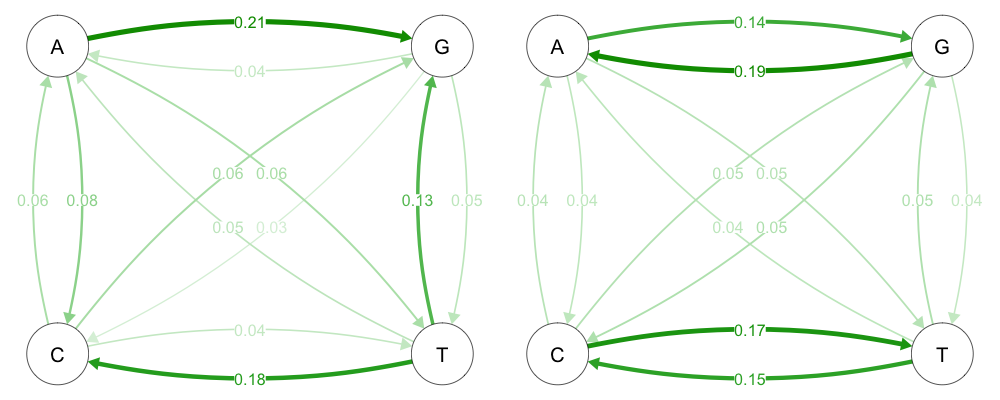

In [18]:
%%R -w 5 -h 2 --units in -r 200

dataset <- read.csv('NCNRZDNA.subrates.LeftFlank', header=TRUE)

TvTi(dataset, '-1')

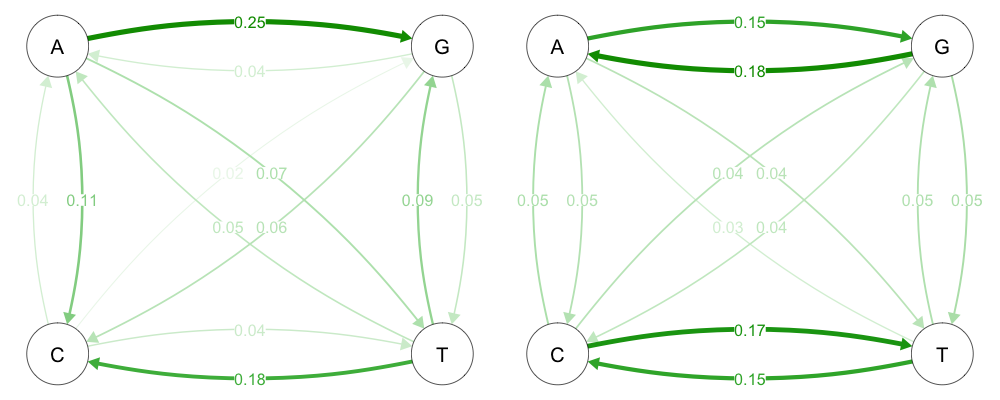

In [19]:
%%R -w 5 -h 2 --units in -r 200

dataset <- read.csv('NCNRZDNA.subrates.RightFlank', header=TRUE)

TvTi(dataset, '1')

In [745]:
%%bash
# List SNPs at positions of interest and adjust coordinates for trinucleotide context
awk '{if ($5=="+") print $0 }' NCNRZDNA.nooverlap.bed | awk 'BEGIN {OFS="\t"} {print $1, $6-2, $6+1}' | awk '{if ($2>0) print $0}'> NCNRZDNA.trinucl.left.bed
awk '{if ($5=="+") print $0 }' NCNRZDNA.shuffled.nooverlap.bed | awk 'BEGIN {OFS="\t"} {print $1, $6-2, $6+1}' | awk '{if ($2>0) print $0}'> NCNRZDNA.shuffled.trinucl.left.bed

awk '{if ($5=="+") print $0 }' NCNRZDNA.nooverlap.bed |awk 'BEGIN {OFS="\t"} {print $1, $7-1, $7+2}' > NCNRZDNA.trinucl.right.bed
awk '{if ($5=="+") print $0 }' NCNRZDNA.shuffled.nooverlap.bed |awk 'BEGIN {OFS="\t"} {print $1, $7-1, $7+2}' > NCNRZDNA.shuffled.trinucl.right.bed




```
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRZDNA.trinucl.left.bed > NCNRZDNA.trinucl.left.fa
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRZDNA.shuffled.trinucl.left.bed > NCNRZDNA.shuffled.trinucl.left.fa

bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRZDNA.trinucl.right.bed > NCNRZDNA.trinucl.right.fa
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRZDNA.shuffled.trinucl.right.bed > NCNRZDNA.shuffled.trinucl.right.fa
```

In [80]:
## Match SNPs of interest with SNP dictionary to obtain substitution type
import itertools

Test = open('NCNRZDNA.trinucl.left.fa', 'rt')
Control = open('NCNRZDNA.shuffled.trinucl.left.fa', 'rt')

permutations = itertools.permutations(['A','T','G','C'], 2)
rows = []
for permutation in permutations:
    rows.append(trinucl_test(snpdict, Test, Control, permutation[0], permutation[1]))
    Test.seek(0)
    Control.seek(0)
    
colnames = ['ref','alt','test freq','ctrl freq', 'odds ratio', 'pvalue']
trinucl_df = pd.DataFrame(data=rows, columns=colnames)

trinucl_df = trinucl_df[trinucl_df['test freq'] != 'NA']

p_adjusted = multipletests(trinucl_df.pvalue, alpha=0.05, method='bonferroni')

trinucl_df['Adj. p-val'] = p_adjusted[1] 
del trinucl_df['pvalue']
print(trinucl_df)


   ref alt  test freq  ctrl freq  odds ratio    Adj. p-val
0    A   T   0.005494   0.002308    2.380190  1.396519e-06
1    A   G   0.019229   0.006243    3.080247  9.160094e-33
2    A   C   0.007888   0.001658    4.756804  5.585802e-17
3    T   A   0.006020   0.001923    3.130139  1.495138e-08
4    T   G   0.018650   0.002301    8.106263  6.549373e-47
5    T   C   0.022240   0.006421    3.463646  2.281580e-36
6    G   A   0.011431   0.012071    0.946928  1.000000e+00
7    G   T   0.015172   0.002753    5.511853  6.462241e-12
8    G   C   0.008519   0.003956    2.153526  3.652721e-03
9    C   A   0.015111   0.005088    2.969711  1.790724e-08
10   C   T   0.008424   0.009907    0.850321  1.000000e+00
11   C   G   0.014481   0.004959    2.919994  1.649985e-08


/home/wilfried/conda/wil_works/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [81]:
## Match SNPs of interest with SNP dictionary to obtain substitution type
import itertools

Test = open('NCNRZDNA.trinucl.right.fa', 'rt')
Control = open('NCNRZDNA.shuffled.trinucl.right.fa', 'rt')

permutations = itertools.permutations(['A','T','G','C'], 2)
rows = []
for permutation in permutations:
    rows.append(trinucl_test(snpdict, Test, Control, permutation[0], permutation[1]))
    Test.seek(0)
    Control.seek(0)
    
colnames = ['ref','alt','test freq','ctrl freq', 'odds ratio', 'pvalue']
trinucl_df = pd.DataFrame(data=rows, columns=colnames)

trinucl_df = trinucl_df[trinucl_df['test freq'] != 'NA']

p_adjusted = multipletests(trinucl_df.pvalue, alpha=0.05, method='bonferroni')

trinucl_df['Adj. p-val'] = p_adjusted[1] 
del trinucl_df['pvalue']
print(trinucl_df)


   ref alt  test freq  ctrl freq  odds ratio    Adj. p-val
0    A   T   0.009894   0.002213    4.470314  2.277710e-20
1    A   G   0.036360   0.006029    6.030558  3.042187e-94
2    A   C   0.017386   0.002194    7.923874  2.663844e-47
3    T   A   0.003541   0.001925    1.838751  1.292269e-01
4    T   G   0.009919   0.002135    4.646763  2.116974e-25
5    T   C   0.019234   0.007044    2.730556  1.238204e-27
6    G   A   0.008826   0.009790    0.901555  1.000000e+00
7    G   T   0.011605   0.003846    3.017326  6.351494e-09
8    G   C   0.013730   0.003030    4.530892  6.054124e-16
9    C   A   0.011902   0.003098    3.842366  4.941395e-10
10   C   T   0.014444   0.010971    1.316630  6.204462e-01
11   C   G   0.007732   0.004953    1.561046  9.626686e-01


/home/wilfried/conda/wil_works/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


# Direct Repeats

## Recover Annotation

```
#cat *_Direct_Repeat.tsv > Direct_Repeat.tsv
cat *_DR.tsv > DR.tsv
cut -f 1,4,5,9,10  DR.tsv | grep -v Sequence > DR.bed
```

In [ ]:
#deprecated
inputfile = open('Direct_Repeat.tsv', 'rt')
output = open('temp.tsv', 'w+')

for line in inputfile:
    array=line.strip().split('\t')
    for item in array:
        if item[:3] != 'chr':
            output.write(item+'\t')
        else:
            output.write('\n'+item)

inputfile = open('temp.tsv', 'rt')
output = open('DirectRepeats.bed', 'w+')

for line in inputfile:
    if "Direct_Repeat" in line:
        array = line.strip().split('\t')
        chrom, start, end = array[0].split('_')[:3]
        start = str(int(start)-1) # adapt to BED
        spacer = array[3]
        output.write(chrom+'\t'+start+'\t'+end+'\t'+spacer+'\n')


```
rm temp.tsv

#bedtools intersect -a DirectRepeats.bed -b #../LocalVariation/CRgenome.merged.bed -v > NCNRDirectRepeats.bed

bedtools intersect -a DR.bed -b ../LocalVariation/CRgenome.merged.bed -v > NCNRDirectRepeats.bed

awk '{if ($3-$2<=100) print $0}' NCNRDirectRepeats.bed > NCNR.DirectRepeats.100threshold.bed

bedtools sort -i NCNR.DirectRepeats.100threshold.bed > NCNR.DirectRepeats.100threshold.sorted.bed
```

## Create Flanks

```
#paste NCNR.DirectRepeats.100threshold.sorted.bed  <(bedtools slop -i #NCNR.DirectRepeats.100threshold.sorted.bed -g hg19.genome -b 2000) | awk #'{print $1 "\t" $6 "\t" $7 "\t" $3-$2 "\t+\t" $2 "\t" $3 "\t" $4}' > #NCNRDirectRepeats.flanked.bed


paste NCNR.DirectRepeats.100threshold.sorted.bed  <(bedtools slop -i NCNR.DirectRepeats.100threshold.sorted.bed -g hg19.genome -b 2000) | awk '{print $1 "\t" $7 "\t" $8 "\t" $3-$2 "\t+\t" $2 "\t" $3 "\t" $4 "\t" $5}' > NCNRDirectRepeats.flanked.bed


```

## Create Controls

```
cut -f 1-3 NCNR.DirectRepeats.100threshold.sorted.bed > temp_DR
cat temp_DR gaps.bed ../LocalVariation/CRgenome.sorted.bed > exclude_DR.bed #GAPS FROM UCSC
bedtools shuffle -i NCNR.DirectRepeats.100threshold.sorted.bed -excl exclude_DR.bed -g hg19.genome -chrom -f 0 -noOverlapping > temp_DR
bedtools sort -i temp_DR > NCNRDR.shuffled.bed

#paste NCNRDR.shuffled.bed  <(bedtools slop -i NCNRDR.shuffled.bed -g #hg19.genome -b 2000) | awk '{print $1 "\t" $6 "\t" $7 "\t" $3-$2+1 #"\t+\t" $2 "\t" $3 "\t" $4}' > NCNRDirectRepeats.shuffled.flanked.bed

paste NCNRDR.shuffled.bed  <(bedtools slop -i NCNRDR.shuffled.bed -g hg19.genome -b 2000) | awk '{print $1 "\t" $7 "\t" $8 "\t" $3-$2+1 "\t+\t" $2 "\t" $3 "\t" $4 "\t" $5}' > NCNRDirectRepeats.shuffled.flanked.bed
```

## Remove Overlaps
```
python Locuschoice.py NCNRDirectRepeats.flanked.bed NCNRDirectRepeats.nooverlap.bed
python Locuschoice.py NCNRDirectRepeats.shuffled.flanked.bed NCNRDirectRepeats.shuffled.nooverlap.bed
```

## Split Repeats, Spacer, and Flanks

In [380]:
#Split.py

import sys
ToSplitFile = open('NCNRDirectRepeats.nooverlap.bed', 'rt')
outfile = open('NCNRDirectRepeats.split.bed', 'w+')

#ToSplitFile = open(sys.argv[1]+'.nooverlap.bed','rt')
#outfile = open(sys.argv[1]+'.split.bed','w+')

LociCount = 0
ZeroSacerCount = 0

for line in ToSplitFile:
    chrom, f_start, f_end, length, strand, l_start, l_end, spacer = \
    line.strip().split('\t')

    
    R_length = int((int(l_end)-int(l_start)-int(spacer))/2)
    R_length_test = (float(l_end)-float(l_start)-float(spacer))/2


    if float(R_length) == R_length_test:

        R1_start = int(l_start)
        R1_end = R1_start + R_length

        Spacer_start = R1_end
        Spacer_end = R1_end + int(spacer)

        R2_start = Spacer_end
        R2_end = R2_start + R_length

        if R2_end == int(l_end):
            LociCount+=1
            if spacer == '0':
                ZeroSacerCount+=1    
                
            outfile.write(chrom+'\t'+f_start+'\t'+l_start+'\tLeftFlank\n')
            outfile.write(chrom+'\t'+str(R1_start)+'\t'+str(R1_end)+'\tLeftRepeat\n')
            outfile.write(chrom+'\t'+str(Spacer_start)+'\t'+str(Spacer_end)+'\tSpacer\n')
            outfile.write(chrom+'\t'+str(R2_start)+'\t'+str(R2_end)+'\tRightRepeat\n')
            outfile.write(chrom+'\t'+l_end+'\t'+f_end+'\tRightFlank\n')
        else:
            print("Error coordinates not matching")

    else:   
        print("ERROR can't divide repeat in equal parts")
        print(line.strip().split('\t'))
        
print(str(LociCount)+' Loci')
print(str(ZeroSacerCount)+' ZeroSpacers')



In [ ]:
#Split_DR.py

import sys
ToSplitFile = open('NCNRDirectRepeats.nooverlap.bed', 'rt')
outfile = open('NCNRDirectRepeats.split.bed', 'w+')

#ToSplitFile = open(sys.argv[1]+'.nooverlap.bed','rt')
#outfile = open(sys.argv[1]+'.split.bed','w+')

LociCount = 0
ZeroSacerCount = 0

for line in ToSplitFile:
    array = line.strip().split('\t')
    #print(array)
    chrom, f_start, f_end, length, strand, l_start, l_end, repeat, spacer = array
    
    f_start = str(int(f_start) -1)
    l_start = str(int(l_start) -1)

    R1_start = int(l_start)
    R1_end = R1_start + int(repeat)

    Spacer_start = R1_end
    Spacer_end = Spacer_start + int(spacer)

    R2_start = Spacer_end
    R2_end = R2_start + int(repeat)


    LociCount+=1
    if spacer == '0':
        ZeroSacerCount+=1    

    outfile.write(chrom+'\t'+f_start+'\t'+l_start+'\tLeftFlank\n')
    outfile.write(chrom+'\t'+str(R1_start)+'\t'+str(R1_end)+'\tLeftRepeat\n')
    outfile.write(chrom+'\t'+str(Spacer_start)+'\t'+str(Spacer_end)+'\tSpacer\n')
    outfile.write(chrom+'\t'+str(R2_start)+'\t'+str(R2_end)+'\tRightRepeat\n')
    outfile.write(chrom+'\t'+l_end+'\t'+f_end+'\tRightFlank\n')



        
print(str(LociCount)+' Loci')
print(str(ZeroSacerCount)+' ZeroSpacers')



```
python Split_DR.py NCNRDirectRepeats
>101647 Loci
>23664 ZeroSpacers
101647 - 23664 = 77983

python Split_DR.py NCNRDirectRepeats.shuffled
>114543 Loci
>26620 ZeroSpacers
114543 - 26620 = 87923

bedtools getfasta -fi hg19.fa -bed NCNRDirectRepeats.split.bed -bedOut > NCNRDirectRepeats.split.fa.bed


```

## Intersect annotations with variation datasets
```
bedtools intersect -wa -wb -a NCNRDirectRepeats.split.bed -b ../SGDP/WholeSGDPsnps.bed -loj > NCNRDirectRepeats.SGDP.intersect
bedtools intersect -wa -wb -a NCNRDirectRepeats.split.bed -b ../LocalVariation/divergence.bed -loj > NCNRDirectRepeats.divergence.intersect

bedtools intersect -wa -wb -a NCNRDirectRepeats.shuffled.split.bed -b ../SGDP/WholeSGDPsnps.bed -loj > NCNRDirectRepeats.SGDP.shuffled.intersect
bedtools intersect -wa -wb -a NCNRDirectRepeats.shuffled.split.bed -b ../LocalVariation/divergence.bed -loj > NCNRDirectRepeats.divergence.shuffled.intersect
```

In [ ]:
# RelativePositions_DirectRepeats.py
import pandas as pd
import sys
import numpy as np
import random


intersectfile = open(sys.argv[1], 'rt')

scaledpositions_Repeat = []
for i in np.arange(1,50*2,2.0)/(50*2):
    scaledpositions_Repeat.append(round(i,4))

scaledpositions_Spacer = []
for i in np.arange(1,80*2, 2.0)/(80*2):
    scaledpositions_Spacer.append(round(i,4))


colnames = ['chrom','start', 'end', 'length', 'snp_start', 'snp_end',\
            'snp_pos','snp_coord_inwindow', 'ref', 'alt']

intersects = []

for line in intersectfile:
    array = line.strip().split('\t')

    if array[-1] != '.':
        if len(array) == 11: # diversity
            chrom, start, end, snp_pos, snpstart, snpend, ref, alt = \
                array[0], int(array[1]), int(array[2]), array[3], int(array[5]), int(array[6]), \
                array[7], array[8]
            
        elif len(array) == 9: # divergence
            chrom, start, end, snp_pos, snpstart, snpend = \
                array[0], int(array[1]), int(array[2]), array[3], int(array[5]), int(array[6])
            ref, alt = 'TBA', 'TBA'

        
    else: #ONLY IF INTERSECT -loj
        chrom, start, end, strand, snp_pos = \
            array[0], int(array[1]), int(array[2]), array[3], array[4]
        snpstart, snpend, ref, alt = "NA","NA","NA","NA"            
    
    length = end - start
    
    if snpstart != "NA":
        
        
        if snp_pos == "LeftFlank":
            snp_coord_inwindow = -(end - snpstart)
            intersects.append([chrom, start, end, length, snpstart, snpend,\
                     snp_pos, snp_coord_inwindow, ref, alt])
            
        elif snp_pos == "RightFlank":
            snp_coord_inwindow = snpend - start
            intersects.append([chrom, start, end, length, snpstart, snpend,\
                     snp_pos, snp_coord_inwindow, ref, alt])
            
        elif snp_pos == "LeftRepeat" or snp_pos == "RightRepeat":
            snp_coord_inwindow_start = float(snpstart - start) / length
            snp_coord_inwindow_end = float(snpend - start) / length
            
            for i in scaledpositions_Repeat:
                    
                if i >= snp_coord_inwindow_start and i < snp_coord_inwindow_end:

                    intersects.append([chrom, start, end, length, snpstart, snpend,\
                     snp_pos, i, ref, alt])
            
        elif snp_pos == "Spacer":
            if length >0:
                snp_coord_inwindow_start = float(snpstart - start) / length
                snp_coord_inwindow_end = float(snpend - start) / length

                for i in scaledpositions_Spacer:

                    if i >= snp_coord_inwindow_start and i < snp_coord_inwindow_end:

                        intersects.append([chrom, start, end, length, snpstart, snpend,\
                         snp_pos, i, ref, alt])  

    else: #ONLY FOR INTERSECT -loj
        intersects.append([chrom, start, end, length, strand, "NA", "NA", snp_pos, "NA", ref, alt])
        
        
df = pd.DataFrame(data=intersects, columns=colnames)
pd.DataFrame.to_csv(df, sys.argv[1]+'.csv')



```
python RelativePositions_DirectRepeats.py NCNRDirectRepeats.SGDP.intersect
python RelativePositions_DirectRepeats.py NCNRDirectRepeats.divergence.intersect
python RelativePositions_DirectRepeats.py NCNRDirectRepeats.SGDP.shuffled.intersect
python RelativePositions_DirectRepeats.py NCNRDirectRepeats.divergence.shuffled.intersect
```

## Plot Results


In [24]:
%%R
library(ggplot2)
library(grid)
library(gridExtra)

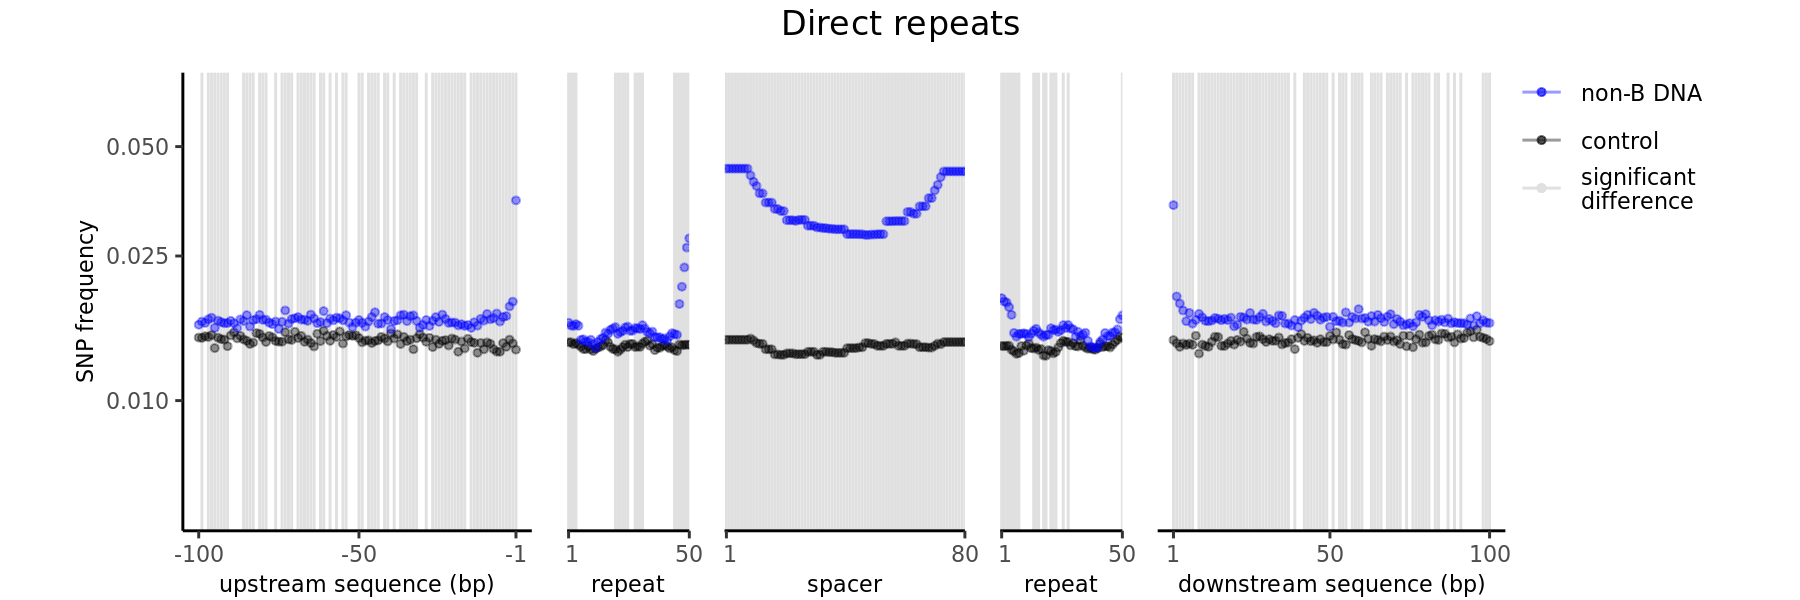

In [403]:
%%R -w 9 -h 3 --units in -r 200

csvfile <- read.csv('NCNRDirectRepeats.SGDP.intersect.csv', header = TRUE)
csvfile <- csvfile[which(csvfile$snp_start != "NA"),]

LeftFlank <- table(csvfile[which(csvfile$snp_pos == "LeftFlank"),9])/101647
LeftRepeat <- table(csvfile[which(csvfile$snp_pos == "LeftRepeat"),9])/101647
#LeftRepeat <- table(c(csvfile[which(csvfile$snp_pos == "LeftRepeat"),9],0.00,1.00))/101647
Spacer <- table(csvfile[which(csvfile$snp_pos == "Spacer"),9])/76813
#Spacer <- table(c(csvfile[which(csvfile$snp_pos == "Spacer"),9],0.00,1.00))/77983
RightRepeat <- table(csvfile[which(csvfile$snp_pos == "RightRepeat"),9])/101647
#RightRepeat <- table(c(csvfile[which(csvfile$snp_pos == "RightRepeat"),9],0.00,1.00))/101647
RightFlank <- table(csvfile[which(csvfile$snp_pos == "RightFlank"),9])/101647

c_csvfile <- read.csv('NCNRDirectRepeats.SGDP.shuffled.intersect.csv', header = TRUE)
c_csvfile <- c_csvfile[which(c_csvfile$snp_start != "NA"),]

c_LeftFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "LeftFlank"),9])/114543
c_LeftRepeat <- table(c_csvfile[which(c_csvfile$snp_pos == "LeftRepeat"),9])/114543
#ctrl_LeftRepeat <- table(c(ctrl_csvfile[which(ctrl_csvfile$snp_pos == "LeftRepeat"),9],0.00,1.00))/114543
c_Spacer <- table(c_csvfile[which(c_csvfile$snp_pos == "Spacer"),9])/87923
#ctrl_Spacer <- table(c(ctrl_csvfile[which(ctrl_csvfile$snp_pos == "Spacer"),9],0.00,1.00))/87923
c_RightRepeat <- table(c_csvfile[which(c_csvfile$snp_pos == "RightRepeat"),9])/114543
#ctrl_RightRepeat <- table(c(ctrl_csvfile[which(ctrl_csvfile$snp_pos == "RightRepeat"),9],0.00,1.00))/114543
c_RightFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "RightFlank"),9])/114543

cols <- c("non-B DNA"=rgb(t(col2rgb('blue')), alpha=100, maxColorValue = 255),
          "significant\ndifference"="grey88",
          "control"=rgb(t(col2rgb('black')), alpha=100, maxColorValue = 255))

load('DirectRepeats.SGDP_motif_vs_control_IWTomics_center_0.01.RData')
load('DirectRepeats.SGDP_motif_vs_control_IWTomics_left_0.01.RData')
load('DirectRepeats.SGDP_motif_vs_control_IWTomics_right_0.01.RData')


LeftFlankDf <- cbind.data.frame(LeftFlank,c_LeftFlank,adj_pvalue_curve_left$significant)[,c(1,2,4,5)]
names(LeftFlankDf) <- c('Levels','Freq','C_Freq','Signif')
LeftFlankDf$Levels <- as.numeric(as.character(LeftFlankDf$Levels))
LeftFlankDf_cut <- LeftFlankDf[which(LeftFlankDf$Levels >= -100),]
LeftFlankDf_cut$Levels <- seq(-100,-1,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'LeftRepeat'),"significant"]
LeftRepeatDf <- cbind.data.frame(LeftRepeat,c_LeftRepeat,Signif)[,c(1,2,4,5)]
names(LeftRepeatDf) <- c('Levels','Freq','C_Freq','Signif')
LeftRepeatDf$Levels <- seq(1,50,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'Spacer'),"significant"]
SpacerDf <- cbind.data.frame(Spacer,c_Spacer,Signif)[,c(1,2,4,5)]
names(SpacerDf) <- c('Levels','Freq','C_Freq','Signif')
SpacerDf$Levels <- seq(1,80,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'RightRepeat'),"significant"]
RightRepeatDf <- cbind.data.frame(RightRepeat,c_RightRepeat,Signif)[,c(1,2,4,5)]
names(RightRepeatDf) <- c('Levels','Freq','C_Freq','Signif')
RightRepeatDf$Levels <- seq(1,50,1)

RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant)[,c(1,2,4,5)]
names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif')
RightFlankDf$Levels <- as.numeric(as.character(RightFlankDf$Levels))
RightFlankDf_cut <- RightFlankDf[which(RightFlankDf$Levels <= 100),]
RightFlankDf_cut$Levels <- seq(1,100,1)

p1 <- ggplot(LeftFlankDf_cut, aes(x=Levels)) + 
                            geom_vline(xintercept= LeftFlankDf_cut[which(LeftFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.title = element_text(size=8,family="sans"),
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.text.y = element_text(size=8,family="sans")) +
                            labs(y="SNP frequency", x="upstream sequence (bp)", size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_continuous(breaks =  c(-100,-50,-1), limits = c(-100,-1)) +
                            theme(plot.margin = unit(c(10,5,1,1), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07), breaks = c(0.010,0.025,0.050) )


p2 <- ggplot(LeftRepeatDf, aes(x=Levels)) +
                            geom_vline(xintercept= LeftRepeatDf[which(LeftRepeatDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8, family='sans'),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="repeat",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 50), limits = c(1, 50)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))


p3 <- ggplot(SpacerDf, aes(x=Levels)) +
                            geom_vline(xintercept= SpacerDf[which(SpacerDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() +  
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="spacer",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 80), limits = c(1, 80)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))


p4 <- ggplot(RightRepeatDf, aes(x=Levels)) +
                            geom_vline(xintercept= RightRepeatDf[which(RightRepeatDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="repeat",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 50), limits = c(1, 50)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))



p5 <- ggplot(RightFlankDf_cut, aes(x=Levels))+ 
                            geom_line(aes(x=0,y=0,colour="significant\ndifference")) +
                            geom_vline(xintercept= RightFlankDf_cut[which(RightFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq, col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank(),
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                legend.text=element_text(size=8,family="sans"),
                                legend.position=c(1.3, 0.9),) +
                            labs(x="downstream sequence (bp)",size=8, family='sans')+
                            scale_colour_manual(name="",values=cols, breaks = c('non-B DNA', 'control', 'significant\ndifference')) +
                            scale_x_continuous(breaks = c(1,50,100), limits = c(1,100)) +
                            theme(plot.margin = unit(c(10,80,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07)) +
                            guides(shape = guide_legend(order = 3))

grid.arrange(p1, p2, p3, p4, p5, ncol=5, 
            widths=unit(c(60,20,35,20,75), c("mm", "mm", "mm", "mm", "mm")),
            top=textGrob("Direct repeats",gp=gpar(fontsize=12,family="sans")))

g <- arrangeGrob(p1, p2, p3, p4, p5, ncol=5, 
            widths=unit(c(60,20,35,20,75), c("mm", "mm", "mm", "mm", "mm")),
            top=textGrob("Direct repeats",gp=gpar(fontsize=12,family="sans")))

ggsave(file='DR_SNP.pdf',g, width=9, height=3, dpi=300)




In [356]:
%%R
min(adj_pvalue_curve_left[which(adj_pvalue_curve_left$significant == "TRUE"),"snp_coord"])


[1] -304


In [357]:
%%R
max(adj_pvalue_curve_right[which(adj_pvalue_curve_right$significant == "TRUE"),"snp_coord"])


[1] 433


In [329]:
%%R
repeats <- rbind(LeftRepeatDf,RightRepeatDf)
print(max(repeats$Ctrl_Freq/repeats$Freq))

print(max(SpacerDf$Freq/SpacerDf$Ctrl_Freq))

flanks <- rbind(LeftFlankDf,RightFlankDf)
print(max(flanks$Freq/flanks$Ctrl_Freq))


[1] 1
[1] 2.913268
[1] 2.574992


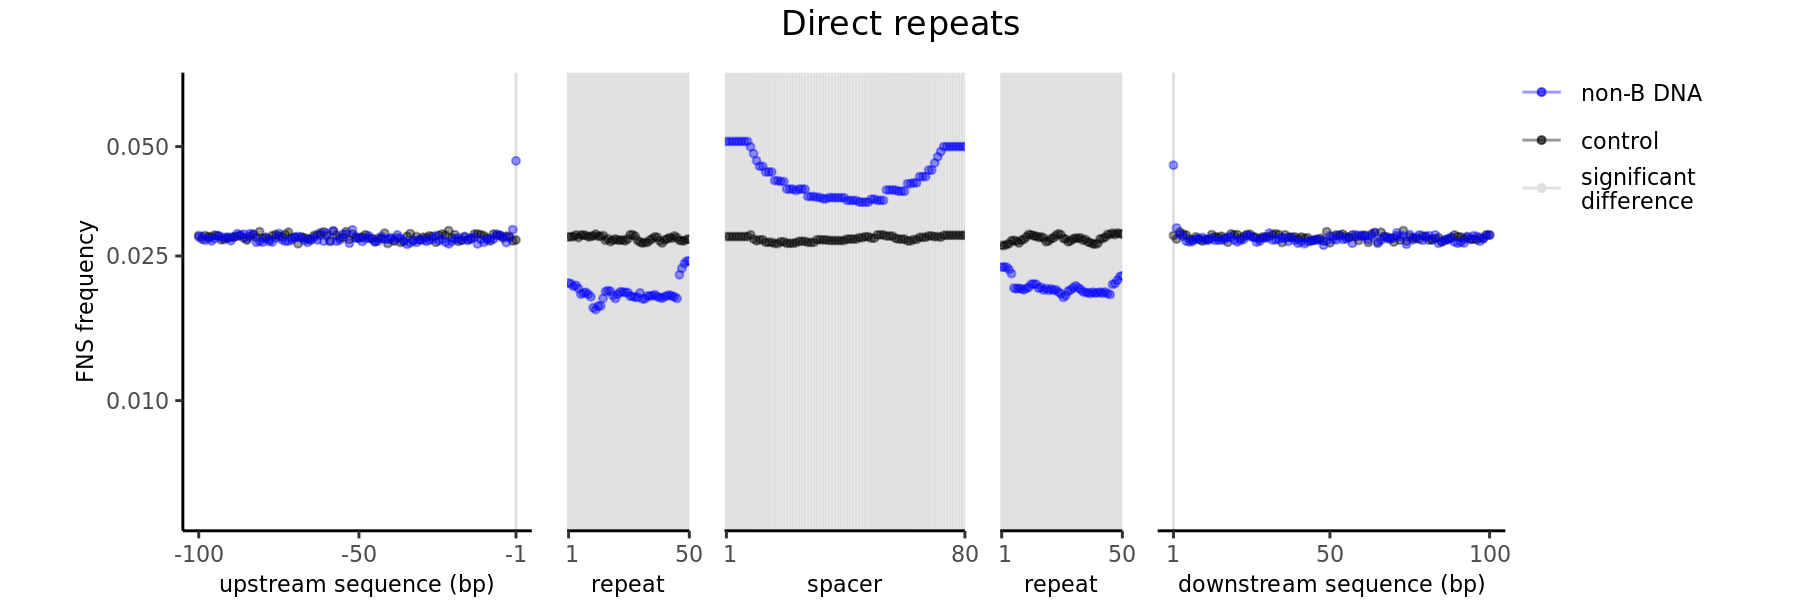

In [404]:
%%R -w 9 -h 3 --units in -r 200

csvfile <- read.csv('NCNRDirectRepeats.divergence.intersect.csv', header = TRUE)
csvfile <- csvfile[which(csvfile$snp_start != "NA"),]

LeftFlank <- table(csvfile[which(csvfile$snp_pos == "LeftFlank"),9])/101647
LeftRepeat <- table(csvfile[which(csvfile$snp_pos == "LeftRepeat"),9])/101647
#LeftRepeat <- table(c(csvfile[which(csvfile$snp_pos == "LeftRepeat"),9],0.00,1.00))/101647
Spacer <- table(csvfile[which(csvfile$snp_pos == "Spacer"),9])/76813
#Spacer <- table(c(csvfile[which(csvfile$snp_pos == "Spacer"),9],0.00,1.00))/77983
RightRepeat <- table(csvfile[which(csvfile$snp_pos == "RightRepeat"),9])/101647
#RightRepeat <- table(c(csvfile[which(csvfile$snp_pos == "RightRepeat"),9],0.00,1.00))/101647
RightFlank <- table(csvfile[which(csvfile$snp_pos == "RightFlank"),9])/101647

c_csvfile <- read.csv('NCNRDirectRepeats.divergence.shuffled.intersect.csv', header = TRUE)
c_csvfile <- c_csvfile[which(c_csvfile$snp_start != "NA"),]

c_LeftFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "LeftFlank"),9])/114543
c_LeftRepeat <- table(c_csvfile[which(c_csvfile$snp_pos == "LeftRepeat"),9])/114543
#ctrl_LeftRepeat <- table(c(ctrl_csvfile[which(ctrl_csvfile$snp_pos == "LeftRepeat"),9],0.00,1.00))/114543
c_Spacer <- table(c_csvfile[which(c_csvfile$snp_pos == "Spacer"),9])/87923
#ctrl_Spacer <- table(c(ctrl_csvfile[which(ctrl_csvfile$snp_pos == "Spacer"),9],0.00,1.00))/87923
c_RightRepeat <- table(c_csvfile[which(c_csvfile$snp_pos == "RightRepeat"),9])/114543
#ctrl_RightRepeat <- table(c(ctrl_csvfile[which(ctrl_csvfile$snp_pos == "RightRepeat"),9],0.00,1.00))/114543
c_RightFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "RightFlank"),9])/114543

cols <- c("non-B DNA"=rgb(t(col2rgb('blue')), alpha=100, maxColorValue = 255),
          "significant\ndifference"="grey88",
          "control"=rgb(t(col2rgb('black')), alpha=100, maxColorValue = 255))

load('DirectRepeats.divergence_motif_vs_control_IWTomics_center_0.01.RData')
load('DirectRepeats.divergence_motif_vs_control_IWTomics_left_0.01.RData')
load('DirectRepeats.divergence_motif_vs_control_IWTomics_right_0.01.RData')


LeftFlankDf <- cbind.data.frame(LeftFlank,c_LeftFlank,adj_pvalue_curve_left$significant)[,c(1,2,4,5)]
names(LeftFlankDf) <- c('Levels','Freq','C_Freq','Signif')
LeftFlankDf$Levels <- as.numeric(as.character(LeftFlankDf$Levels))
LeftFlankDf_cut <- LeftFlankDf[which(LeftFlankDf$Levels >= -100),]
LeftFlankDf_cut$Levels <- seq(-100,-1,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'LeftRepeat'),"significant"]
LeftRepeatDf <- cbind.data.frame(LeftRepeat,c_LeftRepeat,Signif)[,c(1,2,4,5)]
names(LeftRepeatDf) <- c('Levels','Freq','C_Freq','Signif')
LeftRepeatDf$Levels <- seq(1,50,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'Spacer'),"significant"]
SpacerDf <- cbind.data.frame(Spacer,c_Spacer,Signif)[,c(1,2,4,5)]
names(SpacerDf) <- c('Levels','Freq','C_Freq','Signif')
SpacerDf$Levels <- seq(1,80,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'RightRepeat'),"significant"]
RightRepeatDf <- cbind.data.frame(RightRepeat,c_RightRepeat,Signif)[,c(1,2,4,5)]
names(RightRepeatDf) <- c('Levels','Freq','C_Freq','Signif')
RightRepeatDf$Levels <- seq(1,50,1)

RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant)[,c(1,2,4,5)]
names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif')
RightFlankDf$Levels <- as.numeric(as.character(RightFlankDf$Levels))
RightFlankDf_cut <- RightFlankDf[which(RightFlankDf$Levels <= 100),]
RightFlankDf_cut$Levels <- seq(1,100,1)

p1 <- ggplot(LeftFlankDf_cut, aes(x=Levels)) + 
                            geom_vline(xintercept= LeftFlankDf_cut[which(LeftFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.title = element_text(size=8,family="sans"),
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.text.y = element_text(size=8,family="sans")) +
                            labs(y="FNS frequency", x="upstream sequence (bp)", size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_continuous(breaks =  c(-100,-50,-1), limits = c(-100,-1)) +
                            theme(plot.margin = unit(c(10,5,1,1), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07), breaks = c(0.010,0.025,0.050) )


p2 <- ggplot(LeftRepeatDf, aes(x=Levels)) +
                            geom_vline(xintercept= LeftRepeatDf[which(LeftRepeatDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8, family='sans'),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="repeat",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 50), limits = c(1, 50)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))


p3 <- ggplot(SpacerDf, aes(x=Levels)) +
                            geom_vline(xintercept= SpacerDf[which(SpacerDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() +  
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="spacer",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 80), limits = c(1, 80)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))


p4 <- ggplot(RightRepeatDf, aes(x=Levels)) +
                            geom_vline(xintercept= RightRepeatDf[which(RightRepeatDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="repeat",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 50), limits = c(1, 50)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))



p5 <- ggplot(RightFlankDf_cut, aes(x=Levels))+ 
                            geom_line(aes(x=0,y=0,colour="significant\ndifference")) +
                            geom_vline(xintercept= RightFlankDf_cut[which(RightFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq, col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank(),
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                legend.text=element_text(size=8,family="sans"),
                                legend.position=c(1.3, 0.9),) +
                            labs(x="downstream sequence (bp)",size=8, family='sans')+
                            scale_colour_manual(name="",values=cols, breaks = c('non-B DNA', 'control', 'significant\ndifference')) +
                            scale_x_continuous(breaks = c(1,50,100), limits = c(1,100)) +
                            theme(plot.margin = unit(c(10,80,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07)) +
                            guides(shape = guide_legend(order = 3))

grid.arrange(p1, p2, p3, p4, p5, ncol=5, 
            widths=unit(c(60,20,35,20,75), c("mm", "mm", "mm", "mm", "mm")),
            top=textGrob("Direct repeats",gp=gpar(fontsize=12,family="sans")))

g <- arrangeGrob(p1, p2, p3, p4, p5, ncol=5, 
            widths=unit(c(60,20,35,20,75), c("mm", "mm", "mm", "mm", "mm")),
            top=textGrob("Direct repeats",gp=gpar(fontsize=12,family="sans")))

ggsave(file='DR_Divergence.pdf',g, width=9, height=3, dpi=300)




In [331]:
%%R
repeats <- rbind(LeftRepeatDf,RightRepeatDf)
print(max(repeats$Ctrl_Freq/repeats$Freq))

print(max(SpacerDf$Freq/SpacerDf$Ctrl_Freq))

flanks <- rbind(LeftFlankDf,RightFlankDf)
print(max(flanks$Freq/flanks$Ctrl_Freq))


[1] 1.613434
[1] 1.799588
[1] 1.651534


```
python Permuting.py NCNRDirectRepeats.SGDP.intersect.csv NCNRDirectRepeats.SGDP.shuffled.intersect.csv 101647 77983 114543 87923 NCNRDirectRepeats.SGDP.permuted NCNRDirectRepeats.ctrl.SGDP.permuted

python Permuting.py NCNRDirectRepeats.divergence.intersect.csv NCNRDirectRepeats.divergence.shuffled.intersect.csv 101647 77983 114543 87923 NCNRDirectRepeats.divergence.permuted NCNRDirectRepeats.ctrl.divergence.permuted
```

## SubRates

```
python SubRates.py NCNRDirectRepeats.SGDP.intersect.csv NCNRDirectRepeats.SGDP.shuffled.intersect.csv NA LeftFlank -1,0 NCNRDirectRepeats.subrates.LeftFlank

python SubRates.py NCNRDirectRepeats.SGDP.intersect.csv NCNRDirectRepeats.SGDP.shuffled.intersect.csv NA RightFlank 1,2 NCNRDirectRepeats.subrates.RightFlank
```

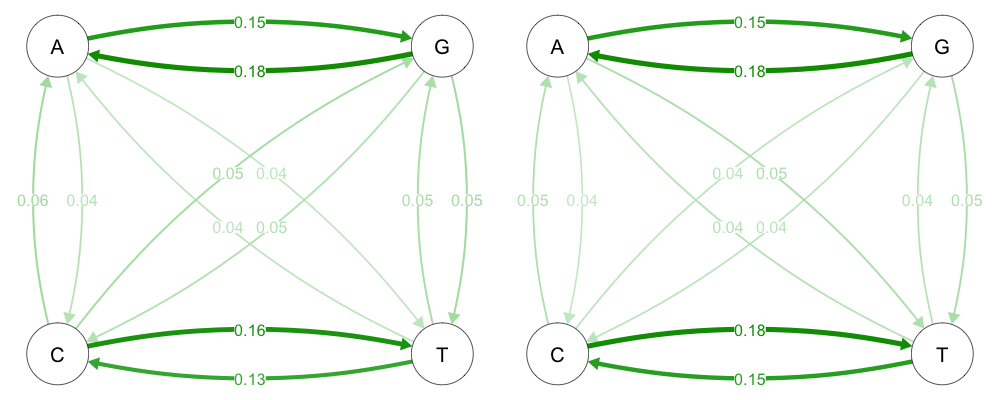

In [21]:
%%R -w 5 -h 2 --units in -r 200

dataset <- read.csv('NCNRDirectRepeats.subrates.LeftFlank', header=TRUE)

TvTi(dataset, '-1')

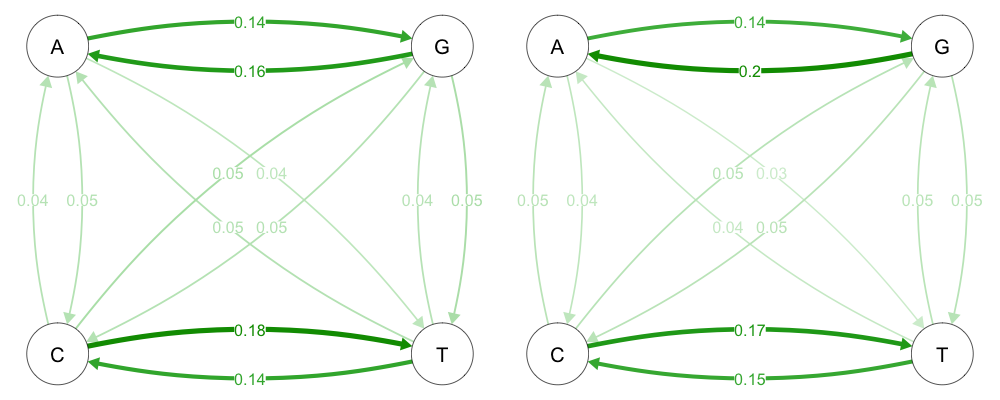

In [22]:
%%R -w 5 -h 2 --units in -r 200

dataset <- read.csv('NCNRDirectRepeats.subrates.RightFlank', header=TRUE)

TvTi(dataset, '1')

In [754]:
%%bash
# List SNPs at positions of interest and adjust coordinates for trinucleotide context
awk '{if ($5=="+") print $0 }' NCNRDirectRepeats.nooverlap.bed | awk 'BEGIN {OFS="\t"} {print $1, $6-2, $6+1}' | awk '{if ($2>0) print $0}'> NCNRDirectRepeats.trinucl.left.bed
awk '{if ($5=="+") print $0 }' NCNRDirectRepeats.shuffled.nooverlap.bed | awk 'BEGIN {OFS="\t"} {print $1, $6-2, $6+1}' | awk '{if ($2>0) print $0}'> NCNRDirectRepeats.shuffled.trinucl.left.bed

awk '{if ($5=="+") print $0 }' NCNRDirectRepeats.nooverlap.bed |awk 'BEGIN {OFS="\t"} {print $1, $7-1, $7+2}' > NCNRDirectRepeats.trinucl.right.bed
awk '{if ($5=="+") print $0 }' NCNRDirectRepeats.shuffled.nooverlap.bed |awk 'BEGIN {OFS="\t"} {print $1, $7-1, $7+2}' > NCNRDirectRepeats.shuffled.trinucl.right.bed


```
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRDirectRepeats.trinucl.left.bed > NCNRDirectRepeats.trinucl.left.fa
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRDirectRepeats.shuffled.trinucl.left.bed > NCNRDirectRepeats.shuffled.trinucl.left.fa

bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRDirectRepeats.trinucl.right.bed > NCNRDirectRepeats.trinucl.right.fa
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRDirectRepeats.shuffled.trinucl.right.bed > NCNRDirectRepeats.shuffled.trinucl.right.fa
```

In [82]:
## Match SNPs of interest with SNP dictionary to obtain substitution type
import itertools

Test = open('NCNRDirectRepeats.trinucl.left.fa', 'rt')
Control = open('NCNRDirectRepeats.shuffled.trinucl.left.fa', 'rt')

permutations = itertools.permutations(['A','T','G','C'], 2)
rows = []
for permutation in permutations:
    rows.append(trinucl_test(snpdict, Test, Control, permutation[0], permutation[1]))
    Test.seek(0)
    Control.seek(0)
    
colnames = ['ref','alt','test freq','ctrl freq', 'odds ratio', 'pvalue']
trinucl_df = pd.DataFrame(data=rows, columns=colnames)

trinucl_df = trinucl_df[trinucl_df['test freq'] != 'NA']

p_adjusted = multipletests(trinucl_df.pvalue, alpha=0.05, method='bonferroni')

trinucl_df['Adj. p-val'] = p_adjusted[1] 
del trinucl_df['pvalue']
print(trinucl_df)


   ref alt  test freq  ctrl freq  odds ratio    Adj. p-val
0    A   T   0.004865   0.002302    2.113806  8.471513e-07
1    A   G   0.019496   0.007192    2.710610  8.092278e-41
2    A   C   0.005561   0.001826    3.044786  1.488928e-12
3    T   A   0.004722   0.002034    2.321302  3.405225e-08
4    T   G   0.006329   0.002006    3.155983  3.747937e-17
5    T   C   0.016275   0.006876    2.366987  3.367158e-28
6    G   A   0.026541   0.013800    1.923239  6.732256e-20
7    G   T   0.008502   0.003684    2.307924  1.044598e-09
8    G   C   0.007994   0.003022    2.645707  1.693069e-11
9    C   A   0.009449   0.003514    2.689176  9.422808e-14
10   C   T   0.026797   0.013371    2.004108  1.135394e-21
11   C   G   0.008274   0.002921    2.833000  6.272642e-13


/home/wilfried/conda/wil_works/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [83]:
## Match SNPs of interest with SNP dictionary to obtain substitution type
import itertools

Test = open('NCNRDirectRepeats.trinucl.right.fa', 'rt')
Control = open('NCNRDirectRepeats.shuffled.trinucl.right.fa', 'rt')

permutations = itertools.permutations(['A','T','G','C'], 2)
rows = []
for permutation in permutations:
    rows.append(trinucl_test(snpdict, Test, Control, permutation[0], permutation[1]))
    Test.seek(0)
    Control.seek(0)
    
colnames = ['ref','alt','test freq','ctrl freq', 'odds ratio', 'pvalue']
trinucl_df = pd.DataFrame(data=rows, columns=colnames)

trinucl_df = trinucl_df[trinucl_df['test freq'] != 'NA']

p_adjusted = multipletests(trinucl_df.pvalue, alpha=0.05, method='bonferroni')

trinucl_df['Adj. p-val'] = p_adjusted[1] 
del trinucl_df['pvalue']
print(trinucl_df)


   ref alt  test freq  ctrl freq  odds ratio    Adj. p-val
0    A   T   0.005083   0.001763    2.882834  4.768641e-11
1    A   G   0.017263   0.006427    2.686132  1.048246e-36
2    A   C   0.005531   0.002066    2.677439  5.115663e-12
3    T   A   0.005321   0.001907    2.790446  1.520816e-11
4    T   G   0.005681   0.002198    2.584414  2.118617e-11
5    T   C   0.018313   0.006855    2.671584  1.630973e-37
6    G   A   0.025574   0.014431    1.772158  4.436405e-15
7    G   T   0.008619   0.003755    2.295582  1.064562e-09
8    G   C   0.006968   0.003420    2.037572  3.819944e-06
9    C   A   0.006805   0.003376    2.015793  4.946668e-06
10   C   T   0.027815   0.012964    2.145585  1.249274e-26
11   C   G   0.007993   0.003556    2.247667  8.089378e-09


/home/wilfried/conda/wil_works/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


# Mirror Repeats

## Recover Annotation
```
cat *_Mirror_Repeat.tsv > Mirror_Repeat.tsv
```

In [ ]:
inputfile = open('Mirror_Repeat.tsv', 'rt')
output = open('temp.tsv', 'w+')

for line in inputfile:
    array=line.strip().split('\t')
    for item in array:
        if item[:3] != 'chr':
            output.write(item+'\t')
        else:
            output.write('\n'+item)

inputfile = open('temp.tsv', 'rt')
output = open('MirrorRepeats.bed', 'w+')

for line in inputfile:
    if "Mirror_Repeat" in line:
        array = line.strip().split('\t')
        chrom, start, end = array[0].split('_')[:3]
        start = str(int(start)-1) # adapt to BED
        spacer = array[3]
        output.write(chrom+'\t'+start+'\t'+end+'\t'+spacer+'\n')


```
rm temp.tsv

bedtools intersect -a MirrorRepeats.bed -b ../LocalVariation/CRgenome.merged.bed -v > NCNRMirrorRepeats.bed

awk '{if ($3-$2<=100) print $0}' NCNRMirrorRepeats.bed > NCNR.MirrorRepeats.100threshold.bed

bedtools sort -i NCNR.MirrorRepeats.100threshold.bed > NCNR.MirrorRepeats.100threshold.sorted.bed
```

## Create Flanks
```
paste NCNR.MirrorRepeats.100threshold.sorted.bed  <(bedtools slop -i NCNR.MirrorRepeats.100threshold.sorted.bed -g hg19.genome -b 2000) | awk '{print $1 "\t" $6 "\t" $7 "\t" $3-$2 "\t+\t" $2 "\t" $3 "\t" $4}' > NCNRMirrorRepeats.flanked.bed
```

## Create Controls
```
cut -f 1-3 NCNR.MirrorRepeats.100threshold.sorted.bed > temp_MR
cat temp_MR gaps.bed ../LocalVariation/CRgenome.sorted.bed > exclude_MR.bed #GAPS FROM UCSC
bedtools shuffle -i NCNR.MirrorRepeats.100threshold.sorted.bed -excl exclude_MR.bed -g hg19.genome -chrom -f 0 -noOverlapping > temp_MR
bedtools sort -i temp_MR > NCNRMR.shuffled.bed
paste NCNRMR.shuffled.bed  <(bedtools slop -i NCNRMR.shuffled.bed -g hg19.genome -b 2000) | awk '{print $1 "\t" $6 "\t" $7 "\t" $3-$2+1 "\t+\t" $2 "\t" $3 "\t" $4}' > NCNRMirrorRepeats.shuffled.flanked.bed
```

## Remove Overlaps
```
python Locuschoice.py NCNRMirrorRepeats.flanked.bed NCNRMirrorRepeats.nooverlap.bed
python Locuschoice.py NCNRMirrorRepeats.shuffled.flanked.bed NCNRMirrorRepeats.shuffled.nooverlap.bed
```

## Split Repeats, Spacer, and Flanks
```
python Split.py NCNRMirrorRepeats
>117193 Loci
>4832 ZeroSpacers
117193 - 4832 = 112361

python Split.py NCNRMirrorRepeats.shuffled
>120967 Loci
>4822 ZeroSpacers
120967 - 4822 = 116145

#bedtools getfasta -fi hg19.fa -bed NCNRMirrorRepeats.split.bed -bedOut > NCNRMirrorRepeats.split.fa.bed

#bedtools getfasta -fi hg19.fa -bed NCNRMirrorRepeats.shuffled.split.bed -bedOut > NCNRMirrorRepeats.shuffled.split.fa.bed
```

## Intersect annotations with variation datasets
```
bedtools intersect -wa -wb -a NCNRMirrorRepeats.split.bed -b ../SGDP/WholeSGDPsnps.bed -loj > NCNRMirrorRepeats.SGDP.intersect
bedtools intersect -wa -wb -a NCNRMirrorRepeats.split.bed -b ../LocalVariation/divergence.bed -loj> NCNRMirrorRepeats.divergence.intersect

bedtools intersect -wa -wb -a NCNRMirrorRepeats.shuffled.split.bed -b ../SGDP/WholeSGDPsnps.bed -loj> NCNRMirrorRepeats.SGDP.shuffled.intersect
bedtools intersect -wa -wb -a NCNRMirrorRepeats.shuffled.split.bed -b ../LocalVariation/divergence.bed -loj> NCNRMirrorRepeats.divergence.shuffled.intersect


python RelativePositions_MirrorRepeats.py NCNRMirrorRepeats.SGDP.intersect
python RelativePositions_MirrorRepeats.py NCNRMirrorRepeats.divergence.intersect
python RelativePositions_MirrorRepeats.py NCNRMirrorRepeats.SGDP.shuffled.intersect
python RelativePositions_MirrorRepeats.py NCNRMirrorRepeats.divergence.shuffled.intersect
```

## Plot Results

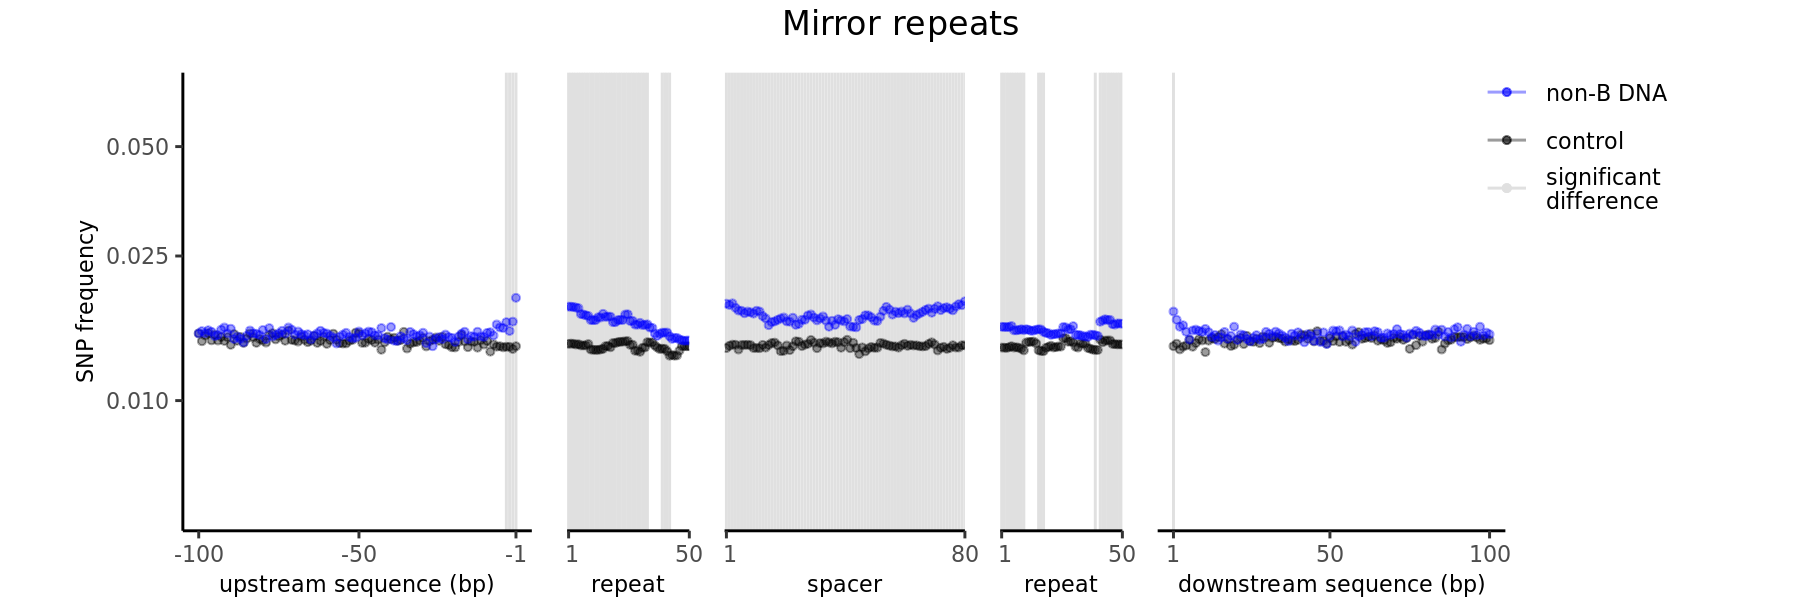

In [405]:
%%R -w 9 -h 3 --units in -r 200

csvfile <- read.csv('NCNRMirrorRepeats.SGDP.intersect.csv', header = TRUE)
csvfile <- csvfile[which(csvfile$snp_start != "NA"),]

LeftFlank <- table(csvfile[which(csvfile$snp_pos == "LeftFlank"),9])/117193
LeftRepeat <- table(csvfile[which(csvfile$snp_pos == "LeftRepeat"),9])/117193
#LeftRepeat <- table(c(csvfile[which(csvfile$snp_pos == "LeftRepeat"),9],0.00,1.00))/117193
Spacer <- table(csvfile[which(csvfile$snp_pos == "Spacer"),9])/112361
#Spacer <- table(c(csvfile[which(csvfile$snp_pos == "Spacer"),9],0.00,1.00))/112361
RightRepeat <- table(csvfile[which(csvfile$snp_pos == "RightRepeat"),9])/117193
#RightRepeat <- table(c(csvfile[which(csvfile$snp_pos == "RightRepeat"),9],0.00,1.00))/117193
RightFlank <- table(csvfile[which(csvfile$snp_pos == "RightFlank"),9])/117193

c_csvfile <- read.csv('NCNRMirrorRepeats.SGDP.shuffled.intersect.csv', header = TRUE)
c_csvfile <- c_csvfile[which(c_csvfile$snp_start != "NA"),]

c_LeftFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "LeftFlank"),9])/120967
c_LeftRepeat <- table(c_csvfile[which(c_csvfile$snp_pos == "LeftRepeat"),9])/120967
#c_LeftRepeat <- table(c(ctrl_csvfile[which(ctrl_csvfile$snp_pos == "LeftRepeat"),9],0.00,1.00))/120967
c_Spacer <- table(c_csvfile[which(c_csvfile$snp_pos == "Spacer"),9])/116145
#c_Spacer <- table(c(c_csvfile[which(ctrl_csvfile$snp_pos == "Spacer"),9],0.00,1.00))/116145
c_RightRepeat <- table(c_csvfile[which(c_csvfile$snp_pos == "RightRepeat"),9])/120967
#c_RightRepeat <- table(c(c_csvfile[which(ctrl_csvfile$snp_pos == "RightRepeat"),9],0.00,1.00))/120967
c_RightFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "RightFlank"),9])/120967

cols <- c("non-B DNA"=rgb(t(col2rgb('blue')), alpha=100, maxColorValue = 255),
          "significant\ndifference"="grey88",
          "control"=rgb(t(col2rgb('black')), alpha=100, maxColorValue = 255))

load('MirrorRepeats.SGDP_motif_vs_control_IWTomics_center_0.01.RData')
load('MirrorRepeats.SGDP_motif_vs_control_IWTomics_left_0.01.RData')
load('MirrorRepeats.SGDP_motif_vs_control_IWTomics_right_0.01.RData')

LeftFlankDf <- cbind.data.frame(LeftFlank,c_LeftFlank,adj_pvalue_curve_left$significant)[,c(1,2,4,5)]
names(LeftFlankDf) <- c('Levels','Freq','C_Freq','Signif')
LeftFlankDf$Levels <- as.numeric(as.character(LeftFlankDf$Levels))
LeftFlankDf_cut <- LeftFlankDf[which(LeftFlankDf$Levels >= -100),]
LeftFlankDf_cut$Levels <- seq(-100,-1,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'LeftRepeat'),"significant"]
LeftRepeatDf <- cbind.data.frame(LeftRepeat,c_LeftRepeat,Signif)[,c(1,2,4,5)]
names(LeftRepeatDf) <- c('Levels','Freq','C_Freq','Signif')
LeftRepeatDf$Levels <- seq(1,50,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'Spacer'),"significant"]
SpacerDf <- cbind.data.frame(Spacer,c_Spacer,Signif)[,c(1,2,4,5)]
names(SpacerDf) <- c('Levels','Freq','C_Freq','Signif')
SpacerDf$Levels <- seq(1,80,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'RightRepeat'),"significant"]
RightRepeatDf <- cbind.data.frame(RightRepeat,c_RightRepeat,Signif)[,c(1,2,4,5)]
names(RightRepeatDf) <- c('Levels','Freq','C_Freq','Signif')
RightRepeatDf$Levels <- seq(1,50,1)

RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant)[,c(1,2,4,5)]
names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif')
RightFlankDf$Levels <- as.numeric(as.character(RightFlankDf$Levels))
RightFlankDf_cut <- RightFlankDf[which(RightFlankDf$Levels <= 100),]
RightFlankDf_cut$Levels <- seq(1,100,1)

p1 <- ggplot(LeftFlankDf_cut, aes(x=Levels)) + 
                            geom_vline(xintercept= LeftFlankDf_cut[which(LeftFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.title = element_text(size=8,family="sans"),
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.text.y = element_text(size=8,family="sans")) +
                            labs(y="SNP frequency", x="upstream sequence (bp)", size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_continuous(breaks =  c(-100,-50,-1), limits = c(-100,-1)) +
                            theme(plot.margin = unit(c(10,5,1,1), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07), breaks = c(0.010,0.025,0.050) )


p2 <- ggplot(LeftRepeatDf, aes(x=Levels)) +
                            geom_vline(xintercept= LeftRepeatDf[which(LeftRepeatDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8, family='sans'),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="repeat",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 50), limits = c(1, 50)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))


p3 <- ggplot(SpacerDf, aes(x=Levels)) +
                            geom_vline(xintercept= SpacerDf[which(SpacerDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() +  
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="spacer",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 80), limits = c(1, 80)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))


p4 <- ggplot(RightRepeatDf, aes(x=Levels)) +
                            geom_vline(xintercept= RightRepeatDf[which(RightRepeatDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="repeat",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 50), limits = c(1, 50)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))



p5 <- ggplot(RightFlankDf_cut, aes(x=Levels))+ 
                            geom_line(aes(x=0,y=0,colour="significant\ndifference")) +
                            geom_vline(xintercept= RightFlankDf_cut[which(RightFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq, col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank(),
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                legend.text=element_text(size=8,family="sans"),
                                legend.position=c(1.2, 0.9),) +
                            labs(x="downstream sequence (bp)",size=8, family='sans')+
                            scale_colour_manual(name="",values=cols, breaks = c('non-B DNA', 'control', 'significant\ndifference')) +
                            scale_x_continuous(breaks = c(1,50,100), limits = c(1,100)) +
                            theme(plot.margin = unit(c(10,80,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07)) +
                            guides(shape = guide_legend(order = 3))



grid.arrange(p1, p2, p3, p4, p5, ncol=5, 
            widths=unit(c(60,20,35,20,75), c("mm", "mm", "mm", "mm", "mm")),
            top=textGrob("Mirror repeats",gp=gpar(fontsize=12,family="sans")))

g <- arrangeGrob(p1, p2, p3, p4, p5, ncol=5, 
            widths=unit(c(60,20,35,20,75), c("mm", "mm", "mm", "mm", "mm")),
            top=textGrob("Mirror repeats",gp=gpar(fontsize=12,family="sans")))

ggsave(file='MR_SNP.pdf',g, width=9, height=3, dpi=300)


In [432]:
%%R
min(adj_pvalue_curve_left[which(adj_pvalue_curve_left$significant == "TRUE"),"snp_coord"])

[1] -4


In [433]:
%%R
max(adj_pvalue_curve_right[which(adj_pvalue_curve_right$significant == "TRUE"),"snp_coord"])


[1] 1


In [434]:
%%R
repeats <- rbind(LeftRepeatDf,RightRepeatDf)
print(max(repeats$Ctrl_Freq/repeats$Freq))
print(max(repeats$Freq/repeats$Ctrl_Freq))

print(max(SpacerDf$Freq/SpacerDf$Ctrl_Freq))

flanks <- rbind(LeftFlankDf,RightFlankDf)
print(max(flanks$Freq/flanks$Ctrl_Freq))


[1] 1
[1] 1.266281
[1] 1.325276
[1] 1.35934


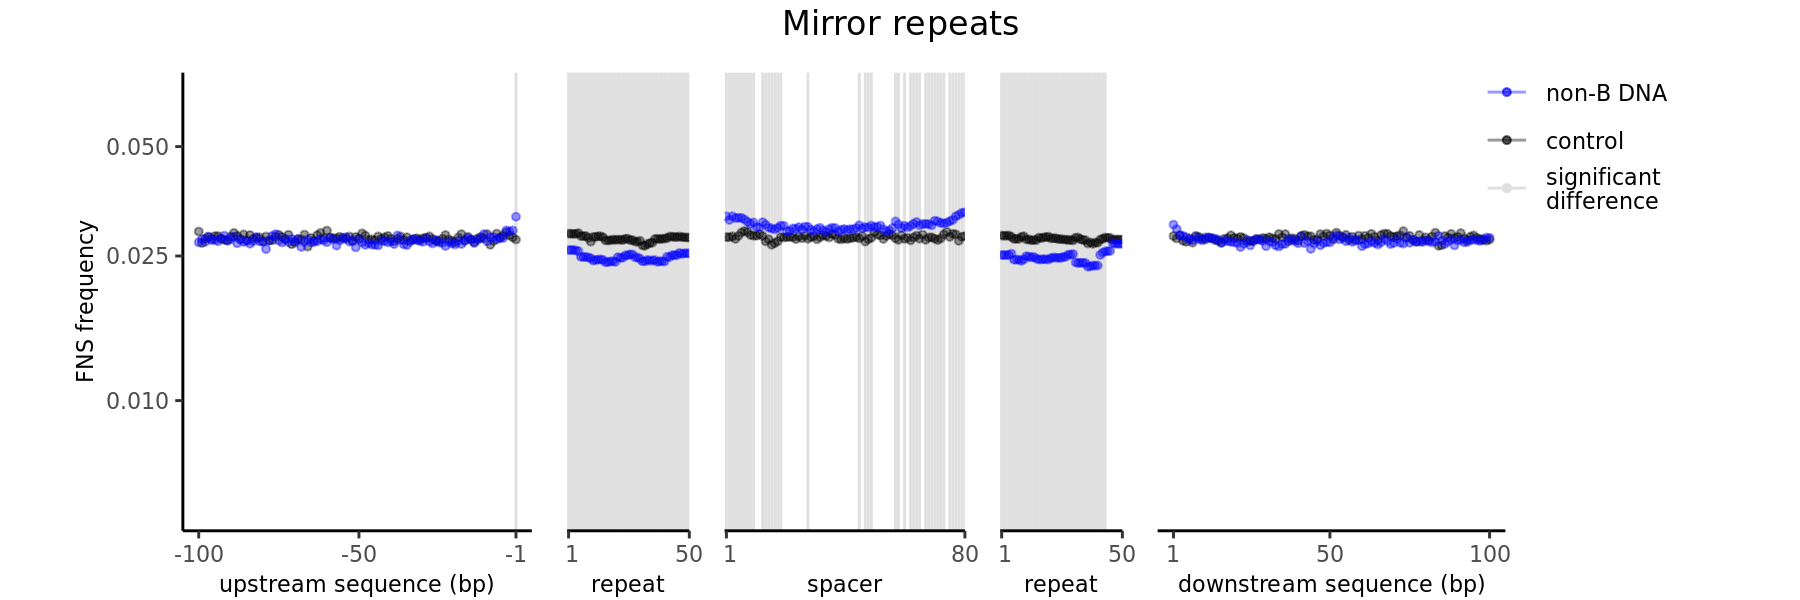

In [406]:
%%R -w 9 -h 3 --units in -r 200

csvfile <- read.csv('NCNRMirrorRepeats.divergence.intersect.csv', header = TRUE)
csvfile <- csvfile[which(csvfile$snp_start != "NA"),]

LeftFlank <- table(csvfile[which(csvfile$snp_pos == "LeftFlank"),9])/117193
LeftRepeat <- table(csvfile[which(csvfile$snp_pos == "LeftRepeat"),9])/117193
#LeftRepeat <- table(c(csvfile[which(csvfile$snp_pos == "LeftRepeat"),9],0.00,1.00))/117193
Spacer <- table(csvfile[which(csvfile$snp_pos == "Spacer"),9])/112361
#Spacer <- table(c(csvfile[which(csvfile$snp_pos == "Spacer"),9],0.00,1.00))/112361
RightRepeat <- table(csvfile[which(csvfile$snp_pos == "RightRepeat"),9])/117193
#RightRepeat <- table(c(csvfile[which(csvfile$snp_pos == "RightRepeat"),9],0.00,1.00))/117193
RightFlank <- table(csvfile[which(csvfile$snp_pos == "RightFlank"),9])/117193

c_csvfile <- read.csv('NCNRMirrorRepeats.divergence.shuffled.intersect.csv', header = TRUE)
c_csvfile <- c_csvfile[which(c_csvfile$snp_start != "NA"),]

c_LeftFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "LeftFlank"),9])/120967
c_LeftRepeat <- table(c_csvfile[which(c_csvfile$snp_pos == "LeftRepeat"),9])/120967
#c_LeftRepeat <- table(c(ctrl_csvfile[which(ctrl_csvfile$snp_pos == "LeftRepeat"),9],0.00,1.00))/120967
c_Spacer <- table(c_csvfile[which(c_csvfile$snp_pos == "Spacer"),9])/116145
#c_Spacer <- table(c(c_csvfile[which(ctrl_csvfile$snp_pos == "Spacer"),9],0.00,1.00))/116145
c_RightRepeat <- table(c_csvfile[which(c_csvfile$snp_pos == "RightRepeat"),9])/120967
#c_RightRepeat <- table(c(c_csvfile[which(ctrl_csvfile$snp_pos == "RightRepeat"),9],0.00,1.00))/120967
c_RightFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "RightFlank"),9])/120967

cols <- c("non-B DNA"=rgb(t(col2rgb('blue')), alpha=100, maxColorValue = 255),
          "significant\ndifference"="grey88",
          "control"=rgb(t(col2rgb('black')), alpha=100, maxColorValue = 255))

load('MirrorRepeats.divergence_motif_vs_control_IWTomics_center_0.01.RData')
load('MirrorRepeats.divergence_motif_vs_control_IWTomics_left_0.01.RData')
load('MirrorRepeats.divergence_motif_vs_control_IWTomics_right_0.01.RData')

LeftFlankDf <- cbind.data.frame(LeftFlank,c_LeftFlank,adj_pvalue_curve_left$significant)[,c(1,2,4,5)]
names(LeftFlankDf) <- c('Levels','Freq','C_Freq','Signif')
LeftFlankDf$Levels <- as.numeric(as.character(LeftFlankDf$Levels))
LeftFlankDf_cut <- LeftFlankDf[which(LeftFlankDf$Levels >= -100),]
LeftFlankDf_cut$Levels <- seq(-100,-1,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'LeftRepeat'),"significant"]
LeftRepeatDf <- cbind.data.frame(LeftRepeat,c_LeftRepeat,Signif)[,c(1,2,4,5)]
names(LeftRepeatDf) <- c('Levels','Freq','C_Freq','Signif')
LeftRepeatDf$Levels <- seq(1,50,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'Spacer'),"significant"]
SpacerDf <- cbind.data.frame(Spacer,c_Spacer,Signif)[,c(1,2,4,5)]
names(SpacerDf) <- c('Levels','Freq','C_Freq','Signif')
SpacerDf$Levels <- seq(1,80,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'RightRepeat'),"significant"]
RightRepeatDf <- cbind.data.frame(RightRepeat,c_RightRepeat,Signif)[,c(1,2,4,5)]
names(RightRepeatDf) <- c('Levels','Freq','C_Freq','Signif')
RightRepeatDf$Levels <- seq(1,50,1)

RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant)[,c(1,2,4,5)]
names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif')
RightFlankDf$Levels <- as.numeric(as.character(RightFlankDf$Levels))
RightFlankDf_cut <- RightFlankDf[which(RightFlankDf$Levels <= 100),]
RightFlankDf_cut$Levels <- seq(1,100,1)

p1 <- ggplot(LeftFlankDf_cut, aes(x=Levels)) + 
                            geom_vline(xintercept= LeftFlankDf_cut[which(LeftFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.title = element_text(size=8,family="sans"),
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.text.y = element_text(size=8,family="sans")) +
                            labs(y="FNS frequency", x="upstream sequence (bp)", size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_continuous(breaks =  c(-100,-50,-1), limits = c(-100,-1)) +
                            theme(plot.margin = unit(c(10,5,1,1), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07), breaks = c(0.010,0.025,0.050) )


p2 <- ggplot(LeftRepeatDf, aes(x=Levels)) +
                            geom_vline(xintercept= LeftRepeatDf[which(LeftRepeatDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8, family='sans'),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="repeat",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 50), limits = c(1, 50)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))


p3 <- ggplot(SpacerDf, aes(x=Levels)) +
                            geom_vline(xintercept= SpacerDf[which(SpacerDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() +  
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="spacer",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 80), limits = c(1, 80)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))


p4 <- ggplot(RightRepeatDf, aes(x=Levels)) +
                            geom_vline(xintercept= RightRepeatDf[which(RightRepeatDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="repeat",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 50), limits = c(1, 50)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))



p5 <- ggplot(RightFlankDf_cut, aes(x=Levels))+ 
                            geom_line(aes(x=0,y=0,colour="significant\ndifference")) +
                            geom_vline(xintercept= RightFlankDf_cut[which(RightFlankDf_cut$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq, col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank(),
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                legend.text=element_text(size=8,family="sans"),
                                legend.position=c(1.2, 0.9),) +
                            labs(x="downstream sequence (bp)",size=8, family='sans')+
                            scale_colour_manual(name="",values=cols, breaks = c('non-B DNA', 'control', 'significant\ndifference')) +
                            scale_x_continuous(breaks = c(1,50,100), limits = c(1,100)) +
                            theme(plot.margin = unit(c(10,80,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07)) +
                            guides(shape = guide_legend(order = 3))



grid.arrange(p1, p2, p3, p4, p5, ncol=5, 
            widths=unit(c(60,20,35,20,75), c("mm", "mm", "mm", "mm", "mm")),
            top=textGrob("Mirror repeats",gp=gpar(fontsize=12,family="sans")))

g <- arrangeGrob(p1, p2, p3, p4, p5, ncol=5, 
            widths=unit(c(60,20,35,20,75), c("mm", "mm", "mm", "mm", "mm")),
            top=textGrob("Mirror repeats",gp=gpar(fontsize=12,family="sans")))

ggsave(file='MR_Divergence.pdf',g, width=9, height=3, dpi=300)


In [429]:
%%R
min(adj_pvalue_curve_left[which(adj_pvalue_curve_left$significant == "TRUE"),"snp_coord"])

[1] -250


In [430]:
%%R
max(adj_pvalue_curve_right[which(adj_pvalue_curve_right$significant == "TRUE"),"snp_coord"])


[1] 438


In [689]:
%%R
repeats <- rbind(LeftRepeatDf,RightRepeatDf)
print(max(repeats$Ctrl_Freq/repeats$Freq))

print(max(SpacerDf$Freq/SpacerDf$Ctrl_Freq))

flanks <- rbind(LeftFlankDf,RightFlankDf)
print(max(flanks$Freq/flanks$Ctrl_Freq))


[1] 1.197534
[1] 1.169851
[1] 1.118655


```
python Permuting.py NCNRMirrorRepeats.SGDP.intersect.csv NCNRMirrorRepeats.SGDP.shuffled.intersect.csv 117193 120967 NCNRMirrorRepeats.SGDP.permuted NCNRMirrorRepeats.ctrl.SGDP.permuted

python Permuting.py NCNRMirrorRepeats.divergence.intersect.csv NCNRMirrorRepeats.divergence.shuffled.intersect.csv 117193 120967 NCNRMirrorRepeats.divergence.permuted NCNRMirrorRepeats.ctrl.divergence.permuted
```

## SubRates

```
python SubRates.py NCNRMirrorRepeats.SGDP.intersect.csv NCNRMirrorRepeats.SGDP.shuffled.intersect.csv NA LeftFlank -1,0 NCNRMirrorRepeats.subrates.LeftFlank

python SubRates.py NCNRMirrorRepeats.SGDP.intersect.csv NCNRMirrorRepeats.SGDP.shuffled.intersect.csv NA RightFlank 1,2 NCNRMirrorRepeats.subrates.RightFlank
```

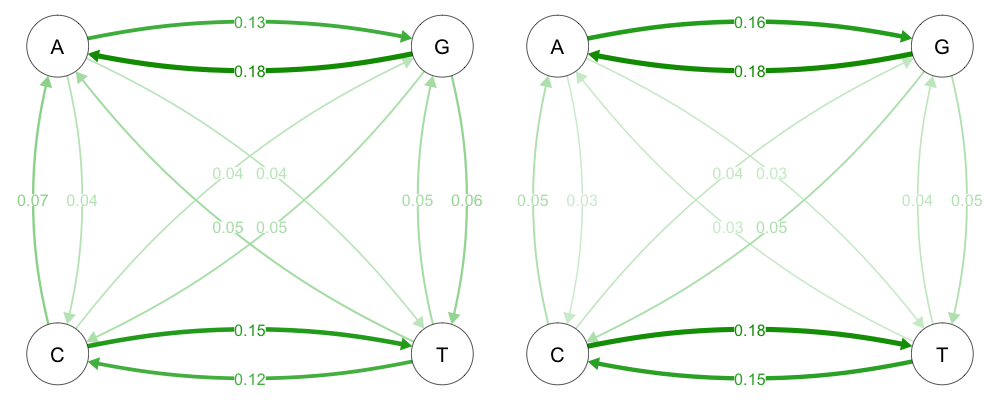

In [23]:
%%R -w 5 -h 2 --units in -r 200

dataset <- read.csv('NCNRMirrorRepeats.subrates.LeftFlank', header=TRUE)

TvTi(dataset, '-1')

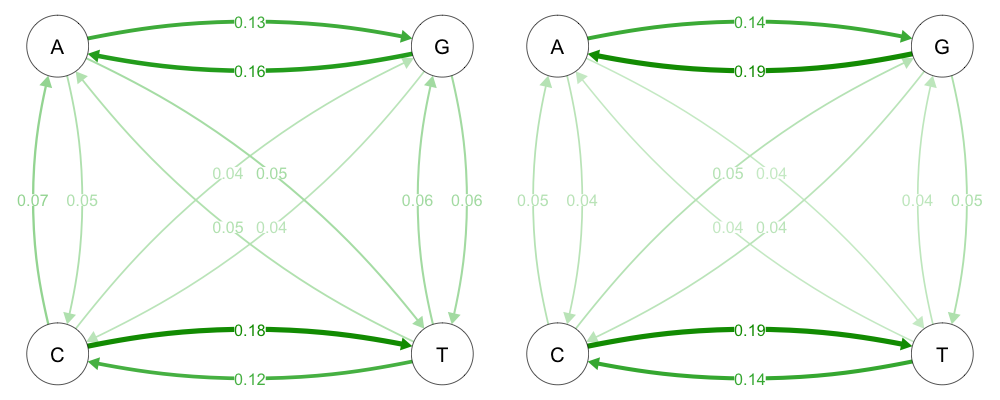

In [24]:
%%R -w 5 -h 2 --units in -r 200

dataset <- read.csv('NCNRMirrorRepeats.subrates.RightFlank', header=TRUE)

TvTi(dataset, '1')

In [757]:
%%bash
# List SNPs at positions of interest and adjust coordinates for trinucleotide context
awk '{if ($5=="+") print $0 }' NCNRMirrorRepeats.nooverlap.bed | awk 'BEGIN {OFS="\t"} {print $1, $6-2, $6+1}' | awk '{if ($2>0) print $0}'> NCNRMirrorRepeats.trinucl.left.bed
awk '{if ($5=="+") print $0 }' NCNRMirrorRepeats.shuffled.nooverlap.bed | awk 'BEGIN {OFS="\t"} {print $1, $6-2, $6+1}' | awk '{if ($2>0) print $0}'> NCNRMirrorRepeats.shuffled.trinucl.left.bed

awk '{if ($5=="+") print $0 }' NCNRMirrorRepeats.nooverlap.bed |awk 'BEGIN {OFS="\t"} {print $1, $7-1, $7+2}' > NCNRMirrorRepeats.trinucl.right.bed
awk '{if ($5=="+") print $0 }' NCNRMirrorRepeats.shuffled.nooverlap.bed |awk 'BEGIN {OFS="\t"} {print $1, $7-1, $7+2}' > NCNRMirrorRepeats.shuffled.trinucl.right.bed


```
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRMirrorRepeats.trinucl.left.bed > NCNRMirrorRepeats.trinucl.left.fa
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRMirrorRepeats.shuffled.trinucl.left.bed > NCNRMirrorRepeats.shuffled.trinucl.left.fa

bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRMirrorRepeats.trinucl.right.bed > NCNRMirrorRepeats.trinucl.right.fa
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRMirrorRepeats.shuffled.trinucl.right.bed > NCNRMirrorRepeats.shuffled.trinucl.right.fa
```

In [84]:
## Match SNPs of interest with SNP dictionary to obtain substitution type
import itertools

Test = open('NCNRMirrorRepeats.trinucl.left.fa', 'rt')
Control = open('NCNRMirrorRepeats.shuffled.trinucl.left.fa', 'rt')

permutations = itertools.permutations(['A','T','G','C'], 2)
rows = []
for permutation in permutations:
    rows.append(trinucl_test(snpdict, Test, Control, permutation[0], permutation[1]))
    Test.seek(0)
    Control.seek(0)
    
colnames = ['ref','alt','test freq','ctrl freq', 'odds ratio', 'pvalue']
trinucl_df = pd.DataFrame(data=rows, columns=colnames)

trinucl_df = trinucl_df[trinucl_df['test freq'] != 'NA']

p_adjusted = multipletests(trinucl_df.pvalue, alpha=0.05, method='bonferroni')

trinucl_df['Adj. p-val'] = p_adjusted[1] 
del trinucl_df['pvalue']
print(trinucl_df)


   ref alt  test freq  ctrl freq  odds ratio  Adj. p-val
0    A   T   0.002818   0.001644    1.714358    0.019305
1    A   G   0.008317   0.007262    1.145293    1.000000
2    A   C   0.002903   0.001530    1.897246    0.001466
3    T   A   0.003844   0.001738    2.211372    0.000005
4    T   G   0.003437   0.001868    1.840104    0.000894
5    T   C   0.007992   0.006932    1.152901    1.000000
6    G   A   0.016429   0.013229    1.241928    0.056488
7    G   T   0.005951   0.003501    1.700069    0.001276
8    G   C   0.004556   0.003671    1.240901    1.000000
9    C   A   0.006613   0.003551    1.862069    0.000044
10   C   T   0.014495   0.013065    1.109422    1.000000
11   C   G   0.003767   0.002815    1.338079    0.922136


/home/wilfried/conda/wil_works/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [85]:
## Match SNPs of interest with SNP dictionary to obtain substitution type
import itertools

Test = open('NCNRMirrorRepeats.trinucl.right.fa', 'rt')
Control = open('NCNRMirrorRepeats.shuffled.trinucl.right.fa', 'rt')

permutations = itertools.permutations(['A','T','G','C'], 2)
rows = []
for permutation in permutations:
    rows.append(trinucl_test(snpdict, Test, Control, permutation[0], permutation[1]))
    Test.seek(0)
    Control.seek(0)
    
colnames = ['ref','alt','test freq','ctrl freq', 'odds ratio', 'pvalue']
trinucl_df = pd.DataFrame(data=rows, columns=colnames)

trinucl_df = trinucl_df[trinucl_df['test freq'] != 'NA']

p_adjusted = multipletests(trinucl_df.pvalue, alpha=0.05, method='bonferroni')

trinucl_df['Adj. p-val'] = p_adjusted[1] 
del trinucl_df['pvalue']
print(trinucl_df)


   ref alt  test freq  ctrl freq  odds ratio  Adj. p-val
0    A   T   0.003471   0.001782    1.947833    0.000197
1    A   G   0.007901   0.006652    1.187795    0.637003
2    A   C   0.002932   0.002215    1.323514    0.837120
3    T   A   0.003085   0.001849    1.668635    0.019447
4    T   G   0.003492   0.001993    1.751756    0.001935
5    T   C   0.007659   0.006950    1.101994    1.000000
6    G   A   0.013832   0.014413    0.959721    1.000000
7    G   T   0.004886   0.003965    1.232274    1.000000
8    G   C   0.003440   0.003320    1.036277    1.000000
9    C   A   0.005683   0.003682    1.543603    0.022254
10   C   T   0.015813   0.014602    1.082982    1.000000
11   C   G   0.003718   0.003522    1.055885    1.000000


/home/wilfried/conda/wil_works/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


# 7. A-Phased Repeats

## Recover Annotation
```
cat *_A_Phased_Repeat.tsv > A_Phased_Repeat.tsv
```

In [ ]:
inputfile = open('A_Phased_Repeat.tsv', 'rt')
output = open('temp.tsv', 'w+')

for line in inputfile:
    array=line.strip().split('\t')
    for item in array:
        if item[:3] != 'chr':
            output.write(item+'\t')
        else:
            output.write('\n'+item)

inputfile = open('temp.tsv', 'rt')
output = open('APhasedRepeats.bed', 'w+')

for line in inputfile:
    if "A_Phased_Repeat" in line:
        array = line.strip().split('\t')
        chrom, start, end = array[0].split('_')[:3]
        start = str(int(start)-1) # adapt to BED
        spacer = array[3]
        output.write(chrom+'\t'+start+'\t'+end+'\t'+spacer+'\n')


# 7. A Phased Repeats


## 7.1 Retrieve Annotation


```
bedtools intersect -a APhasedRepeats.bed -b ../LocalVariation/CRgenome.merged.bed -v > NCNRAPhasedRepeats.bed

awk '{if ($3-$2<=100 && $4=="3") print $0}' NCNRAPhasedRepeats.bed  > NCNRAPhasedRepeats.100threshold.bed #also keeps loci with only 3 A-tracts


bedtools getfasta -fi hg19.fa -bed NCNRAPhasedRepeats.100threshold.bed > NCNR.APhasedRepeats.fa

cat NCNR.APhasedRepeats.fa | ./hay_faze.py --copyinput > NCNR.APhasedRepeats.split
```



In [14]:
infile = open('NCNR.APhasedRepeats.split', 'rt')
outfile =  open('NCNR.APhasedRepeats.split.bed', 'w+')

sections = ''
for line in infile:
    if line[:2] == '#>':
        array = line.strip().split(':')
        chrom = array[0][2:]
        start, end = array[1].split('-')
    elif line[0] != "#":
        array = line.strip().split('\t')
        sectionstart = int(array[1]) - int(start)
        sectionend = int(array[2]) - int(start)
        sections = sections+str(sectionstart)+'|'+str(sectionend)+','
        if array[2] == end:
            outfile.write(chrom+'\t'+start+'\t'+end+'\t'+sections+'\n')
            sections = ''
        

```
cut -f 1-3 NCNR.APhasedRepeats.split.bed > temp_APR
cat temp_APR gaps.bed ../LocalVariation/CRgenome.sorted.bed > exclude_APR.bed
bedtools shuffle -i NCNR.APhasedRepeats.split.bed -excl exclude_APR.bed -g hg19.genome -chrom -f 0 -noOverlapping > temp_APR
bedtools sort -i temp_APR > NCNRAPhasedRepeats.ctrl.bed
```




## 7.2 Create Flanks

```
paste NCNR.APhasedRepeats.split.bed  <(bedtools slop -i NCNR.APhasedRepeats.split.bed -g hg19.genome -b 2000) | awk '{print $1 "\t" $6 "\t" $7 "\t" $3-$2 "\t" "+" "\t" $2 "\t" $3 "\t" $4}' > NCNRAPhasedRepeats.flanked.bed


paste NCNRAPhasedRepeats.ctrl.bed  <(bedtools slop -i NCNRAPhasedRepeats.ctrl.bed -g hg19.genome -b 2000) | awk '{print $1 "\t" $6 "\t" $7 "\t" $3-$2 "\t" "+" "\t" $2 "\t" $3 "\t" $4}' > NCNRAPhasedRepeats.ctrl.flanked.bed

```

## 7.2 Pick non-overlaping windows

```
python Locuschoice.py NCNRAPhasedRepeats.flanked.bed NCNRAPhasedRepeats.nooverlap.bed
python Locuschoice.py NCNRAPhasedRepeats.ctrl.flanked.bed NCNRAPhasedRepeats.ctrl.nooverlap.bed
```

In [ ]:
#APhasedSections.py

import sys


infile = open(sys.argv[1], 'rt')
outfile = open(sys.argv[2], 'w+')


for line in infile:
    array = line.strip().split('\t')
    chrom, f_start, f_end, l_start, l_end = array[0], array[1],\
                array[2], array[5], array[6]
    
    sections = array[7].split(',')[:-1]
    section1 = sections[0].split('|')
    section2 = sections[1].split('|')
    section3 = sections[2].split('|')
    #print(sections)
    #print(section1)
    #break
    
    LeftFlankStart, LeftFlankEnd = f_start, l_start
    Tract1Start, Tract1End = str(int(l_start)+int(section1[0])), str(int(l_start)+int(section1[1]))
    Spacer1Start, Spacer1End = str(int(l_start)+int(section1[1])), str(int(l_start)+int(section2[0]))
    Tract2Start, Tract2End = str(int(l_start)+int(section2[0])), str(int(l_start)+int(section2[1]))
    Spacer2Start, Spacer2End = str(int(l_start)+int(section2[1])), str(int(l_start)+int(section3[0]))
    Tract3Start, Tract3End = str(int(l_start)+int(section3[0])), str(int(l_start)+int(section3[1]))
    RightFlankStart, RightFlankEnd = l_end, f_end
    
    outfile.write(chrom+'\t'+LeftFlankStart+'\t'+LeftFlankEnd+'\t+\tLeftFlank\n')
    outfile.write(chrom+'\t'+Tract1Start+'\t'+Tract1End+'\t+\tTract1\n')
    outfile.write(chrom+'\t'+Spacer1Start+'\t'+Spacer1End+'\t+\tSpacer1\n')
    outfile.write(chrom+'\t'+Tract2Start+'\t'+Tract2End+'\t+\tTract2\n')
    outfile.write(chrom+'\t'+Spacer2Start+'\t'+Spacer2End+'\t+\tSpacer2\n') 
    outfile.write(chrom+'\t'+Tract3Start+'\t'+Tract3End+'\t+\tTract3\n')
    outfile.write(chrom+'\t'+RightFlankStart+'\t'+RightFlankEnd+'\t+\tRightFlank\n')

    
    
    

```
python APhasedSections.py NCNRAPhasedRepeats.nooverlap.bed NCNRAPhasedRepeats.sections.bed
python APhasedSections.py NCNRAPhasedRepeats.ctrl.nooverlap.bed NCNRAPhasedRepeats.ctrl.sections.bed
```

## 7.3 Intersect annotations with variation datasets

```
bedtools intersect -wa -wb -a NCNRAPhasedRepeats.sections.bed -b ../SGDP/WholeSGDPsnps.bed -loj > NCNRAPhasedRepeats.SGDP.intersect
bedtools intersect -wa -wb -a NCNRAPhasedRepeats.sections.bed -b ../LocalVariation/divergence.bed -loj > NCNRAPhasedRepeats.divergence.intersect


bedtools intersect -wa -wb -a NCNRAPhasedRepeats.ctrl.sections.bed -b ../SGDP/WholeSGDPsnps.bed -loj > NCNRAPhasedRepeats.SGDP.ctrl.intersect
bedtools intersect -wa -wb -a NCNRAPhasedRepeats.ctrl.sections.bed -b ../LocalVariation/divergence.bed -loj > NCNRAPhasedRepeats.divergence.ctrl.intersect
```

## 7.4 Compute relative position of variants

```
python RelativePositions_APhasedR.py NCNRAPhasedRepeats.SGDP.intersect
python RelativePositions_APhasedR.py NCNRAPhasedRepeats.divergence.intersect

python RelativePositions_APhasedR.py NCNRAPhasedRepeats.SGDP.ctrl.intersect 
python RelativePositions_APhasedR.py NCNRAPhasedRepeats.divergence.ctrl.intersect
```

## 7.5 Plot Results

In [21]:
%%bash
wc -l NCNRAPhasedRepeats.nooverlap.bed 
wc -l NCNRAPhasedRepeats.ctrl.nooverlap.bed 

99583 NCNRAPhasedRepeats.nooverlap.bed
101267 NCNRAPhasedRepeats.ctrl.nooverlap.bed


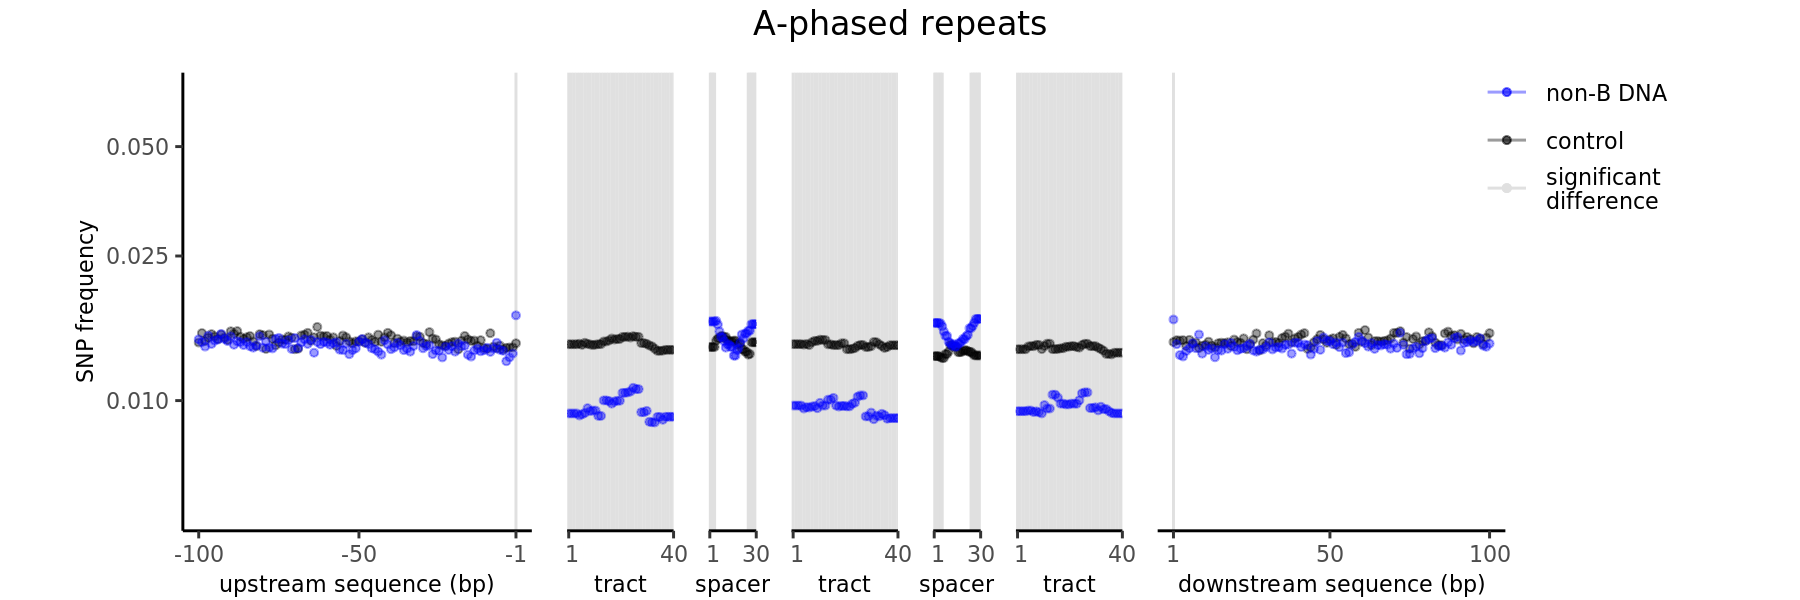

In [415]:
%%R -w 9 -h 3 --units in -r 200

#csvfile <- read.csv('NCNRAPhasedRepeats.SGDP.intersect.csv', header = TRUE)
csvfile <- csvfile[which(csvfile$snp_start != "NA"),]

LeftFlank <- table(csvfile[which(csvfile$snp_pos == "LeftFlank"),10])/99583 
tract1 <- table(csvfile[which(csvfile$snp_pos == "Tract1"),10])/99583 
spacer1 <- table(csvfile[which(csvfile$snp_pos == "Spacer1"),10])/99583 
tract2 <- table(csvfile[which(csvfile$snp_pos == "Tract2"),10])/99583 
spacer2 <- table(csvfile[which(csvfile$snp_pos == "Spacer2"),10])/99583 
tract3 <- table(csvfile[which(csvfile$snp_pos == "Tract3"),10])/99583 
RightFlank <- table(csvfile[which(csvfile$snp_pos == "RightFlank"),10])/99583 


#c_csvfile <- read.csv('NCNRAPhasedRepeats.SGDP.ctrl.intersect.csv', header = TRUE)
c_csvfile <- c_csvfile[which(c_csvfile$snp_start != "NA"),]

c_LeftFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "LeftFlank"),10])/101267 
c_tract1 <- table(c_csvfile[which(c_csvfile$snp_pos == "Tract1"),10])/101267 
c_spacer1 <- table(c_csvfile[which(c_csvfile$snp_pos == "Spacer1"),10])/101267 
c_tract2 <- table(c_csvfile[which(c_csvfile$snp_pos == "Tract2"),10])/101267 
c_spacer2 <- table(c_csvfile[which(c_csvfile$snp_pos == "Spacer2"),10])/101267 
c_tract3 <- table(c_csvfile[which(c_csvfile$snp_pos == "Tract3"),10])/101267 
c_RightFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "RightFlank"),10])/101267 


cols <- c("non-B DNA"=rgb(t(col2rgb('blue')), alpha=100, maxColorValue = 255),
          "significant\ndifference"="grey88",
          "control"=rgb(t(col2rgb('black')), alpha=100, maxColorValue = 255))

load('APhasedRepeats.SGDP_motif_vs_control_IWTomics_center_0.01.RData')
load('APhasedRepeats.SGDP_motif_vs_control_IWTomics_left_0.01.RData')
load('APhasedRepeats.SGDP_motif_vs_control_IWTomics_right_0.01.RData')


LeftFlankDf <- cbind.data.frame(LeftFlank,c_LeftFlank,adj_pvalue_curve_left$significant)[,c(1,2,4,5)]
names(LeftFlankDf) <- c('Levels','Freq','C_Freq','Signif')
LeftFlankDf$Levels <- as.numeric(as.character(LeftFlankDf$Levels))
LeftFlankDf_cut <- LeftFlankDf[which(LeftFlankDf$Levels >= -100),]
LeftFlankDf_cut$Levels <- seq(-100,-1,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'Tract1'),"significant"]
tract1Df <- cbind.data.frame(tract1,c_tract1,Signif)[,c(1,2,4,5)]
names(tract1Df) <- c('Levels','Freq','C_Freq','Signif')
tract1Df$Levels <- seq(1,40,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'Spacer1'),"significant"]
spacer1Df <- cbind.data.frame(spacer1,c_spacer1,Signif)[,c(1,2,4,5)]
names(spacer1Df) <- c('Levels','Freq','C_Freq','Signif')
spacer1Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'Tract2'),"significant"]
tract2Df <- cbind.data.frame(tract2,c_tract2,Signif)[,c(1,2,4,5)]
names(tract2Df) <- c('Levels','Freq','C_Freq','Signif')
tract2Df$Levels <- seq(1,40,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'Spacer2'),"significant"]
spacer2Df <- cbind.data.frame(spacer2,c_spacer2,Signif)[,c(1,2,4,5)]
names(spacer2Df) <- c('Levels','Freq','C_Freq','Signif')
spacer2Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'Tract3'),"significant"]
tract3Df <- cbind.data.frame(tract3,c_tract3,Signif)[,c(1,2,4,5)]
names(tract3Df) <- c('Levels','Freq','C_Freq','Signif')
tract3Df$Levels <- seq(1,40,1)

RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant)[,c(1,2,4,5)]
names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif')
RightFlankDf$Levels <- as.numeric(as.character(RightFlankDf$Levels))
RightFlankDf_cut <- RightFlankDf[which(RightFlankDf$Levels <= 100),]
RightFlankDf_cut$Levels <- seq(1,100,1)

p1 <- ggplot(LeftFlankDf, aes(x=Levels)) + 
                            geom_vline(xintercept= LeftFlankDf[which(LeftFlankDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.title = element_text(size=8,family="sans"),
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.text.y = element_text(size=8,family="sans")) +
                            labs(y="SNP frequency", x="upstream sequence (bp)", size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_continuous(breaks =  c(-100,-50,-1), limits = c(-100,-1)) +
                            theme(plot.margin = unit(c(10,5,1,1), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07), breaks = c(0.010,0.025,0.050) )

p2 <- ggplot(tract1Df,  aes(x=Levels)) + 
                            geom_vline(xintercept= tract1Df[which(tract1Df$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8, family='sans'),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="tract",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 40), limits = c(1, 40)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))



p3 <- ggplot(spacer1Df,  aes(x=Levels)) + 
                            geom_vline(xintercept= spacer1Df[which(spacer1Df$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8, family='sans'),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="spacer",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))



p4 <- ggplot(tract2Df,  aes(x=Levels)) + 
                            geom_vline(xintercept= tract2Df[which(tract2Df$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8, family='sans'),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="tract",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 40), limits = c(1, 40)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))

p5 <- ggplot(spacer2Df,  aes(x=Levels)) + 
                            geom_vline(xintercept= spacer2Df[which(spacer2Df$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8, family='sans'),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="spacer",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))

p6 <- ggplot(tract3Df,  aes(x=Levels)) + 
                            geom_vline(xintercept= tract3Df[which(tract3Df$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8, family='sans'),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="tract",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 40), limits = c(1, 40)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))


p7 <- ggplot(RightFlankDf, aes(x=Levels)) + 
                            geom_line(aes(x=0,y=0,colour="significant\ndifference")) +
                            geom_vline(xintercept= RightFlankDf[which(RightFlankDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() +
                            theme(axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank(),
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                legend.text=element_text(size=8,family="sans"),
                                legend.position=c(1.2, 0.9)) +
                            labs(x="downstream sequence (bp)",size=8, family='sans')+
                            scale_colour_manual(name="",values=cols, breaks = c('non-B DNA', 'control', 'significant\ndifference')) +
                            scale_x_continuous(breaks = c(1,50,100), limits = c(1,100)) +
                            theme(plot.margin = unit(c(10,80,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07)) +
                            guides(shape = guide_legend(order = 3))



grid.arrange(p1, p2, p3, p4, p5, p6, p7, ncol=7, 
            widths=unit(c(60,18,10.5,18,10.5,18,75), c("mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("A-phased repeats",gp=gpar(fontsize=12,family="sans")))

g <- arrangeGrob(p1, p2, p3, p4, p5, p6, p7, ncol=7, 
            widths=unit(c(60,18,10.5,18,10.5,18,75), c("mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("A-phased repeats",gp=gpar(fontsize=12,family="sans")))

ggsave(file='AR_SNP.pdf',g, width=9, height=3, dpi=300)




In [390]:
%%R
min(adj_pvalue_curve_left[which(adj_pvalue_curve_left$significant == "TRUE"),"snp_coord"])


[1] -1


In [447]:
%%R
max(adj_pvalue_curve_right[which(adj_pvalue_curve_right$significant == "TRUE"),"snp_coord"])


[1] 1547


In [448]:
%%R
tract1Df <- tract1Df[which(tract1Df$Levels != 0),]
tract1Df <- tract1Df[which(tract1Df$Levels != 1),]
tract2Df <- tract2Df[which(tract2Df$Levels != 0),]
tract2Df <- tract2Df[which(tract2Df$Levels != 1),]
tract3Df <- tract3Df[which(tract3Df$Levels != 0),]
tract3Df <- tract3Df[which(tract3Df$Levels != 1),]
tracts <- rbind(tract1Df,tract2Df,tract3Df)
print(max(tracts$C_Freq/tracts$Freq))

spacer1Df <- spacer1Df[which(spacer1Df$Levels != 0),]
spacer1Df <- spacer1Df[which(spacer1Df$Levels != 1),]
spacer2Df <- spacer2Df[which(spacer2Df$Levels != 0),]
spacer2Df <- spacer2Df[which(spacer2Df$Levels != 1),]

spacers <- rbind(spacer1Df,spacer2Df)
print(max(spacers$Freq/spacers$C_Freq))

[1] 1.631173
[1] 1.260577


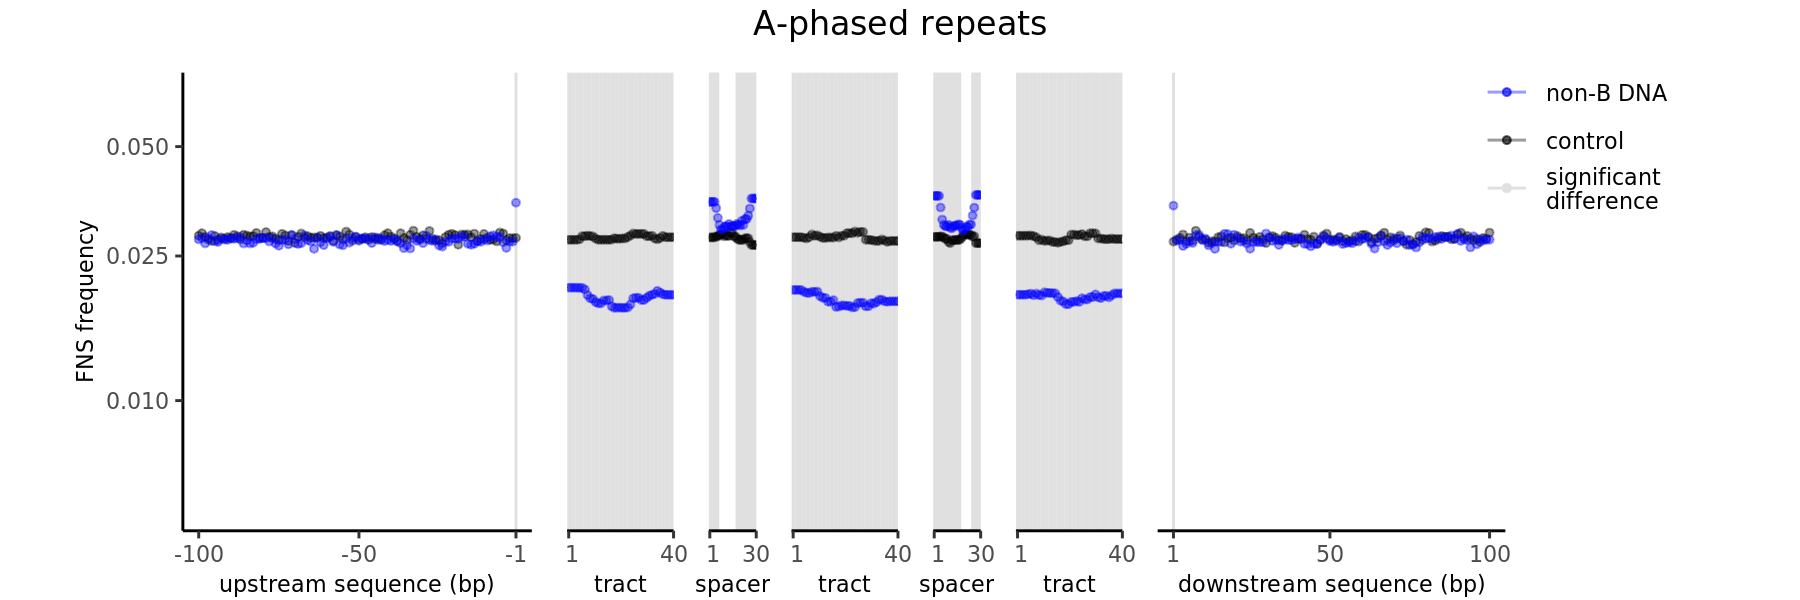

In [420]:
%%R -w 9 -h 3 --units in -r 200

#csvfile <- read.csv('NCNRAPhasedRepeats.divergence.intersect.csv', header = TRUE)
csvfile <- csvfile[which(csvfile$snp_start != "NA"),]

LeftFlank <- table(csvfile[which(csvfile$snp_pos == "LeftFlank"),10])/99583 
tract1 <- table(csvfile[which(csvfile$snp_pos == "Tract1"),10])/99583 
spacer1 <- table(csvfile[which(csvfile$snp_pos == "Spacer1"),10])/99583 
tract2 <- table(csvfile[which(csvfile$snp_pos == "Tract2"),10])/99583 
spacer2 <- table(csvfile[which(csvfile$snp_pos == "Spacer2"),10])/99583 
tract3 <- table(csvfile[which(csvfile$snp_pos == "Tract3"),10])/99583 
RightFlank <- table(csvfile[which(csvfile$snp_pos == "RightFlank"),10])/99583 


#c_csvfile <- read.csv('NCNRAPhasedRepeats.divergence.ctrl.intersect.csv', header = TRUE)
c_csvfile <- c_csvfile[which(c_csvfile$snp_start != "NA"),]

c_LeftFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "LeftFlank"),10])/101267 
c_tract1 <- table(c_csvfile[which(c_csvfile$snp_pos == "Tract1"),10])/101267 
c_spacer1 <- table(c_csvfile[which(c_csvfile$snp_pos == "Spacer1"),10])/101267 
c_tract2 <- table(c_csvfile[which(c_csvfile$snp_pos == "Tract2"),10])/101267 
c_spacer2 <- table(c_csvfile[which(c_csvfile$snp_pos == "Spacer2"),10])/101267 
c_tract3 <- table(c_csvfile[which(c_csvfile$snp_pos == "Tract3"),10])/101267 
c_RightFlank <- table(c_csvfile[which(c_csvfile$snp_pos == "RightFlank"),10])/101267 


cols <- c("non-B DNA"=rgb(t(col2rgb('blue')), alpha=100, maxColorValue = 255),
          "significant\ndifference"="grey88",
          "control"=rgb(t(col2rgb('black')), alpha=100, maxColorValue = 255))

load('APhasedRepeats.divergence_motif_vs_control_IWTomics_center_0.01.RData')
load('APhasedRepeats.divergence_motif_vs_control_IWTomics_left_0.01.RData')
load('APhasedRepeats.divergence_motif_vs_control_IWTomics_right_0.01.RData')


LeftFlankDf <- cbind.data.frame(LeftFlank,c_LeftFlank,adj_pvalue_curve_left$significant)[,c(1,2,4,5)]
names(LeftFlankDf) <- c('Levels','Freq','C_Freq','Signif')
LeftFlankDf$Levels <- as.numeric(as.character(LeftFlankDf$Levels))
LeftFlankDf_cut <- LeftFlankDf[which(LeftFlankDf$Levels >= -100),]
LeftFlankDf_cut$Levels <- seq(-100,-1,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'Tract1'),"significant"]
tract1Df <- cbind.data.frame(tract1,c_tract1,Signif)[,c(1,2,4,5)]
names(tract1Df) <- c('Levels','Freq','C_Freq','Signif')
tract1Df$Levels <- seq(1,40,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'Spacer1'),"significant"]
spacer1Df <- cbind.data.frame(spacer1,c_spacer1,Signif)[,c(1,2,4,5)]
names(spacer1Df) <- c('Levels','Freq','C_Freq','Signif')
spacer1Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'Tract2'),"significant"]
tract2Df <- cbind.data.frame(tract2,c_tract2,Signif)[,c(1,2,4,5)]
names(tract2Df) <- c('Levels','Freq','C_Freq','Signif')
tract2Df$Levels <- seq(1,40,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'Spacer2'),"significant"]
spacer2Df <- cbind.data.frame(spacer2,c_spacer2,Signif)[,c(1,2,4,5)]
names(spacer2Df) <- c('Levels','Freq','C_Freq','Signif')
spacer2Df$Levels <- seq(1,30,1)

Signif <- adj_pvalue_curve_center[which(adj_pvalue_curve_center$subpart == 'Tract3'),"significant"]
tract3Df <- cbind.data.frame(tract3,c_tract3,Signif)[,c(1,2,4,5)]
names(tract3Df) <- c('Levels','Freq','C_Freq','Signif')
tract3Df$Levels <- seq(1,40,1)

RightFlankDf <- cbind.data.frame(RightFlank,c_RightFlank,adj_pvalue_curve_right$significant)[,c(1,2,4,5)]
names(RightFlankDf) <- c('Levels','Freq','C_Freq','Signif')
RightFlankDf$Levels <- as.numeric(as.character(RightFlankDf$Levels))
RightFlankDf_cut <- RightFlankDf[which(RightFlankDf$Levels <= 100),]
RightFlankDf_cut$Levels <- seq(1,100,1)

p1 <- ggplot(LeftFlankDf, aes(x=Levels)) + 
                            geom_vline(xintercept= LeftFlankDf[which(LeftFlankDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.title = element_text(size=8,family="sans"),
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.text.y = element_text(size=8,family="sans")) +
                            labs(y="FNS frequency", x="upstream sequence (bp)", size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_continuous(breaks =  c(-100,-50,-1), limits = c(-100,-1)) +
                            theme(plot.margin = unit(c(10,5,1,1), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07), breaks = c(0.010,0.025,0.050) )

p2 <- ggplot(tract1Df,  aes(x=Levels)) + 
                            geom_vline(xintercept= tract1Df[which(tract1Df$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8, family='sans'),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="tract",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 40), limits = c(1, 40)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))



p3 <- ggplot(spacer1Df,  aes(x=Levels)) + 
                            geom_vline(xintercept= spacer1Df[which(spacer1Df$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8, family='sans'),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="spacer",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))



p4 <- ggplot(tract2Df,  aes(x=Levels)) + 
                            geom_vline(xintercept= tract2Df[which(tract2Df$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8, family='sans'),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="tract",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 40), limits = c(1, 40)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))

p5 <- ggplot(spacer2Df,  aes(x=Levels)) + 
                            geom_vline(xintercept= spacer2Df[which(spacer2Df$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8, family='sans'),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="spacer",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 30), limits = c(1, 30)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))

p6 <- ggplot(tract3Df,  aes(x=Levels)) + 
                            geom_vline(xintercept= tract3Df[which(tract3Df$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() + 
                            theme(legend.position="none",
                                axis.text.x = element_text(size=8, family='sans'),
                                axis.title.x = element_text(size=8,family="sans"),
                                axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank()) +
                            labs(x="tract",size=8, family='sans') +
                            scale_colour_manual(name="",values=cols) +
                            scale_x_discrete(breaks =  c(1, 40), limits = c(1, 40)) +
                            theme(plot.margin = unit(c(10,5,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07))


p7 <- ggplot(RightFlankDf, aes(x=Levels)) + 
                            geom_line(aes(x=0,y=0,colour="significant\ndifference")) +
                            geom_vline(xintercept= RightFlankDf[which(RightFlankDf$Signif == "TRUE"),"Levels"], col="gray88") +
                            geom_point(aes(y=C_Freq,col="control"), size = 1) +
                            geom_point(aes(y=Freq,col="non-B DNA"), size = 1) +
                            theme_classic() +
                            theme(axis.title.y=element_blank(),
                                axis.text.y=element_blank(),
                                axis.ticks.y=element_blank(),
                                axis.line.y=element_blank(),
                                axis.text.x = element_text(size=8,family="sans"),
                                axis.title.x = element_text(size=8,family="sans"),
                                legend.text=element_text(size=8,family="sans"),
                                legend.position=c(1.2, 0.9)) +
                            labs(x="downstream sequence (bp)",size=8, family='sans')+
                            scale_colour_manual(name="",values=cols, breaks = c('non-B DNA', 'control', 'significant\ndifference')) +
                            scale_x_continuous(breaks = c(1,50,100), limits = c(1,100)) +
                            theme(plot.margin = unit(c(10,80,1,5), "pt")) +
                            scale_y_continuous(trans='log', limits = c(0.005,0.07)) +
                            guides(shape = guide_legend(order = 3))



grid.arrange(p1, p2, p3, p4, p5, p6, p7, ncol=7, 
            widths=unit(c(60,18,10.5,18,10.5,18,75), c("mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("A-phased repeats",gp=gpar(fontsize=12,family="sans")))

g <- arrangeGrob(p1, p2, p3, p4, p5, p6, p7, ncol=7, 
            widths=unit(c(60,18,10.5,18,10.5,18,75), c("mm", "mm", "mm", "mm", "mm", "mm", "mm")),
            top=textGrob("A-phased repeats",gp=gpar(fontsize=12,family="sans")))

ggsave(file='AR_Divergence.pdf',g, width=9, height=3, dpi=300)




In [450]:
%%R
min(adj_pvalue_curve_left[which(adj_pvalue_curve_left$significant == "TRUE"),"snp_coord"])


[1] -1


In [451]:
%%R
max(adj_pvalue_curve_right[which(adj_pvalue_curve_right$significant == "TRUE"),"snp_coord"])


[1] 1


In [452]:
%%R

flanks <- rbind(LeftFlankDf,RightFlankDf)
print(max(flanks$C_Freq/flanks$Freq))

tract1Df <- tract1Df[which(tract1Df$Levels != 0),]
tract1Df <- tract1Df[which(tract1Df$Levels != 1),]
tract2Df <- tract2Df[which(tract2Df$Levels != 0),]
tract2Df <- tract2Df[which(tract2Df$Levels != 1),]
tract3Df <- tract3Df[which(tract3Df$Levels != 0),]
tract3Df <- tract3Df[which(tract3Df$Levels != 1),]
tracts <- rbind(tract1Df,tract2Df,tract3Df)
print(max(tracts$C_Freq/tracts$Freq))

spacer1Df <- spacer1Df[which(spacer1Df$Levels != 0),]
spacer1Df <- spacer1Df[which(spacer1Df$Levels != 1),]
spacer2Df <- spacer2Df[which(spacer2Df$Levels != 0),]
spacer2Df <- spacer2Df[which(spacer2Df$Levels != 1),]

spacers <- rbind(spacer1Df,spacer2Df)
print(max(spacers$Freq/spacers$C_Freq))

[1] 1.110732
[1] 1.616006
[1] 1.357115


```
python Permuting.py NCNRAPhasedRepeats.SGDP.intersect.csv NCNRAPhasedRepeats.SGDP.ctrl.intersect.csv 99583 0 101267 0 NCNRAPhasedRepeats.SGDP.permuted NCNRAPhasedRepeats.ctrl.SGDP.permuted

python Permuting.py NCNRAPhasedRepeats.divergence.intersect.csv NCNRAPhasedRepeats.divergence.ctrl.intersect.csv 99583 0 101267 0 NCNRAPhasedRepeats.divergence.permuted NCNRAPhasedRepeats.ctrl.divergence.permuted
```

In [43]:
%%bash
# List SNPs at positions of interest and adjust coordinates for trinucleotide context
awk '{if ($5=="+") print $0 }' NCNRAPhasedRepeats.nooverlap.bed | awk 'BEGIN {OFS="\t"} {print $1, $6-2, $6+1}' | awk '{if ($2>0) print $0}'> NCNRAPhasedRepeats.trinucl.left.bed
awk '{if ($5=="+") print $0 }' NCNRAPhasedRepeats.ctrl.nooverlap.bed | awk 'BEGIN {OFS="\t"} {print $1, $6-2, $6+1}' | awk '{if ($2>0) print $0}'> NCNRAPhasedRepeats.shuffled.trinucl.left.bed

awk '{if ($5=="+") print $0 }' NCNRAPhasedRepeats.nooverlap.bed |awk 'BEGIN {OFS="\t"} {print $1, $7-1, $7+2}' > NCNRAPhasedRepeats.trinucl.right.bed
awk '{if ($5=="+") print $0 }' NCNRAPhasedRepeats.ctrl.nooverlap.bed |awk 'BEGIN {OFS="\t"} {print $1, $7-1, $7+2}' > NCNRAPhasedRepeats.shuffled.trinucl.right.bed


```
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRAPhasedRepeats.trinucl.left.bed > NCNRAPhasedRepeats.trinucl.left.fa
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRAPhasedRepeats.shuffled.trinucl.left.bed > NCNRAPhasedRepeats.shuffled.trinucl.left.fa

bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRAPhasedRepeats.trinucl.right.bed > NCNRAPhasedRepeats.trinucl.right.fa
bedtools getfasta -fi ../LocalVariation/hg19.fa -bed NCNRAPhasedRepeats.shuffled.trinucl.right.bed > NCNRAPhasedRepeats.shuffled.trinucl.right.fa
```

In [53]:
## Match SNPs of interest with SNP dictionary to obtain substitution type
import itertools
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests


Test = open('NCNRAPhasedRepeats.trinucl.left.fa', 'rt')
Control = open('NCNRAPhasedRepeats.shuffled.trinucl.left.fa', 'rt')

permutations = itertools.permutations(['A','T','G','C'], 2)
rows = []
for permutation in permutations:
    rows.append(trinucl_test(snpdict, Test, Control, permutation[0], permutation[1]))
    Test.seek(0)
    Control.seek(0)
    
colnames = ['ref','alt','test freq','ctrl freq', 'odds ratio', 'pvalue']
trinucl_df = pd.DataFrame(data=rows, columns=colnames)

trinucl_df = trinucl_df[trinucl_df['test freq'] != 'NA']

p_adjusted = multipletests(trinucl_df.pvalue, alpha=0.05, method='bonferroni')

trinucl_df['Adj. p-val'] = p_adjusted[1] 
del trinucl_df['pvalue']
print(trinucl_df)


   ref alt   test freq   ctrl freq  odds ratio  Adj. p-val
6    G   A   0.0110618   0.0125706    0.879971     1.00000
7    G   T  0.00393866  0.00346147    1.137857     1.00000
8    G   C  0.00255594  0.00264165    0.967554     1.00000
9    C   A  0.00445507  0.00286103    1.557159     0.05382
10   C   T  0.00900658  0.00958444    0.939709     1.00000
11   C   G  0.00337506  0.00286103    1.179666     1.00000


In [54]:
## Match SNPs of interest with SNP dictionary to obtain substitution type
import itertools

Test = open('NCNRAPhasedRepeats.trinucl.right.fa', 'rt')
Control = open('NCNRAPhasedRepeats.shuffled.trinucl.right.fa', 'rt')

permutations = itertools.permutations(['A','T','G','C'], 2)
rows = []
for permutation in permutations:
    rows.append(trinucl_test(snpdict, Test, Control, permutation[0], permutation[1]))
    Test.seek(0)
    Control.seek(0)
    
colnames = ['ref','alt','test freq','ctrl freq', 'odds ratio', 'pvalue']
trinucl_df = pd.DataFrame(data=rows, columns=colnames)

trinucl_df = trinucl_df[trinucl_df['test freq'] != 'NA']

p_adjusted = multipletests(trinucl_df.pvalue, alpha=0.05, method='bonferroni')

trinucl_df['Adj. p-val'] = p_adjusted[1] 
del trinucl_df['pvalue']
print(trinucl_df)


   ref alt   test freq   ctrl freq  odds ratio  Adj. p-val
6    G   A   0.0077947  0.00916914    0.850101    0.676790
7    G   T  0.00524753  0.00296234    1.771418    0.001940
8    G   C  0.00291104  0.00394978    0.737013    0.370845
9    C   A  0.00398874  0.00368732    1.081746    1.000000
10   C   T   0.0110412   0.0148228    0.744878    0.008678
11   C   G  0.00255447   0.0037961    0.672920    0.209291
